# Credit Card Fraud Detection

#### In this case, the goal is to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

#### The dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

#### It contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


#### Let's upload the dataset we are working on:

In [2]:
path = r"C:\Users\usuario\Desktop\Nebulova\Curso\Machine Learning\Ejercicios\Crédito\Kaggle"
dataset = pd.read_csv(path + "/creditcard.csv")
dataset.drop(columns="Time", inplace=True)

#### Although it's said in the case description, we will take a look at the number of fraud - non fraud transactions:

In [3]:
dataset["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

### Feature Engineering

#### We will analyze the distribution of each feature for both cases (fraud-non fraud) to see if the would have an impact on the prediction or not. We will drop those with similar distribution because they won't help us to predict a fraud.

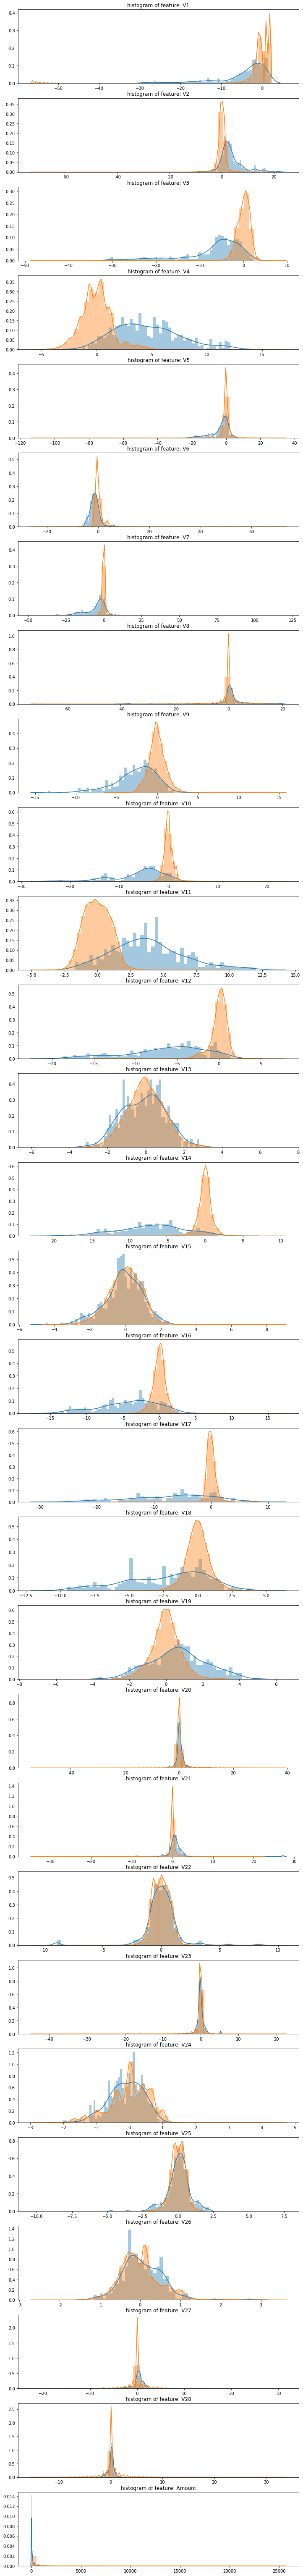

In [4]:
v_features = dataset.iloc[:, :29].columns
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(29, 1)
for i, cn in enumerate(dataset[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(dataset[cn][dataset.Class == 1], bins=50)
    sns.distplot(dataset[cn][dataset.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

#### As explained, we drop those features with a similar distribution for the fraud - non fraud cases:

In [5]:
dataset.drop(columns=["V13", "V15", "V22", "V23", "V24", "V25", "V26"], inplace=True)

#### Next step is to normalize the dataset:

In [6]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
scaler = MinMaxScaler()
Xy = scaler.fit_transform(dataset.values)
X = Xy[:, :-1]
y = Xy[:, -1]

#### Once it's normalized, the dataset should be splitted to have data to train the model and data to test the model:

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

#### As we have seen at the beginning, the dataset is clearly imbalanced, so we will perform an oversampling to have a balanced dataset. If this step is not done, the model will predict always the predominant class.

In [8]:
from imblearn.over_sampling import RandomOverSampler
cc = RandomOverSampler(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

### NEURAL NETWORK

#### We will try at first with a neural network. In this case, we will use a GridSearch to use the best parameters:

In [9]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers, Sequential, optimizers

def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 2)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=10, 
                                            max_value=60, 
                                            step=10),
                               activation='relu')),
    model.add(layers.Dense(2, activation='softmax'))
    opt = optimizers.Adam(learning_rate=0.005)
    model.compile(optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [10]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5, 
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld',
    overwrite=True)

In [11]:
history = tuner.search(X_resampled, y_resampled,
             epochs=5,
             #batch_size = 100,
             validation_data=(X_test, y_test))

Train on 454902 samples, validate on 56962 samples
Epoch 1/5


175776/454902 [==========>...................] - ETA: 2:22:25 - loss: 0.9691 - accuracy: 0.0000e+0 - ETA: 5:42 - loss: 0.7175 - accuracy: 0.4745      - ETA: 3:41 - loss: 0.7167 - accuracy: 0.45 - ETA: 2:20 - loss: 0.6954 - accuracy: 0.45 - ETA: 1:41 - loss: 0.6994 - accuracy: 0.46 - ETA: 1:22 - loss: 0.7031 - accuracy: 0.47 - ETA: 1:10 - loss: 0.7118 - accuracy: 0.45 - ETA: 1:01 - loss: 0.7074 - accuracy: 0.47 - ETA: 54s - loss: 0.7071 - accuracy: 0.4805 - ETA: 51s - loss: 0.7061 - accuracy: 0.487 - ETA: 46s - loss: 0.7026 - accuracy: 0.496 - ETA: 43s - loss: 0.7007 - accuracy: 0.502 - ETA: 42s - loss: 0.6995 - accuracy: 0.506 - ETA: 40s - loss: 0.6965 - accuracy: 0.511 - ETA: 38s - loss: 0.6999 - accuracy: 0.513 - ETA: 36s - loss: 0.6987 - accuracy: 0.517 - ETA: 35s - loss: 0.6978 - accuracy: 0.520 - ETA: 34s - loss: 0.6996 - accuracy: 0.522 - ETA: 33s - loss: 0.7011 - accuracy: 0.522 - ETA: 32s - loss: 0.7032 - accuracy: 0.521 - ETA: 31s - loss: 0.7028 - accuracy: 0.522 - ETA: 30s - 

372736/454902 [=======================>......] - ETA: 15s - loss: 0.6991 - accuracy: 0.525 - ETA: 15s - loss: 0.6991 - accuracy: 0.524 - ETA: 15s - loss: 0.6991 - accuracy: 0.525 - ETA: 15s - loss: 0.6992 - accuracy: 0.524 - ETA: 15s - loss: 0.6991 - accuracy: 0.524 - ETA: 15s - loss: 0.6991 - accuracy: 0.524 - ETA: 15s - loss: 0.6992 - accuracy: 0.524 - ETA: 15s - loss: 0.6992 - accuracy: 0.524 - ETA: 15s - loss: 0.6991 - accuracy: 0.524 - ETA: 15s - loss: 0.6991 - accuracy: 0.524 - ETA: 15s - loss: 0.6990 - accuracy: 0.524 - ETA: 15s - loss: 0.6990 - accuracy: 0.524 - ETA: 14s - loss: 0.6991 - accuracy: 0.524 - ETA: 14s - loss: 0.6989 - accuracy: 0.524 - ETA: 14s - loss: 0.6988 - accuracy: 0.524 - ETA: 14s - loss: 0.6989 - accuracy: 0.524 - ETA: 14s - loss: 0.6990 - accuracy: 0.523 - ETA: 14s - loss: 0.6991 - accuracy: 0.523 - ETA: 14s - loss: 0.6990 - accuracy: 0.523 - ETA: 14s - loss: 0.6991 - accuracy: 0.523 - ETA: 14s - loss: 0.6989 - accuracy: 0.523 - ETA: 14s - loss: 0.6989 - a

454902/454902 [==============================] - ETA: 4s - loss: 0.7041 - accuracy: 0.51 - ETA: 4s - loss: 0.7041 - accuracy: 0.51 - ETA: 4s - loss: 0.7042 - accuracy: 0.51 - ETA: 4s - loss: 0.7042 - accuracy: 0.51 - ETA: 4s - loss: 0.7042 - accuracy: 0.51 - ETA: 4s - loss: 0.7043 - accuracy: 0.51 - ETA: 4s - loss: 0.7042 - accuracy: 0.51 - ETA: 4s - loss: 0.7041 - accuracy: 0.51 - ETA: 4s - loss: 0.7042 - accuracy: 0.51 - ETA: 4s - loss: 0.7042 - accuracy: 0.51 - ETA: 4s - loss: 0.7041 - accuracy: 0.51 - ETA: 4s - loss: 0.7041 - accuracy: 0.51 - ETA: 4s - loss: 0.7041 - accuracy: 0.51 - ETA: 3s - loss: 0.7041 - accuracy: 0.51 - ETA: 3s - loss: 0.7042 - accuracy: 0.51 - ETA: 3s - loss: 0.7042 - accuracy: 0.51 - ETA: 3s - loss: 0.7042 - accuracy: 0.51 - ETA: 3s - loss: 0.7042 - accuracy: 0.51 - ETA: 3s - loss: 0.7043 - accuracy: 0.51 - ETA: 3s - loss: 0.7044 - accuracy: 0.51 - ETA: 3s - loss: 0.7044 - accuracy: 0.51 - ETA: 3s - loss: 0.7044 - accuracy: 0.51 - ETA: 3s - loss: 0.7044 - ac

198624/454902 [============>.................] - ETA: 1:10 - loss: 1.0549 - accuracy: 0.0000e+ - ETA: 46s - loss: 0.7239 - accuracy: 0.4099     - ETA: 39s - loss: 0.7062 - accuracy: 0.452 - ETA: 37s - loss: 0.7141 - accuracy: 0.478 - ETA: 37s - loss: 0.7204 - accuracy: 0.472 - ETA: 37s - loss: 0.7159 - accuracy: 0.478 - ETA: 38s - loss: 0.7158 - accuracy: 0.479 - ETA: 38s - loss: 0.7065 - accuracy: 0.477 - ETA: 37s - loss: 0.7083 - accuracy: 0.480 - ETA: 37s - loss: 0.7057 - accuracy: 0.478 - ETA: 37s - loss: 0.7138 - accuracy: 0.469 - ETA: 37s - loss: 0.7123 - accuracy: 0.466 - ETA: 37s - loss: 0.7113 - accuracy: 0.464 - ETA: 37s - loss: 0.7086 - accuracy: 0.461 - ETA: 35s - loss: 0.7054 - accuracy: 0.465 - ETA: 34s - loss: 0.7015 - accuracy: 0.466 - ETA: 33s - loss: 0.7039 - accuracy: 0.467 - ETA: 32s - loss: 0.7062 - accuracy: 0.467 - ETA: 30s - loss: 0.7070 - accuracy: 0.470 - ETA: 30s - loss: 0.7109 - accuracy: 0.470 - ETA: 30s - loss: 0.7112 - accuracy: 0.471 - ETA: 29s - loss: 0

404352/454902 [=========================>....] - ETA: 12s - loss: 0.7711 - accuracy: 0.490 - ETA: 12s - loss: 0.7710 - accuracy: 0.490 - ETA: 11s - loss: 0.7709 - accuracy: 0.490 - ETA: 11s - loss: 0.7708 - accuracy: 0.490 - ETA: 11s - loss: 0.7707 - accuracy: 0.489 - ETA: 11s - loss: 0.7707 - accuracy: 0.490 - ETA: 11s - loss: 0.7705 - accuracy: 0.490 - ETA: 11s - loss: 0.7708 - accuracy: 0.490 - ETA: 11s - loss: 0.7709 - accuracy: 0.490 - ETA: 11s - loss: 0.7708 - accuracy: 0.490 - ETA: 11s - loss: 0.7709 - accuracy: 0.490 - ETA: 11s - loss: 0.7718 - accuracy: 0.490 - ETA: 11s - loss: 0.7722 - accuracy: 0.490 - ETA: 11s - loss: 0.7732 - accuracy: 0.490 - ETA: 11s - loss: 0.7737 - accuracy: 0.490 - ETA: 10s - loss: 0.7737 - accuracy: 0.491 - ETA: 10s - loss: 0.7739 - accuracy: 0.491 - ETA: 10s - loss: 0.7736 - accuracy: 0.491 - ETA: 10s - loss: 0.7739 - accuracy: 0.491 - ETA: 10s - loss: 0.7741 - accuracy: 0.491 - ETA: 10s - loss: 0.7740 - accuracy: 0.491 - ETA: 10s - loss: 0.7741 - a

454902/454902 [==============================] - ETA: 2s - loss: 0.8264 - accuracy: 0.49 - ETA: 2s - loss: 0.8264 - accuracy: 0.49 - ETA: 2s - loss: 0.8264 - accuracy: 0.49 - ETA: 2s - loss: 0.8263 - accuracy: 0.49 - ETA: 2s - loss: 0.8263 - accuracy: 0.49 - ETA: 2s - loss: 0.8264 - accuracy: 0.49 - ETA: 2s - loss: 0.8264 - accuracy: 0.49 - ETA: 2s - loss: 0.8263 - accuracy: 0.49 - ETA: 1s - loss: 0.8268 - accuracy: 0.49 - ETA: 1s - loss: 0.8269 - accuracy: 0.49 - ETA: 1s - loss: 0.8271 - accuracy: 0.49 - ETA: 1s - loss: 0.8271 - accuracy: 0.49 - ETA: 1s - loss: 0.8270 - accuracy: 0.49 - ETA: 1s - loss: 0.8270 - accuracy: 0.49 - ETA: 1s - loss: 0.8270 - accuracy: 0.49 - ETA: 1s - loss: 0.8270 - accuracy: 0.49 - ETA: 1s - loss: 0.8270 - accuracy: 0.49 - ETA: 1s - loss: 0.8270 - accuracy: 0.49 - ETA: 1s - loss: 0.8274 - accuracy: 0.49 - ETA: 1s - loss: 0.8275 - accuracy: 0.49 - ETA: 1s - loss: 0.8274 - accuracy: 0.49 - ETA: 1s - loss: 0.8291 - accuracy: 0.49 - ETA: 1s - loss: 0.8313 - ac

177632/454902 [==========>...................] - ETA: 1:10 - loss: 0.9551 - accuracy: 0.40 - ETA: 37s - loss: 1.0505 - accuracy: 0.5506 - ETA: 34s - loss: 1.0659 - accuracy: 0.518 - ETA: 35s - loss: 1.0695 - accuracy: 0.507 - ETA: 35s - loss: 1.0430 - accuracy: 0.502 - ETA: 34s - loss: 1.0898 - accuracy: 0.501 - ETA: 34s - loss: 1.1605 - accuracy: 0.499 - ETA: 34s - loss: 1.1210 - accuracy: 0.498 - ETA: 34s - loss: 1.0814 - accuracy: 0.497 - ETA: 34s - loss: 1.0359 - accuracy: 0.503 - ETA: 34s - loss: 1.0045 - accuracy: 0.500 - ETA: 34s - loss: 0.9921 - accuracy: 0.502 - ETA: 34s - loss: 1.0208 - accuracy: 0.503 - ETA: 34s - loss: 1.0104 - accuracy: 0.500 - ETA: 33s - loss: 0.9963 - accuracy: 0.497 - ETA: 33s - loss: 0.9894 - accuracy: 0.499 - ETA: 33s - loss: 0.9998 - accuracy: 0.498 - ETA: 33s - loss: 1.0189 - accuracy: 0.499 - ETA: 33s - loss: 1.0172 - accuracy: 0.493 - ETA: 34s - loss: 1.0131 - accuracy: 0.493 - ETA: 35s - loss: 1.0068 - accuracy: 0.495 - ETA: 34s - loss: 0.9926 - 

364544/454902 [=======================>......] - ETA: 14s - loss: 1.1116 - accuracy: 0.507 - ETA: 14s - loss: 1.1188 - accuracy: 0.506 - ETA: 14s - loss: 1.1230 - accuracy: 0.507 - ETA: 14s - loss: 1.1232 - accuracy: 0.506 - ETA: 14s - loss: 1.1219 - accuracy: 0.506 - ETA: 14s - loss: 1.1203 - accuracy: 0.506 - ETA: 14s - loss: 1.1247 - accuracy: 0.506 - ETA: 13s - loss: 1.1283 - accuracy: 0.506 - ETA: 13s - loss: 1.1281 - accuracy: 0.506 - ETA: 13s - loss: 1.1269 - accuracy: 0.506 - ETA: 13s - loss: 1.1252 - accuracy: 0.506 - ETA: 13s - loss: 1.1233 - accuracy: 0.506 - ETA: 13s - loss: 1.1222 - accuracy: 0.506 - ETA: 13s - loss: 1.1220 - accuracy: 0.506 - ETA: 13s - loss: 1.1206 - accuracy: 0.507 - ETA: 13s - loss: 1.1183 - accuracy: 0.506 - ETA: 13s - loss: 1.1183 - accuracy: 0.506 - ETA: 13s - loss: 1.1188 - accuracy: 0.507 - ETA: 13s - loss: 1.1170 - accuracy: 0.507 - ETA: 12s - loss: 1.1155 - accuracy: 0.507 - ETA: 12s - loss: 1.1145 - accuracy: 0.507 - ETA: 12s - loss: 1.1135 - a

454902/454902 [==============================] - ETA: 4s - loss: 1.2483 - accuracy: 0.50 - ETA: 4s - loss: 1.2477 - accuracy: 0.50 - ETA: 4s - loss: 1.2471 - accuracy: 0.50 - ETA: 4s - loss: 1.2464 - accuracy: 0.50 - ETA: 4s - loss: 1.2456 - accuracy: 0.50 - ETA: 4s - loss: 1.2447 - accuracy: 0.50 - ETA: 4s - loss: 1.2438 - accuracy: 0.50 - ETA: 4s - loss: 1.2432 - accuracy: 0.50 - ETA: 4s - loss: 1.2427 - accuracy: 0.50 - ETA: 4s - loss: 1.2434 - accuracy: 0.50 - ETA: 4s - loss: 1.2469 - accuracy: 0.50 - ETA: 4s - loss: 1.2542 - accuracy: 0.50 - ETA: 4s - loss: 1.2563 - accuracy: 0.50 - ETA: 4s - loss: 1.2602 - accuracy: 0.50 - ETA: 4s - loss: 1.2653 - accuracy: 0.50 - ETA: 4s - loss: 1.2668 - accuracy: 0.50 - ETA: 3s - loss: 1.2682 - accuracy: 0.50 - ETA: 3s - loss: 1.2695 - accuracy: 0.50 - ETA: 3s - loss: 1.2682 - accuracy: 0.50 - ETA: 3s - loss: 1.2670 - accuracy: 0.50 - ETA: 3s - loss: 1.2664 - accuracy: 0.50 - ETA: 3s - loss: 1.2651 - accuracy: 0.50 - ETA: 3s - loss: 1.2643 - ac

192352/454902 [===========>..................] - ETA: 42s - loss: 3.6675 - accuracy: 1.000 - ETA: 20s - loss: 1.6004 - accuracy: 0.524 - ETA: 19s - loss: 1.9176 - accuracy: 0.499 - ETA: 20s - loss: 1.9419 - accuracy: 0.504 - ETA: 19s - loss: 1.9131 - accuracy: 0.511 - ETA: 20s - loss: 1.8724 - accuracy: 0.511 - ETA: 20s - loss: 2.0651 - accuracy: 0.507 - ETA: 19s - loss: 2.0454 - accuracy: 0.505 - ETA: 19s - loss: 2.1384 - accuracy: 0.503 - ETA: 18s - loss: 2.1918 - accuracy: 0.504 - ETA: 18s - loss: 2.1262 - accuracy: 0.502 - ETA: 18s - loss: 2.0866 - accuracy: 0.503 - ETA: 18s - loss: 2.0905 - accuracy: 0.503 - ETA: 18s - loss: 2.0968 - accuracy: 0.502 - ETA: 18s - loss: 2.0220 - accuracy: 0.503 - ETA: 18s - loss: 1.9523 - accuracy: 0.502 - ETA: 19s - loss: 1.9105 - accuracy: 0.502 - ETA: 19s - loss: 1.8710 - accuracy: 0.500 - ETA: 19s - loss: 1.8639 - accuracy: 0.500 - ETA: 19s - loss: 1.8643 - accuracy: 0.500 - ETA: 20s - loss: 1.8380 - accuracy: 0.500 - ETA: 20s - loss: 1.8123 - a

417792/454902 [==========================>...] - ETA: 12s - loss: 1.9776 - accuracy: 0.502 - ETA: 12s - loss: 1.9844 - accuracy: 0.502 - ETA: 12s - loss: 1.9818 - accuracy: 0.502 - ETA: 12s - loss: 1.9760 - accuracy: 0.502 - ETA: 12s - loss: 1.9709 - accuracy: 0.502 - ETA: 12s - loss: 1.9702 - accuracy: 0.503 - ETA: 12s - loss: 1.9703 - accuracy: 0.503 - ETA: 12s - loss: 1.9655 - accuracy: 0.503 - ETA: 12s - loss: 1.9660 - accuracy: 0.503 - ETA: 12s - loss: 1.9642 - accuracy: 0.503 - ETA: 12s - loss: 1.9769 - accuracy: 0.503 - ETA: 12s - loss: 1.9813 - accuracy: 0.503 - ETA: 11s - loss: 1.9850 - accuracy: 0.503 - ETA: 11s - loss: 1.9854 - accuracy: 0.503 - ETA: 11s - loss: 1.9868 - accuracy: 0.503 - ETA: 11s - loss: 1.9851 - accuracy: 0.502 - ETA: 11s - loss: 1.9839 - accuracy: 0.502 - ETA: 11s - loss: 1.9871 - accuracy: 0.502 - ETA: 11s - loss: 1.9937 - accuracy: 0.502 - ETA: 11s - loss: 1.9933 - accuracy: 0.502 - ETA: 11s - loss: 1.9955 - accuracy: 0.502 - ETA: 11s - loss: 1.9983 - a

454902/454902 [==============================] - ETA: 1s - loss: 2.1795 - accuracy: 0.50 - ETA: 1s - loss: 2.1797 - accuracy: 0.50 - ETA: 1s - loss: 2.1785 - accuracy: 0.50 - ETA: 1s - loss: 2.1753 - accuracy: 0.50 - ETA: 1s - loss: 2.1765 - accuracy: 0.50 - ETA: 1s - loss: 2.1828 - accuracy: 0.50 - ETA: 1s - loss: 2.1937 - accuracy: 0.50 - ETA: 1s - loss: 2.1968 - accuracy: 0.50 - ETA: 1s - loss: 2.1996 - accuracy: 0.50 - ETA: 1s - loss: 2.1965 - accuracy: 0.50 - ETA: 1s - loss: 2.1931 - accuracy: 0.50 - ETA: 0s - loss: 2.1908 - accuracy: 0.50 - ETA: 0s - loss: 2.1975 - accuracy: 0.50 - ETA: 0s - loss: 2.2009 - accuracy: 0.50 - ETA: 0s - loss: 2.2010 - accuracy: 0.50 - ETA: 0s - loss: 2.2031 - accuracy: 0.50 - ETA: 0s - loss: 2.2030 - accuracy: 0.50 - ETA: 0s - loss: 2.2052 - accuracy: 0.50 - ETA: 0s - loss: 2.2032 - accuracy: 0.50 - ETA: 0s - loss: 2.2037 - accuracy: 0.50 - ETA: 0s - loss: 2.2080 - accuracy: 0.50 - ETA: 0s - loss: 2.2087 - accuracy: 0.50 - ETA: 0s - loss: 2.2078 - ac

227424/454902 [=============>................] - ETA: 42s - loss: 1.2337 - accuracy: 0.187 - ETA: 22s - loss: 1.8433 - accuracy: 0.491 - ETA: 20s - loss: 1.6456 - accuracy: 0.487 - ETA: 19s - loss: 1.8994 - accuracy: 0.490 - ETA: 19s - loss: 2.8865 - accuracy: 0.501 - ETA: 19s - loss: 3.0179 - accuracy: 0.498 - ETA: 19s - loss: 3.3093 - accuracy: 0.501 - ETA: 18s - loss: 3.3905 - accuracy: 0.496 - ETA: 18s - loss: 3.4777 - accuracy: 0.496 - ETA: 18s - loss: 3.4751 - accuracy: 0.499 - ETA: 18s - loss: 3.4379 - accuracy: 0.500 - ETA: 18s - loss: 3.2877 - accuracy: 0.500 - ETA: 18s - loss: 3.3734 - accuracy: 0.497 - ETA: 18s - loss: 3.3608 - accuracy: 0.498 - ETA: 17s - loss: 3.3490 - accuracy: 0.499 - ETA: 17s - loss: 3.4028 - accuracy: 0.499 - ETA: 17s - loss: 3.4294 - accuracy: 0.501 - ETA: 17s - loss: 3.3066 - accuracy: 0.499 - ETA: 17s - loss: 3.2102 - accuracy: 0.500 - ETA: 17s - loss: 3.1133 - accuracy: 0.502 - ETA: 17s - loss: 3.0641 - accuracy: 0.503 - ETA: 17s - loss: 3.1065 - a

446976/454902 [============================>.] - ETA: 9s - loss: 3.0614 - accuracy: 0.50 - ETA: 9s - loss: 3.0620 - accuracy: 0.50 - ETA: 9s - loss: 3.0603 - accuracy: 0.50 - ETA: 9s - loss: 3.0549 - accuracy: 0.50 - ETA: 9s - loss: 3.0460 - accuracy: 0.50 - ETA: 9s - loss: 3.0465 - accuracy: 0.50 - ETA: 9s - loss: 3.0455 - accuracy: 0.50 - ETA: 9s - loss: 3.0405 - accuracy: 0.50 - ETA: 8s - loss: 3.0397 - accuracy: 0.50 - ETA: 8s - loss: 3.0379 - accuracy: 0.50 - ETA: 8s - loss: 3.0321 - accuracy: 0.50 - ETA: 8s - loss: 3.0462 - accuracy: 0.50 - ETA: 8s - loss: 3.0453 - accuracy: 0.50 - ETA: 8s - loss: 3.0443 - accuracy: 0.50 - ETA: 8s - loss: 3.0497 - accuracy: 0.50 - ETA: 8s - loss: 3.0533 - accuracy: 0.50 - ETA: 8s - loss: 3.0539 - accuracy: 0.50 - ETA: 8s - loss: 3.0578 - accuracy: 0.50 - ETA: 8s - loss: 3.0578 - accuracy: 0.50 - ETA: 8s - loss: 3.0580 - accuracy: 0.50 - ETA: 8s - loss: 3.0561 - accuracy: 0.50 - ETA: 8s - loss: 3.0539 - accuracy: 0.50 - ETA: 8s - loss: 3.0510 - ac

454902/454902 [==============================] - ETA: 0s - loss: 3.2575 - accuracy: 0.50 - ETA: 0s - loss: 3.2613 - accuracy: 0.50 - ETA: 0s - loss: 3.2627 - accuracy: 0.50 - ETA: 0s - loss: 3.2610 - accuracy: 0.50 - ETA: 0s - loss: 3.2597 - accuracy: 0.50 - ETA: 0s - loss: 3.2595 - accuracy: 0.50 - ETA: 0s - loss: 3.2605 - accuracy: 0.50 - ETA: 0s - loss: 3.2620 - accuracy: 0.50 - 21s 47us/sample - loss: 3.2628 - accuracy: 0.5028 - val_loss: 0.0046 - val_accuracy: 0.0041
Train on 454902 samples, validate on 56962 samples
Epoch 1/5


215616/454902 [=============>................] - ETA: 2:13:37 - loss: 0.7827 - accuracy: 0.031 - ETA: 4:41 - loss: 0.7207 - accuracy: 0.5010  - ETA: 2:48 - loss: 0.7088 - accuracy: 0.55 - ETA: 2:03 - loss: 0.7148 - accuracy: 0.54 - ETA: 1:28 - loss: 0.7095 - accuracy: 0.56 - ETA: 1:09 - loss: 0.7063 - accuracy: 0.56 - ETA: 57s - loss: 0.7055 - accuracy: 0.5530 - ETA: 50s - loss: 0.7054 - accuracy: 0.551 - ETA: 45s - loss: 0.7058 - accuracy: 0.549 - ETA: 42s - loss: 0.7010 - accuracy: 0.551 - ETA: 39s - loss: 0.7034 - accuracy: 0.550 - ETA: 38s - loss: 0.7014 - accuracy: 0.550 - ETA: 36s - loss: 0.7016 - accuracy: 0.549 - ETA: 35s - loss: 0.7008 - accuracy: 0.550 - ETA: 34s - loss: 0.6990 - accuracy: 0.550 - ETA: 34s - loss: 0.6990 - accuracy: 0.550 - ETA: 33s - loss: 0.6997 - accuracy: 0.549 - ETA: 32s - loss: 0.6977 - accuracy: 0.551 - ETA: 31s - loss: 0.6973 - accuracy: 0.552 - ETA: 31s - loss: 0.6981 - accuracy: 0.551 - ETA: 30s - loss: 0.6967 - accuracy: 0.553 - ETA: 29s - loss: 0.

436704/454902 [===========================>..] - ETA: 10s - loss: 0.6988 - accuracy: 0.523 - ETA: 10s - loss: 0.6991 - accuracy: 0.522 - ETA: 10s - loss: 0.6992 - accuracy: 0.522 - ETA: 10s - loss: 0.6993 - accuracy: 0.522 - ETA: 10s - loss: 0.6995 - accuracy: 0.522 - ETA: 10s - loss: 0.6994 - accuracy: 0.522 - ETA: 10s - loss: 0.6995 - accuracy: 0.521 - ETA: 10s - loss: 0.6996 - accuracy: 0.521 - ETA: 10s - loss: 0.6997 - accuracy: 0.521 - ETA: 10s - loss: 0.6999 - accuracy: 0.521 - ETA: 10s - loss: 0.7001 - accuracy: 0.521 - ETA: 10s - loss: 0.7000 - accuracy: 0.521 - ETA: 10s - loss: 0.7000 - accuracy: 0.521 - ETA: 10s - loss: 0.7000 - accuracy: 0.521 - ETA: 10s - loss: 0.7000 - accuracy: 0.521 - ETA: 10s - loss: 0.6998 - accuracy: 0.520 - ETA: 10s - loss: 0.6998 - accuracy: 0.520 - ETA: 10s - loss: 0.6999 - accuracy: 0.520 - ETA: 10s - loss: 0.6998 - accuracy: 0.520 - ETA: 10s - loss: 0.7000 - accuracy: 0.519 - ETA: 9s - loss: 0.7002 - accuracy: 0.519 - ETA: 9s - loss: 0.7003 - acc

454902/454902 [==============================] - ETA: 0s - loss: 0.7095 - accuracy: 0.50 - ETA: 0s - loss: 0.7095 - accuracy: 0.50 - ETA: 0s - loss: 0.7095 - accuracy: 0.50 - ETA: 0s - loss: 0.7096 - accuracy: 0.50 - ETA: 0s - loss: 0.7096 - accuracy: 0.50 - ETA: 0s - loss: 0.7098 - accuracy: 0.50 - ETA: 0s - loss: 0.7099 - accuracy: 0.50 - ETA: 0s - loss: 0.7101 - accuracy: 0.50 - ETA: 0s - loss: 0.7102 - accuracy: 0.50 - ETA: 0s - loss: 0.7104 - accuracy: 0.50 - ETA: 0s - loss: 0.7106 - accuracy: 0.50 - ETA: 0s - loss: 0.7107 - accuracy: 0.50 - ETA: 0s - loss: 0.7109 - accuracy: 0.50 - 22s 49us/sample - loss: 0.7110 - accuracy: 0.5047 - val_loss: 0.0031 - val_accuracy: 5.2667e-05
Epoch 2/5


214944/454902 [=============>................] - ETA: 56s - loss: 0.8494 - accuracy: 0.0000e+0 - ETA: 31s - loss: 0.7475 - accuracy: 0.5225    - ETA: 33s - loss: 0.7378 - accuracy: 0.511 - ETA: 33s - loss: 0.7584 - accuracy: 0.495 - ETA: 34s - loss: 0.7469 - accuracy: 0.488 - ETA: 33s - loss: 0.7376 - accuracy: 0.487 - ETA: 33s - loss: 0.7356 - accuracy: 0.490 - ETA: 33s - loss: 0.7350 - accuracy: 0.489 - ETA: 33s - loss: 0.7357 - accuracy: 0.486 - ETA: 32s - loss: 0.7446 - accuracy: 0.485 - ETA: 32s - loss: 0.7416 - accuracy: 0.483 - ETA: 30s - loss: 0.7351 - accuracy: 0.481 - ETA: 28s - loss: 0.7323 - accuracy: 0.478 - ETA: 27s - loss: 0.7547 - accuracy: 0.483 - ETA: 26s - loss: 0.7520 - accuracy: 0.481 - ETA: 25s - loss: 0.7517 - accuracy: 0.480 - ETA: 24s - loss: 0.7491 - accuracy: 0.478 - ETA: 23s - loss: 0.7473 - accuracy: 0.481 - ETA: 23s - loss: 0.7463 - accuracy: 0.482 - ETA: 22s - loss: 0.7491 - accuracy: 0.481 - ETA: 22s - loss: 0.7519 - accuracy: 0.480 - ETA: 21s - loss: 0.

428224/454902 [===========================>..] - ETA: 10s - loss: 0.8056 - accuracy: 0.498 - ETA: 10s - loss: 0.8063 - accuracy: 0.498 - ETA: 10s - loss: 0.8064 - accuracy: 0.498 - ETA: 10s - loss: 0.8064 - accuracy: 0.498 - ETA: 10s - loss: 0.8065 - accuracy: 0.498 - ETA: 10s - loss: 0.8067 - accuracy: 0.498 - ETA: 10s - loss: 0.8074 - accuracy: 0.498 - ETA: 9s - loss: 0.8074 - accuracy: 0.498 - ETA: 9s - loss: 0.8068 - accuracy: 0.49 - ETA: 9s - loss: 0.8066 - accuracy: 0.49 - ETA: 9s - loss: 0.8066 - accuracy: 0.49 - ETA: 9s - loss: 0.8068 - accuracy: 0.49 - ETA: 9s - loss: 0.8078 - accuracy: 0.49 - ETA: 9s - loss: 0.8085 - accuracy: 0.49 - ETA: 9s - loss: 0.8085 - accuracy: 0.49 - ETA: 9s - loss: 0.8085 - accuracy: 0.49 - ETA: 9s - loss: 0.8085 - accuracy: 0.49 - ETA: 9s - loss: 0.8082 - accuracy: 0.49 - ETA: 9s - loss: 0.8081 - accuracy: 0.49 - ETA: 9s - loss: 0.8081 - accuracy: 0.49 - ETA: 9s - loss: 0.8081 - accuracy: 0.49 - ETA: 9s - loss: 0.8079 - accuracy: 0.49 - ETA: 9s - lo

454902/454902 [==============================] - ETA: 1s - loss: 0.8962 - accuracy: 0.50 - ETA: 1s - loss: 0.8957 - accuracy: 0.50 - ETA: 1s - loss: 0.8954 - accuracy: 0.50 - ETA: 0s - loss: 0.8952 - accuracy: 0.50 - ETA: 0s - loss: 0.8948 - accuracy: 0.50 - ETA: 0s - loss: 0.8945 - accuracy: 0.50 - ETA: 0s - loss: 0.8945 - accuracy: 0.50 - ETA: 0s - loss: 0.8949 - accuracy: 0.50 - ETA: 0s - loss: 0.8950 - accuracy: 0.50 - ETA: 0s - loss: 0.8953 - accuracy: 0.50 - ETA: 0s - loss: 0.8953 - accuracy: 0.50 - ETA: 0s - loss: 0.8960 - accuracy: 0.50 - ETA: 0s - loss: 0.8977 - accuracy: 0.50 - ETA: 0s - loss: 0.9007 - accuracy: 0.50 - ETA: 0s - loss: 0.9072 - accuracy: 0.50 - ETA: 0s - loss: 0.9107 - accuracy: 0.50 - ETA: 0s - loss: 0.9151 - accuracy: 0.50 - ETA: 0s - loss: 0.9192 - accuracy: 0.50 - ETA: 0s - loss: 0.9198 - accuracy: 0.50 - ETA: 0s - loss: 0.9200 - accuracy: 0.50 - ETA: 0s - loss: 0.9195 - accuracy: 0.50 - ETA: 0s - loss: 0.9190 - accuracy: 0.50 - ETA: 0s - loss: 0.9186 - ac

156608/454902 [=========>....................] - ETA: 56s - loss: 0.8290 - accuracy: 0.375 - ETA: 43s - loss: 1.0659 - accuracy: 0.486 - ETA: 55s - loss: 1.0939 - accuracy: 0.477 - ETA: 58s - loss: 1.2233 - accuracy: 0.499 - ETA: 1:07 - loss: 1.2773 - accuracy: 0.49 - ETA: 1:05 - loss: 1.3714 - accuracy: 0.48 - ETA: 58s - loss: 1.5059 - accuracy: 0.4992 - ETA: 54s - loss: 1.5590 - accuracy: 0.498 - ETA: 52s - loss: 1.5977 - accuracy: 0.497 - ETA: 50s - loss: 1.6091 - accuracy: 0.495 - ETA: 50s - loss: 1.6259 - accuracy: 0.502 - ETA: 50s - loss: 1.6762 - accuracy: 0.504 - ETA: 52s - loss: 1.7334 - accuracy: 0.498 - ETA: 52s - loss: 1.7105 - accuracy: 0.499 - ETA: 50s - loss: 1.7047 - accuracy: 0.499 - ETA: 50s - loss: 1.6615 - accuracy: 0.500 - ETA: 49s - loss: 1.6037 - accuracy: 0.509 - ETA: 49s - loss: 1.5671 - accuracy: 0.504 - ETA: 49s - loss: 1.5250 - accuracy: 0.509 - ETA: 47s - loss: 1.4722 - accuracy: 0.509 - ETA: 48s - loss: 1.4509 - accuracy: 0.506 - ETA: 47s - loss: 1.4054 - 

347008/454902 [=====================>........] - ETA: 17s - loss: 1.3789 - accuracy: 0.503 - ETA: 17s - loss: 1.3834 - accuracy: 0.502 - ETA: 17s - loss: 1.3856 - accuracy: 0.502 - ETA: 17s - loss: 1.3876 - accuracy: 0.503 - ETA: 17s - loss: 1.3836 - accuracy: 0.503 - ETA: 17s - loss: 1.3845 - accuracy: 0.503 - ETA: 17s - loss: 1.3887 - accuracy: 0.503 - ETA: 17s - loss: 1.4041 - accuracy: 0.503 - ETA: 16s - loss: 1.4070 - accuracy: 0.503 - ETA: 16s - loss: 1.4099 - accuracy: 0.503 - ETA: 16s - loss: 1.4087 - accuracy: 0.503 - ETA: 16s - loss: 1.4053 - accuracy: 0.503 - ETA: 16s - loss: 1.4043 - accuracy: 0.503 - ETA: 16s - loss: 1.4010 - accuracy: 0.503 - ETA: 16s - loss: 1.3984 - accuracy: 0.503 - ETA: 16s - loss: 1.3953 - accuracy: 0.503 - ETA: 16s - loss: 1.3923 - accuracy: 0.503 - ETA: 16s - loss: 1.3910 - accuracy: 0.503 - ETA: 16s - loss: 1.3895 - accuracy: 0.504 - ETA: 16s - loss: 1.3890 - accuracy: 0.504 - ETA: 16s - loss: 1.3896 - accuracy: 0.504 - ETA: 16s - loss: 1.3873 - a

454902/454902 [==============================] - ETA: 5s - loss: 1.5052 - accuracy: 0.50 - ETA: 5s - loss: 1.5071 - accuracy: 0.50 - ETA: 5s - loss: 1.5080 - accuracy: 0.50 - ETA: 5s - loss: 1.5072 - accuracy: 0.50 - ETA: 5s - loss: 1.5056 - accuracy: 0.50 - ETA: 5s - loss: 1.5040 - accuracy: 0.50 - ETA: 5s - loss: 1.5042 - accuracy: 0.50 - ETA: 5s - loss: 1.5043 - accuracy: 0.50 - ETA: 5s - loss: 1.5049 - accuracy: 0.50 - ETA: 5s - loss: 1.5063 - accuracy: 0.50 - ETA: 5s - loss: 1.5094 - accuracy: 0.50 - ETA: 5s - loss: 1.5112 - accuracy: 0.50 - ETA: 5s - loss: 1.5102 - accuracy: 0.50 - ETA: 5s - loss: 1.5121 - accuracy: 0.50 - ETA: 4s - loss: 1.5151 - accuracy: 0.50 - ETA: 4s - loss: 1.5175 - accuracy: 0.50 - ETA: 4s - loss: 1.5187 - accuracy: 0.50 - ETA: 4s - loss: 1.5248 - accuracy: 0.50 - ETA: 4s - loss: 1.5289 - accuracy: 0.50 - ETA: 4s - loss: 1.5306 - accuracy: 0.50 - ETA: 4s - loss: 1.5314 - accuracy: 0.50 - ETA: 4s - loss: 1.5349 - accuracy: 0.50 - ETA: 4s - loss: 1.5342 - ac

216896/454902 [=============>................] - ETA: 1:10 - loss: 3.3489 - accuracy: 1.00 - ETA: 20s - loss: 2.6277 - accuracy: 0.5090 - ETA: 19s - loss: 2.4038 - accuracy: 0.518 - ETA: 19s - loss: 1.9532 - accuracy: 0.515 - ETA: 19s - loss: 1.8008 - accuracy: 0.514 - ETA: 20s - loss: 1.8314 - accuracy: 0.514 - ETA: 19s - loss: 1.6631 - accuracy: 0.510 - ETA: 19s - loss: 1.5660 - accuracy: 0.510 - ETA: 19s - loss: 1.8558 - accuracy: 0.512 - ETA: 18s - loss: 2.0108 - accuracy: 0.509 - ETA: 18s - loss: 2.0794 - accuracy: 0.508 - ETA: 18s - loss: 2.1873 - accuracy: 0.511 - ETA: 18s - loss: 2.1978 - accuracy: 0.508 - ETA: 18s - loss: 2.3263 - accuracy: 0.503 - ETA: 18s - loss: 2.3763 - accuracy: 0.504 - ETA: 17s - loss: 2.4275 - accuracy: 0.504 - ETA: 17s - loss: 2.4156 - accuracy: 0.505 - ETA: 17s - loss: 2.3276 - accuracy: 0.505 - ETA: 17s - loss: 2.2516 - accuracy: 0.502 - ETA: 17s - loss: 2.1972 - accuracy: 0.500 - ETA: 17s - loss: 2.2034 - accuracy: 0.502 - ETA: 17s - loss: 2.2046 - 

454176/454902 [============================>.] - ETA: 10s - loss: 2.2836 - accuracy: 0.503 - ETA: 10s - loss: 2.2824 - accuracy: 0.503 - ETA: 10s - loss: 2.2811 - accuracy: 0.503 - ETA: 10s - loss: 2.2770 - accuracy: 0.503 - ETA: 10s - loss: 2.2813 - accuracy: 0.503 - ETA: 9s - loss: 2.2822 - accuracy: 0.503 - ETA: 9s - loss: 2.2760 - accuracy: 0.50 - ETA: 9s - loss: 2.2763 - accuracy: 0.50 - ETA: 9s - loss: 2.2825 - accuracy: 0.50 - ETA: 9s - loss: 2.2802 - accuracy: 0.50 - ETA: 9s - loss: 2.2776 - accuracy: 0.50 - ETA: 9s - loss: 2.2802 - accuracy: 0.50 - ETA: 9s - loss: 2.2807 - accuracy: 0.50 - ETA: 9s - loss: 2.2739 - accuracy: 0.50 - ETA: 9s - loss: 2.2676 - accuracy: 0.50 - ETA: 9s - loss: 2.2633 - accuracy: 0.50 - ETA: 9s - loss: 2.2586 - accuracy: 0.50 - ETA: 9s - loss: 2.2604 - accuracy: 0.50 - ETA: 9s - loss: 2.2616 - accuracy: 0.50 - ETA: 9s - loss: 2.2708 - accuracy: 0.50 - ETA: 9s - loss: 2.2817 - accuracy: 0.50 - ETA: 9s - loss: 2.2806 - accuracy: 0.50 - ETA: 8s - loss: 

454902/454902 [==============================] - 21s 46us/sample - loss: 2.5319 - accuracy: 0.5037 - val_loss: 0.0154 - val_accuracy: 0.5716
Epoch 5/5


225280/454902 [=============>................] - ETA: 42s - loss: 3.9672 - accuracy: 0.375 - ETA: 19s - loss: 3.9846 - accuracy: 0.498 - ETA: 18s - loss: 3.3901 - accuracy: 0.512 - ETA: 18s - loss: 3.8023 - accuracy: 0.511 - ETA: 18s - loss: 3.8901 - accuracy: 0.499 - ETA: 18s - loss: 3.7298 - accuracy: 0.506 - ETA: 18s - loss: 3.7340 - accuracy: 0.507 - ETA: 18s - loss: 3.8290 - accuracy: 0.503 - ETA: 18s - loss: 3.8628 - accuracy: 0.503 - ETA: 18s - loss: 3.8800 - accuracy: 0.506 - ETA: 18s - loss: 3.8605 - accuracy: 0.503 - ETA: 18s - loss: 3.8228 - accuracy: 0.501 - ETA: 18s - loss: 3.7145 - accuracy: 0.504 - ETA: 18s - loss: 3.6580 - accuracy: 0.503 - ETA: 18s - loss: 3.6474 - accuracy: 0.505 - ETA: 17s - loss: 3.5125 - accuracy: 0.504 - ETA: 17s - loss: 3.4144 - accuracy: 0.504 - ETA: 17s - loss: 3.3432 - accuracy: 0.503 - ETA: 17s - loss: 3.3271 - accuracy: 0.503 - ETA: 17s - loss: 3.2357 - accuracy: 0.502 - ETA: 17s - loss: 3.3051 - accuracy: 0.502 - ETA: 17s - loss: 3.2729 - a

454902/454902 [==============================] - ETA: 9s - loss: 3.3106 - accuracy: 0.50 - ETA: 9s - loss: 3.3050 - accuracy: 0.50 - ETA: 9s - loss: 3.3099 - accuracy: 0.50 - ETA: 9s - loss: 3.3274 - accuracy: 0.50 - ETA: 9s - loss: 3.3404 - accuracy: 0.50 - ETA: 9s - loss: 3.3459 - accuracy: 0.50 - ETA: 9s - loss: 3.3435 - accuracy: 0.50 - ETA: 9s - loss: 3.3458 - accuracy: 0.50 - ETA: 9s - loss: 3.3483 - accuracy: 0.50 - ETA: 9s - loss: 3.3534 - accuracy: 0.50 - ETA: 9s - loss: 3.3610 - accuracy: 0.50 - ETA: 9s - loss: 3.3672 - accuracy: 0.50 - ETA: 9s - loss: 3.3734 - accuracy: 0.50 - ETA: 8s - loss: 3.3776 - accuracy: 0.50 - ETA: 8s - loss: 3.3827 - accuracy: 0.50 - ETA: 8s - loss: 3.3782 - accuracy: 0.50 - ETA: 8s - loss: 3.3767 - accuracy: 0.50 - ETA: 8s - loss: 3.3887 - accuracy: 0.50 - ETA: 8s - loss: 3.3892 - accuracy: 0.50 - ETA: 8s - loss: 3.3879 - accuracy: 0.50 - ETA: 8s - loss: 3.3859 - accuracy: 0.50 - ETA: 8s - loss: 3.3839 - accuracy: 0.50 - ETA: 8s - loss: 3.3830 - ac

Train on 454902 samples, validate on 56962 samples
Epoch 1/5


218528/454902 [=============>................] - ETA: 2:01:48 - loss: 0.6131 - accuracy: 1.000 - ETA: 4:02 - loss: 0.7030 - accuracy: 0.5057  - ETA: 2:00 - loss: 0.7064 - accuracy: 0.53 - ETA: 1:23 - loss: 0.7014 - accuracy: 0.55 - ETA: 1:06 - loss: 0.6976 - accuracy: 0.55 - ETA: 55s - loss: 0.6940 - accuracy: 0.5444 - ETA: 48s - loss: 0.6976 - accuracy: 0.540 - ETA: 43s - loss: 0.6953 - accuracy: 0.525 - ETA: 39s - loss: 0.6953 - accuracy: 0.520 - ETA: 37s - loss: 0.6956 - accuracy: 0.520 - ETA: 34s - loss: 0.6942 - accuracy: 0.512 - ETA: 33s - loss: 0.6945 - accuracy: 0.507 - ETA: 32s - loss: 0.6945 - accuracy: 0.500 - ETA: 30s - loss: 0.6960 - accuracy: 0.497 - ETA: 29s - loss: 0.6958 - accuracy: 0.492 - ETA: 28s - loss: 0.6971 - accuracy: 0.489 - ETA: 27s - loss: 0.6969 - accuracy: 0.486 - ETA: 26s - loss: 0.6976 - accuracy: 0.483 - ETA: 26s - loss: 0.6977 - accuracy: 0.481 - ETA: 25s - loss: 0.6980 - accuracy: 0.480 - ETA: 24s - loss: 0.6974 - accuracy: 0.477 - ETA: 24s - loss: 0.

440640/454902 [============================>.] - ETA: 10s - loss: 0.6954 - accuracy: 0.466 - ETA: 10s - loss: 0.6953 - accuracy: 0.466 - ETA: 10s - loss: 0.6955 - accuracy: 0.466 - ETA: 10s - loss: 0.6954 - accuracy: 0.466 - ETA: 10s - loss: 0.6953 - accuracy: 0.466 - ETA: 10s - loss: 0.6953 - accuracy: 0.466 - ETA: 10s - loss: 0.6953 - accuracy: 0.466 - ETA: 10s - loss: 0.6953 - accuracy: 0.466 - ETA: 10s - loss: 0.6952 - accuracy: 0.466 - ETA: 10s - loss: 0.6951 - accuracy: 0.467 - ETA: 9s - loss: 0.6952 - accuracy: 0.467 - ETA: 9s - loss: 0.6953 - accuracy: 0.46 - ETA: 9s - loss: 0.6954 - accuracy: 0.46 - ETA: 9s - loss: 0.6953 - accuracy: 0.46 - ETA: 9s - loss: 0.6953 - accuracy: 0.46 - ETA: 9s - loss: 0.6954 - accuracy: 0.46 - ETA: 9s - loss: 0.6955 - accuracy: 0.46 - ETA: 9s - loss: 0.6956 - accuracy: 0.46 - ETA: 9s - loss: 0.6956 - accuracy: 0.46 - ETA: 9s - loss: 0.6956 - accuracy: 0.46 - ETA: 9s - loss: 0.6955 - accuracy: 0.46 - ETA: 9s - loss: 0.6955 - accuracy: 0.46 - ETA: 9

454902/454902 [==============================] - ETA: 0s - loss: 0.6965 - accuracy: 0.48 - ETA: 0s - loss: 0.6965 - accuracy: 0.48 - ETA: 0s - loss: 0.6965 - accuracy: 0.48 - ETA: 0s - loss: 0.6965 - accuracy: 0.48 - ETA: 0s - loss: 0.6965 - accuracy: 0.48 - ETA: 0s - loss: 0.6966 - accuracy: 0.48 - ETA: 0s - loss: 0.6966 - accuracy: 0.48 - ETA: 0s - loss: 0.6966 - accuracy: 0.48 - ETA: 0s - loss: 0.6966 - accuracy: 0.48 - ETA: 0s - loss: 0.6965 - accuracy: 0.48 - ETA: 0s - loss: 0.6965 - accuracy: 0.48 - ETA: 0s - loss: 0.6966 - accuracy: 0.48 - 23s 50us/sample - loss: 0.6966 - accuracy: 0.4849 - val_loss: 0.0024 - val_accuracy: 0.0010
Epoch 2/5


213024/454902 [=============>................] - ETA: 1:39 - loss: 0.6073 - accuracy: 0.18 - ETA: 28s - loss: 0.7294 - accuracy: 0.4741 - ETA: 29s - loss: 0.7066 - accuracy: 0.501 - ETA: 25s - loss: 0.7059 - accuracy: 0.498 - ETA: 23s - loss: 0.6994 - accuracy: 0.503 - ETA: 22s - loss: 0.7016 - accuracy: 0.503 - ETA: 21s - loss: 0.7044 - accuracy: 0.510 - ETA: 20s - loss: 0.6965 - accuracy: 0.516 - ETA: 20s - loss: 0.6941 - accuracy: 0.510 - ETA: 20s - loss: 0.6942 - accuracy: 0.515 - ETA: 20s - loss: 0.6963 - accuracy: 0.514 - ETA: 20s - loss: 0.6950 - accuracy: 0.512 - ETA: 20s - loss: 0.6959 - accuracy: 0.514 - ETA: 20s - loss: 0.6961 - accuracy: 0.515 - ETA: 20s - loss: 0.6954 - accuracy: 0.514 - ETA: 20s - loss: 0.6942 - accuracy: 0.517 - ETA: 20s - loss: 0.6970 - accuracy: 0.516 - ETA: 20s - loss: 0.6979 - accuracy: 0.518 - ETA: 20s - loss: 0.7008 - accuracy: 0.517 - ETA: 19s - loss: 0.7035 - accuracy: 0.517 - ETA: 19s - loss: 0.7015 - accuracy: 0.518 - ETA: 19s - loss: 0.7024 - 

420960/454902 [==========================>...] - ETA: 10s - loss: 0.7124 - accuracy: 0.518 - ETA: 10s - loss: 0.7125 - accuracy: 0.518 - ETA: 10s - loss: 0.7128 - accuracy: 0.518 - ETA: 10s - loss: 0.7128 - accuracy: 0.518 - ETA: 10s - loss: 0.7129 - accuracy: 0.518 - ETA: 10s - loss: 0.7130 - accuracy: 0.518 - ETA: 10s - loss: 0.7132 - accuracy: 0.518 - ETA: 10s - loss: 0.7133 - accuracy: 0.518 - ETA: 10s - loss: 0.7132 - accuracy: 0.518 - ETA: 10s - loss: 0.7131 - accuracy: 0.518 - ETA: 10s - loss: 0.7132 - accuracy: 0.518 - ETA: 9s - loss: 0.7134 - accuracy: 0.518 - ETA: 9s - loss: 0.7133 - accuracy: 0.51 - ETA: 9s - loss: 0.7134 - accuracy: 0.51 - ETA: 9s - loss: 0.7137 - accuracy: 0.51 - ETA: 9s - loss: 0.7138 - accuracy: 0.51 - ETA: 9s - loss: 0.7140 - accuracy: 0.51 - ETA: 9s - loss: 0.7143 - accuracy: 0.51 - ETA: 9s - loss: 0.7144 - accuracy: 0.51 - ETA: 9s - loss: 0.7144 - accuracy: 0.51 - ETA: 9s - loss: 0.7144 - accuracy: 0.51 - ETA: 9s - loss: 0.7145 - accuracy: 0.51 - ETA:

454902/454902 [==============================] - ETA: 1s - loss: 0.7350 - accuracy: 0.51 - ETA: 1s - loss: 0.7350 - accuracy: 0.51 - ETA: 1s - loss: 0.7350 - accuracy: 0.51 - ETA: 1s - loss: 0.7350 - accuracy: 0.51 - ETA: 1s - loss: 0.7353 - accuracy: 0.51 - ETA: 1s - loss: 0.7355 - accuracy: 0.51 - ETA: 1s - loss: 0.7355 - accuracy: 0.51 - ETA: 1s - loss: 0.7356 - accuracy: 0.51 - ETA: 1s - loss: 0.7359 - accuracy: 0.51 - ETA: 1s - loss: 0.7358 - accuracy: 0.51 - ETA: 0s - loss: 0.7357 - accuracy: 0.51 - ETA: 0s - loss: 0.7359 - accuracy: 0.51 - ETA: 0s - loss: 0.7359 - accuracy: 0.51 - ETA: 0s - loss: 0.7359 - accuracy: 0.51 - ETA: 0s - loss: 0.7359 - accuracy: 0.51 - ETA: 0s - loss: 0.7361 - accuracy: 0.51 - ETA: 0s - loss: 0.7361 - accuracy: 0.51 - ETA: 0s - loss: 0.7361 - accuracy: 0.51 - ETA: 0s - loss: 0.7362 - accuracy: 0.51 - ETA: 0s - loss: 0.7365 - accuracy: 0.51 - ETA: 0s - loss: 0.7372 - accuracy: 0.51 - ETA: 0s - loss: 0.7379 - accuracy: 0.51 - ETA: 0s - loss: 0.7380 - ac

216832/454902 [=============>................] - ETA: 1:10 - loss: 1.0301 - accuracy: 0.0000e+ - ETA: 20s - loss: 0.7303 - accuracy: 0.5000     - ETA: 20s - loss: 0.7366 - accuracy: 0.508 - ETA: 18s - loss: 0.7299 - accuracy: 0.508 - ETA: 18s - loss: 0.7585 - accuracy: 0.501 - ETA: 18s - loss: 0.7797 - accuracy: 0.514 - ETA: 18s - loss: 0.7822 - accuracy: 0.510 - ETA: 17s - loss: 0.7860 - accuracy: 0.510 - ETA: 17s - loss: 0.7810 - accuracy: 0.516 - ETA: 17s - loss: 0.7761 - accuracy: 0.518 - ETA: 17s - loss: 0.7816 - accuracy: 0.516 - ETA: 17s - loss: 0.7900 - accuracy: 0.517 - ETA: 17s - loss: 0.7876 - accuracy: 0.516 - ETA: 17s - loss: 0.7858 - accuracy: 0.514 - ETA: 17s - loss: 0.7838 - accuracy: 0.517 - ETA: 17s - loss: 0.7859 - accuracy: 0.516 - ETA: 17s - loss: 0.7858 - accuracy: 0.514 - ETA: 17s - loss: 0.7855 - accuracy: 0.517 - ETA: 17s - loss: 0.7822 - accuracy: 0.518 - ETA: 17s - loss: 0.7794 - accuracy: 0.519 - ETA: 17s - loss: 0.7782 - accuracy: 0.519 - ETA: 17s - loss: 0

438304/454902 [===========================>..] - ETA: 10s - loss: 0.9352 - accuracy: 0.509 - ETA: 10s - loss: 0.9345 - accuracy: 0.509 - ETA: 10s - loss: 0.9340 - accuracy: 0.509 - ETA: 10s - loss: 0.9335 - accuracy: 0.509 - ETA: 9s - loss: 0.9332 - accuracy: 0.509 - ETA: 9s - loss: 0.9329 - accuracy: 0.50 - ETA: 9s - loss: 0.9319 - accuracy: 0.50 - ETA: 9s - loss: 0.9317 - accuracy: 0.50 - ETA: 9s - loss: 0.9308 - accuracy: 0.50 - ETA: 9s - loss: 0.9300 - accuracy: 0.50 - ETA: 9s - loss: 0.9292 - accuracy: 0.50 - ETA: 9s - loss: 0.9286 - accuracy: 0.50 - ETA: 9s - loss: 0.9282 - accuracy: 0.50 - ETA: 9s - loss: 0.9275 - accuracy: 0.50 - ETA: 9s - loss: 0.9268 - accuracy: 0.50 - ETA: 9s - loss: 0.9262 - accuracy: 0.50 - ETA: 9s - loss: 0.9261 - accuracy: 0.51 - ETA: 9s - loss: 0.9251 - accuracy: 0.51 - ETA: 9s - loss: 0.9244 - accuracy: 0.50 - ETA: 9s - loss: 0.9238 - accuracy: 0.50 - ETA: 8s - loss: 0.9234 - accuracy: 0.50 - ETA: 8s - loss: 0.9231 - accuracy: 0.50 - ETA: 8s - loss: 0.

454902/454902 [==============================] - ETA: 0s - loss: 0.9954 - accuracy: 0.50 - ETA: 0s - loss: 0.9961 - accuracy: 0.50 - ETA: 0s - loss: 0.9986 - accuracy: 0.50 - ETA: 0s - loss: 1.0002 - accuracy: 0.50 - ETA: 0s - loss: 1.0022 - accuracy: 0.50 - ETA: 0s - loss: 1.0018 - accuracy: 0.50 - ETA: 0s - loss: 1.0011 - accuracy: 0.50 - ETA: 0s - loss: 1.0013 - accuracy: 0.50 - ETA: 0s - loss: 1.0008 - accuracy: 0.50 - ETA: 0s - loss: 1.0002 - accuracy: 0.50 - ETA: 0s - loss: 1.0002 - accuracy: 0.50 - ETA: 0s - loss: 1.0007 - accuracy: 0.50 - ETA: 0s - loss: 1.0005 - accuracy: 0.50 - ETA: 0s - loss: 1.0004 - accuracy: 0.50 - 22s 48us/sample - loss: 1.0001 - accuracy: 0.5079 - val_loss: 0.0025 - val_accuracy: 0.0024
Epoch 4/5


197952/454902 [============>.................] - ETA: 1:10 - loss: 0.6317 - accuracy: 0.0000e+ - ETA: 37s - loss: 0.8804 - accuracy: 0.4985     - ETA: 41s - loss: 0.8730 - accuracy: 0.494 - ETA: 43s - loss: 0.8664 - accuracy: 0.513 - ETA: 42s - loss: 1.0075 - accuracy: 0.497 - ETA: 42s - loss: 1.0130 - accuracy: 0.504 - ETA: 40s - loss: 1.1443 - accuracy: 0.502 - ETA: 38s - loss: 1.2980 - accuracy: 0.504 - ETA: 37s - loss: 1.3746 - accuracy: 0.504 - ETA: 37s - loss: 1.3390 - accuracy: 0.503 - ETA: 36s - loss: 1.2793 - accuracy: 0.499 - ETA: 35s - loss: 1.2230 - accuracy: 0.497 - ETA: 34s - loss: 1.1682 - accuracy: 0.498 - ETA: 32s - loss: 1.1520 - accuracy: 0.493 - ETA: 30s - loss: 1.1918 - accuracy: 0.493 - ETA: 28s - loss: 1.2407 - accuracy: 0.493 - ETA: 27s - loss: 1.2138 - accuracy: 0.493 - ETA: 26s - loss: 1.2172 - accuracy: 0.491 - ETA: 25s - loss: 1.2695 - accuracy: 0.491 - ETA: 25s - loss: 1.2744 - accuracy: 0.491 - ETA: 24s - loss: 1.3433 - accuracy: 0.493 - ETA: 24s - loss: 1

395744/454902 [=========================>....] - ETA: 12s - loss: 1.3941 - accuracy: 0.500 - ETA: 12s - loss: 1.3935 - accuracy: 0.500 - ETA: 12s - loss: 1.3914 - accuracy: 0.500 - ETA: 12s - loss: 1.3893 - accuracy: 0.500 - ETA: 12s - loss: 1.3870 - accuracy: 0.500 - ETA: 12s - loss: 1.3848 - accuracy: 0.500 - ETA: 11s - loss: 1.3847 - accuracy: 0.500 - ETA: 11s - loss: 1.3834 - accuracy: 0.500 - ETA: 11s - loss: 1.3920 - accuracy: 0.500 - ETA: 11s - loss: 1.3941 - accuracy: 0.500 - ETA: 11s - loss: 1.3942 - accuracy: 0.500 - ETA: 11s - loss: 1.3975 - accuracy: 0.500 - ETA: 11s - loss: 1.3986 - accuracy: 0.500 - ETA: 11s - loss: 1.3956 - accuracy: 0.500 - ETA: 11s - loss: 1.3952 - accuracy: 0.500 - ETA: 11s - loss: 1.4011 - accuracy: 0.500 - ETA: 11s - loss: 1.4022 - accuracy: 0.500 - ETA: 11s - loss: 1.4038 - accuracy: 0.499 - ETA: 11s - loss: 1.4020 - accuracy: 0.500 - ETA: 11s - loss: 1.4012 - accuracy: 0.500 - ETA: 10s - loss: 1.3981 - accuracy: 0.500 - ETA: 10s - loss: 1.3955 - a

454902/454902 [==============================] - ETA: 2s - loss: 1.5149 - accuracy: 0.50 - ETA: 2s - loss: 1.5149 - accuracy: 0.50 - ETA: 2s - loss: 1.5158 - accuracy: 0.50 - ETA: 2s - loss: 1.5171 - accuracy: 0.50 - ETA: 2s - loss: 1.5182 - accuracy: 0.50 - ETA: 2s - loss: 1.5198 - accuracy: 0.50 - ETA: 2s - loss: 1.5193 - accuracy: 0.50 - ETA: 2s - loss: 1.5176 - accuracy: 0.50 - ETA: 2s - loss: 1.5164 - accuracy: 0.50 - ETA: 2s - loss: 1.5169 - accuracy: 0.50 - ETA: 2s - loss: 1.5164 - accuracy: 0.50 - ETA: 2s - loss: 1.5212 - accuracy: 0.50 - ETA: 2s - loss: 1.5204 - accuracy: 0.50 - ETA: 2s - loss: 1.5191 - accuracy: 0.50 - ETA: 2s - loss: 1.5174 - accuracy: 0.50 - ETA: 2s - loss: 1.5158 - accuracy: 0.50 - ETA: 1s - loss: 1.5160 - accuracy: 0.50 - ETA: 1s - loss: 1.5159 - accuracy: 0.50 - ETA: 1s - loss: 1.5236 - accuracy: 0.50 - ETA: 1s - loss: 1.5290 - accuracy: 0.50 - ETA: 1s - loss: 1.5306 - accuracy: 0.50 - ETA: 1s - loss: 1.5312 - accuracy: 0.50 - ETA: 1s - loss: 1.5294 - ac

210112/454902 [============>.................] - ETA: 42s - loss: 2.3850 - accuracy: 0.812 - ETA: 20s - loss: 1.5878 - accuracy: 0.496 - ETA: 19s - loss: 1.2781 - accuracy: 0.492 - ETA: 19s - loss: 1.3751 - accuracy: 0.495 - ETA: 18s - loss: 1.3003 - accuracy: 0.500 - ETA: 19s - loss: 1.2571 - accuracy: 0.506 - ETA: 19s - loss: 1.3228 - accuracy: 0.509 - ETA: 19s - loss: 1.3193 - accuracy: 0.512 - ETA: 19s - loss: 1.3065 - accuracy: 0.509 - ETA: 18s - loss: 1.3574 - accuracy: 0.507 - ETA: 19s - loss: 1.3813 - accuracy: 0.506 - ETA: 19s - loss: 1.4170 - accuracy: 0.508 - ETA: 19s - loss: 1.4714 - accuracy: 0.508 - ETA: 20s - loss: 1.5917 - accuracy: 0.507 - ETA: 20s - loss: 1.7706 - accuracy: 0.508 - ETA: 19s - loss: 1.7992 - accuracy: 0.506 - ETA: 19s - loss: 1.8473 - accuracy: 0.506 - ETA: 19s - loss: 1.9201 - accuracy: 0.506 - ETA: 20s - loss: 1.9394 - accuracy: 0.506 - ETA: 20s - loss: 1.9087 - accuracy: 0.507 - ETA: 20s - loss: 1.9152 - accuracy: 0.506 - ETA: 20s - loss: 1.9175 - a

421952/454902 [==========================>...] - ETA: 10s - loss: 2.0284 - accuracy: 0.504 - ETA: 10s - loss: 2.0244 - accuracy: 0.504 - ETA: 10s - loss: 2.0228 - accuracy: 0.504 - ETA: 10s - loss: 2.0260 - accuracy: 0.504 - ETA: 10s - loss: 2.0240 - accuracy: 0.504 - ETA: 10s - loss: 2.0363 - accuracy: 0.504 - ETA: 10s - loss: 2.0408 - accuracy: 0.504 - ETA: 10s - loss: 2.0353 - accuracy: 0.504 - ETA: 10s - loss: 2.0427 - accuracy: 0.504 - ETA: 10s - loss: 2.0515 - accuracy: 0.504 - ETA: 10s - loss: 2.0550 - accuracy: 0.504 - ETA: 10s - loss: 2.0595 - accuracy: 0.504 - ETA: 10s - loss: 2.0620 - accuracy: 0.504 - ETA: 10s - loss: 2.0620 - accuracy: 0.504 - ETA: 10s - loss: 2.0635 - accuracy: 0.504 - ETA: 10s - loss: 2.0639 - accuracy: 0.504 - ETA: 10s - loss: 2.0678 - accuracy: 0.504 - ETA: 10s - loss: 2.0714 - accuracy: 0.504 - ETA: 10s - loss: 2.0727 - accuracy: 0.504 - ETA: 10s - loss: 2.0711 - accuracy: 0.504 - ETA: 10s - loss: 2.0696 - accuracy: 0.504 - ETA: 10s - loss: 2.0701 - a

454902/454902 [==============================] - ETA: 1s - loss: 2.2343 - accuracy: 0.50 - ETA: 1s - loss: 2.2370 - accuracy: 0.50 - ETA: 1s - loss: 2.2408 - accuracy: 0.50 - ETA: 1s - loss: 2.2436 - accuracy: 0.50 - ETA: 1s - loss: 2.2452 - accuracy: 0.50 - ETA: 1s - loss: 2.2458 - accuracy: 0.50 - ETA: 1s - loss: 2.2451 - accuracy: 0.50 - ETA: 1s - loss: 2.2455 - accuracy: 0.50 - ETA: 1s - loss: 2.2458 - accuracy: 0.50 - ETA: 1s - loss: 2.2453 - accuracy: 0.50 - ETA: 1s - loss: 2.2440 - accuracy: 0.50 - ETA: 1s - loss: 2.2446 - accuracy: 0.50 - ETA: 1s - loss: 2.2443 - accuracy: 0.50 - ETA: 1s - loss: 2.2444 - accuracy: 0.50 - ETA: 1s - loss: 2.2450 - accuracy: 0.50 - ETA: 1s - loss: 2.2505 - accuracy: 0.50 - ETA: 0s - loss: 2.2541 - accuracy: 0.50 - ETA: 0s - loss: 2.2564 - accuracy: 0.50 - ETA: 0s - loss: 2.2559 - accuracy: 0.50 - ETA: 0s - loss: 2.2562 - accuracy: 0.50 - ETA: 0s - loss: 2.2590 - accuracy: 0.50 - ETA: 0s - loss: 2.2571 - accuracy: 0.50 - ETA: 0s - loss: 2.2549 - ac

Train on 454902 samples, validate on 56962 samples
Epoch 1/5


194976/454902 [===========>..................] - ETA: 1:45:58 - loss: 0.6386 - accuracy: 1.000 - ETA: 3:40 - loss: 0.7131 - accuracy: 0.5820  - ETA: 2:03 - loss: 0.7160 - accuracy: 0.64 - ETA: 1:28 - loss: 0.7134 - accuracy: 0.63 - ETA: 1:12 - loss: 0.7259 - accuracy: 0.60 - ETA: 1:01 - loss: 0.7388 - accuracy: 0.58 - ETA: 52s - loss: 0.7529 - accuracy: 0.5810 - ETA: 47s - loss: 0.7665 - accuracy: 0.573 - ETA: 42s - loss: 0.7747 - accuracy: 0.572 - ETA: 39s - loss: 0.7855 - accuracy: 0.574 - ETA: 37s - loss: 0.7989 - accuracy: 0.571 - ETA: 35s - loss: 0.8072 - accuracy: 0.573 - ETA: 34s - loss: 0.8133 - accuracy: 0.568 - ETA: 32s - loss: 0.8159 - accuracy: 0.558 - ETA: 31s - loss: 0.8515 - accuracy: 0.553 - ETA: 30s - loss: 0.8817 - accuracy: 0.547 - ETA: 29s - loss: 0.9168 - accuracy: 0.546 - ETA: 29s - loss: 0.9929 - accuracy: 0.548 - ETA: 28s - loss: 1.0869 - accuracy: 0.547 - ETA: 27s - loss: 1.2383 - accuracy: 0.546 - ETA: 27s - loss: 1.3607 - accuracy: 0.545 - ETA: 26s - loss: 1.

400512/454902 [=========================>....] - ETA: 12s - loss: 45.5396 - accuracy: 0.51 - ETA: 12s - loss: 45.6252 - accuracy: 0.51 - ETA: 12s - loss: 45.7256 - accuracy: 0.51 - ETA: 12s - loss: 46.3358 - accuracy: 0.51 - ETA: 12s - loss: 46.4179 - accuracy: 0.51 - ETA: 12s - loss: 46.9196 - accuracy: 0.51 - ETA: 12s - loss: 47.1881 - accuracy: 0.51 - ETA: 12s - loss: 47.3556 - accuracy: 0.51 - ETA: 12s - loss: 47.7504 - accuracy: 0.51 - ETA: 12s - loss: 48.4169 - accuracy: 0.51 - ETA: 12s - loss: 49.0185 - accuracy: 0.51 - ETA: 12s - loss: 49.5642 - accuracy: 0.51 - ETA: 12s - loss: 50.1171 - accuracy: 0.51 - ETA: 12s - loss: 50.6084 - accuracy: 0.51 - ETA: 12s - loss: 50.7447 - accuracy: 0.51 - ETA: 12s - loss: 51.2955 - accuracy: 0.51 - ETA: 12s - loss: 51.4362 - accuracy: 0.51 - ETA: 12s - loss: 51.6719 - accuracy: 0.51 - ETA: 12s - loss: 52.0458 - accuracy: 0.51 - ETA: 12s - loss: 52.0501 - accuracy: 0.51 - ETA: 12s - loss: 52.3649 - accuracy: 0.51 - ETA: 12s - loss: 52.4882 - 

454902/454902 [==============================] - ETA: 2s - loss: 134.4097 - accuracy: 0.50 - ETA: 2s - loss: 135.3198 - accuracy: 0.50 - ETA: 2s - loss: 135.5961 - accuracy: 0.50 - ETA: 2s - loss: 136.3330 - accuracy: 0.50 - ETA: 2s - loss: 136.6854 - accuracy: 0.50 - ETA: 2s - loss: 137.3944 - accuracy: 0.50 - ETA: 2s - loss: 137.9227 - accuracy: 0.50 - ETA: 2s - loss: 138.1409 - accuracy: 0.50 - ETA: 2s - loss: 139.8184 - accuracy: 0.50 - ETA: 2s - loss: 141.1307 - accuracy: 0.50 - ETA: 1s - loss: 142.1799 - accuracy: 0.50 - ETA: 1s - loss: 142.7320 - accuracy: 0.50 - ETA: 1s - loss: 143.3037 - accuracy: 0.50 - ETA: 1s - loss: 143.3853 - accuracy: 0.50 - ETA: 1s - loss: 143.6515 - accuracy: 0.50 - ETA: 1s - loss: 144.0918 - accuracy: 0.50 - ETA: 1s - loss: 144.6680 - accuracy: 0.50 - ETA: 1s - loss: 144.9554 - accuracy: 0.50 - ETA: 1s - loss: 145.4444 - accuracy: 0.50 - ETA: 1s - loss: 146.5165 - accuracy: 0.50 - ETA: 1s - loss: 146.9153 - accuracy: 0.50 - ETA: 1s - loss: 147.3572 - 

159072/454902 [=========>....................] - ETA: 1:39 - loss: 163.3491 - accuracy: 0.03 - ETA: 28s - loss: 606.8854 - accuracy: 0.5237 - ETA: 27s - loss: 592.3202 - accuracy: 0.517 - ETA: 26s - loss: 737.8635 - accuracy: 0.515 - ETA: 26s - loss: 763.6430 - accuracy: 0.504 - ETA: 26s - loss: 716.3723 - accuracy: 0.500 - ETA: 26s - loss: 649.2296 - accuracy: 0.500 - ETA: 26s - loss: 605.4973 - accuracy: 0.502 - ETA: 25s - loss: 601.5813 - accuracy: 0.501 - ETA: 25s - loss: 566.8411 - accuracy: 0.500 - ETA: 24s - loss: 576.7866 - accuracy: 0.496 - ETA: 23s - loss: 560.9716 - accuracy: 0.497 - ETA: 23s - loss: 532.6040 - accuracy: 0.499 - ETA: 22s - loss: 511.6744 - accuracy: 0.499 - ETA: 22s - loss: 534.7141 - accuracy: 0.499 - ETA: 21s - loss: 537.0912 - accuracy: 0.500 - ETA: 21s - loss: 519.9705 - accuracy: 0.496 - ETA: 21s - loss: 526.3873 - accuracy: 0.500 - ETA: 21s - loss: 525.3408 - accuracy: 0.499 - ETA: 21s - loss: 544.4273 - accuracy: 0.497 - ETA: 21s - loss: 554.3544 - ac

349600/454902 [======================>.......] - ETA: 16s - loss: 602.7130 - accuracy: 0.496 - ETA: 16s - loss: 602.0045 - accuracy: 0.496 - ETA: 16s - loss: 603.2695 - accuracy: 0.497 - ETA: 16s - loss: 609.5137 - accuracy: 0.496 - ETA: 16s - loss: 610.2152 - accuracy: 0.496 - ETA: 16s - loss: 616.4016 - accuracy: 0.496 - ETA: 16s - loss: 615.7324 - accuracy: 0.496 - ETA: 16s - loss: 616.5345 - accuracy: 0.496 - ETA: 16s - loss: 618.1413 - accuracy: 0.496 - ETA: 16s - loss: 619.1015 - accuracy: 0.496 - ETA: 16s - loss: 621.7840 - accuracy: 0.496 - ETA: 16s - loss: 623.6065 - accuracy: 0.496 - ETA: 16s - loss: 624.8204 - accuracy: 0.496 - ETA: 15s - loss: 624.4720 - accuracy: 0.496 - ETA: 15s - loss: 626.1122 - accuracy: 0.496 - ETA: 15s - loss: 628.0175 - accuracy: 0.496 - ETA: 15s - loss: 626.7322 - accuracy: 0.496 - ETA: 15s - loss: 625.1225 - accuracy: 0.496 - ETA: 15s - loss: 624.7154 - accuracy: 0.496 - ETA: 15s - loss: 625.6660 - accuracy: 0.496 - ETA: 15s - loss: 628.5632 - acc

454902/454902 [==============================] - ETA: 5s - loss: 813.9588 - accuracy: 0.49 - ETA: 5s - loss: 815.9980 - accuracy: 0.49 - ETA: 5s - loss: 815.5362 - accuracy: 0.49 - ETA: 5s - loss: 816.5816 - accuracy: 0.49 - ETA: 5s - loss: 817.1501 - accuracy: 0.49 - ETA: 5s - loss: 817.1025 - accuracy: 0.49 - ETA: 5s - loss: 819.3444 - accuracy: 0.49 - ETA: 4s - loss: 822.7805 - accuracy: 0.49 - ETA: 4s - loss: 824.2484 - accuracy: 0.49 - ETA: 4s - loss: 827.1659 - accuracy: 0.49 - ETA: 4s - loss: 828.0468 - accuracy: 0.49 - ETA: 4s - loss: 828.1765 - accuracy: 0.49 - ETA: 4s - loss: 827.7008 - accuracy: 0.49 - ETA: 4s - loss: 827.6120 - accuracy: 0.49 - ETA: 4s - loss: 828.9280 - accuracy: 0.49 - ETA: 4s - loss: 830.3308 - accuracy: 0.49 - ETA: 4s - loss: 831.1886 - accuracy: 0.49 - ETA: 4s - loss: 833.5335 - accuracy: 0.49 - ETA: 4s - loss: 834.5802 - accuracy: 0.49 - ETA: 4s - loss: 834.2429 - accuracy: 0.49 - ETA: 4s - loss: 834.6271 - accuracy: 0.49 - ETA: 4s - loss: 834.9601 - 

177344/454902 [==========>...................] - ETA: 56s - loss: 1046.2747 - accuracy: 0.03 - ETA: 31s - loss: 1347.0424 - accuracy: 0.47 - ETA: 27s - loss: 1584.0326 - accuracy: 0.49 - ETA: 27s - loss: 1502.6758 - accuracy: 0.47 - ETA: 26s - loss: 1525.9522 - accuracy: 0.48 - ETA: 25s - loss: 1660.5126 - accuracy: 0.48 - ETA: 24s - loss: 1526.0334 - accuracy: 0.48 - ETA: 24s - loss: 1492.7689 - accuracy: 0.49 - ETA: 24s - loss: 1408.2218 - accuracy: 0.48 - ETA: 23s - loss: 1534.8039 - accuracy: 0.48 - ETA: 23s - loss: 1527.5418 - accuracy: 0.49 - ETA: 23s - loss: 1515.4998 - accuracy: 0.49 - ETA: 23s - loss: 1508.1212 - accuracy: 0.49 - ETA: 23s - loss: 1463.5793 - accuracy: 0.48 - ETA: 23s - loss: 1451.5545 - accuracy: 0.49 - ETA: 23s - loss: 1599.2097 - accuracy: 0.48 - ETA: 23s - loss: 1723.8905 - accuracy: 0.48 - ETA: 23s - loss: 1780.3327 - accuracy: 0.48 - ETA: 23s - loss: 1805.1747 - accuracy: 0.48 - ETA: 23s - loss: 1866.3687 - accuracy: 0.48 - ETA: 23s - loss: 1924.3943 - ac

344192/454902 [=====================>........] - ETA: 14s - loss: 1794.1457 - accuracy: 0.49 - ETA: 14s - loss: 1798.7686 - accuracy: 0.49 - ETA: 13s - loss: 1795.8870 - accuracy: 0.49 - ETA: 13s - loss: 1795.6596 - accuracy: 0.49 - ETA: 13s - loss: 1801.2688 - accuracy: 0.49 - ETA: 13s - loss: 1812.5419 - accuracy: 0.49 - ETA: 13s - loss: 1812.9988 - accuracy: 0.49 - ETA: 13s - loss: 1810.9557 - accuracy: 0.49 - ETA: 13s - loss: 1815.0054 - accuracy: 0.49 - ETA: 13s - loss: 1815.7558 - accuracy: 0.49 - ETA: 13s - loss: 1812.6640 - accuracy: 0.49 - ETA: 13s - loss: 1808.5188 - accuracy: 0.49 - ETA: 13s - loss: 1808.5652 - accuracy: 0.49 - ETA: 13s - loss: 1804.6424 - accuracy: 0.49 - ETA: 13s - loss: 1804.0055 - accuracy: 0.49 - ETA: 13s - loss: 1803.8054 - accuracy: 0.49 - ETA: 13s - loss: 1810.0533 - accuracy: 0.49 - ETA: 13s - loss: 1812.3003 - accuracy: 0.49 - ETA: 13s - loss: 1813.2611 - accuracy: 0.49 - ETA: 13s - loss: 1809.5486 - accuracy: 0.49 - ETA: 13s - loss: 1813.2675 - ac

454902/454902 [==============================] - ETA: 5s - loss: 1953.6092 - accuracy: 0.490 - ETA: 5s - loss: 1955.1262 - accuracy: 0.490 - ETA: 5s - loss: 1967.7330 - accuracy: 0.490 - ETA: 5s - loss: 1971.2969 - accuracy: 0.490 - ETA: 5s - loss: 1975.6087 - accuracy: 0.490 - ETA: 5s - loss: 1979.3728 - accuracy: 0.490 - ETA: 5s - loss: 1982.1547 - accuracy: 0.490 - ETA: 5s - loss: 1986.4219 - accuracy: 0.490 - ETA: 5s - loss: 1984.7199 - accuracy: 0.490 - ETA: 5s - loss: 1987.9338 - accuracy: 0.490 - ETA: 5s - loss: 1988.2608 - accuracy: 0.490 - ETA: 5s - loss: 1988.7357 - accuracy: 0.490 - ETA: 5s - loss: 1988.5183 - accuracy: 0.490 - ETA: 5s - loss: 1990.4057 - accuracy: 0.490 - ETA: 5s - loss: 1991.8845 - accuracy: 0.490 - ETA: 5s - loss: 1991.7013 - accuracy: 0.490 - ETA: 5s - loss: 1992.6615 - accuracy: 0.490 - ETA: 4s - loss: 1993.6589 - accuracy: 0.490 - ETA: 4s - loss: 1994.3269 - accuracy: 0.490 - ETA: 4s - loss: 1996.7488 - accuracy: 0.490 - ETA: 4s - loss: 1996.1389 - acc

145472/454902 [========>.....................] - ETA: 56s - loss: 262.3069 - accuracy: 0.187 - ETA: 28s - loss: 2826.6701 - accuracy: 0.50 - ETA: 29s - loss: 2246.4557 - accuracy: 0.50 - ETA: 31s - loss: 2535.6494 - accuracy: 0.50 - ETA: 32s - loss: 3008.2408 - accuracy: 0.49 - ETA: 33s - loss: 3066.9731 - accuracy: 0.49 - ETA: 34s - loss: 2837.1168 - accuracy: 0.48 - ETA: 34s - loss: 2877.5856 - accuracy: 0.49 - ETA: 34s - loss: 2852.7999 - accuracy: 0.49 - ETA: 34s - loss: 2675.1354 - accuracy: 0.49 - ETA: 34s - loss: 2566.3757 - accuracy: 0.49 - ETA: 34s - loss: 2541.1061 - accuracy: 0.49 - ETA: 34s - loss: 2589.8104 - accuracy: 0.49 - ETA: 34s - loss: 2600.8912 - accuracy: 0.49 - ETA: 35s - loss: 2582.0935 - accuracy: 0.49 - ETA: 35s - loss: 2577.0875 - accuracy: 0.49 - ETA: 35s - loss: 2545.4016 - accuracy: 0.49 - ETA: 34s - loss: 2509.8254 - accuracy: 0.49 - ETA: 34s - loss: 2663.5940 - accuracy: 0.49 - ETA: 34s - loss: 2609.5312 - accuracy: 0.49 - ETA: 34s - loss: 2719.7181 - ac

275520/454902 [=================>............] - ETA: 19s - loss: 3664.2585 - accuracy: 0.48 - ETA: 19s - loss: 3662.5928 - accuracy: 0.48 - ETA: 19s - loss: 3663.6406 - accuracy: 0.48 - ETA: 19s - loss: 3681.2533 - accuracy: 0.48 - ETA: 19s - loss: 3671.0822 - accuracy: 0.48 - ETA: 19s - loss: 3666.2884 - accuracy: 0.48 - ETA: 19s - loss: 3669.7557 - accuracy: 0.48 - ETA: 18s - loss: 3666.0662 - accuracy: 0.48 - ETA: 18s - loss: 3660.7973 - accuracy: 0.48 - ETA: 18s - loss: 3660.8210 - accuracy: 0.48 - ETA: 18s - loss: 3656.1667 - accuracy: 0.48 - ETA: 18s - loss: 3646.0074 - accuracy: 0.48 - ETA: 18s - loss: 3636.1738 - accuracy: 0.48 - ETA: 18s - loss: 3630.1918 - accuracy: 0.48 - ETA: 18s - loss: 3618.9637 - accuracy: 0.48 - ETA: 18s - loss: 3609.7750 - accuracy: 0.48 - ETA: 18s - loss: 3637.7359 - accuracy: 0.48 - ETA: 18s - loss: 3647.9229 - accuracy: 0.48 - ETA: 17s - loss: 3645.8151 - accuracy: 0.48 - ETA: 17s - loss: 3645.0441 - accuracy: 0.48 - ETA: 17s - loss: 3646.6668 - ac

416096/454902 [==========================>...] - ETA: 11s - loss: 3779.4962 - accuracy: 0.48 - ETA: 11s - loss: 3781.4336 - accuracy: 0.48 - ETA: 11s - loss: 3784.5750 - accuracy: 0.48 - ETA: 11s - loss: 3791.9140 - accuracy: 0.48 - ETA: 11s - loss: 3791.9954 - accuracy: 0.48 - ETA: 11s - loss: 3807.9988 - accuracy: 0.48 - ETA: 11s - loss: 3822.2786 - accuracy: 0.48 - ETA: 11s - loss: 3828.9763 - accuracy: 0.48 - ETA: 11s - loss: 3831.2436 - accuracy: 0.48 - ETA: 11s - loss: 3837.6189 - accuracy: 0.48 - ETA: 11s - loss: 3835.7667 - accuracy: 0.48 - ETA: 11s - loss: 3830.0746 - accuracy: 0.48 - ETA: 11s - loss: 3828.4835 - accuracy: 0.48 - ETA: 11s - loss: 3830.3346 - accuracy: 0.48 - ETA: 11s - loss: 3828.8510 - accuracy: 0.48 - ETA: 11s - loss: 3827.1061 - accuracy: 0.48 - ETA: 11s - loss: 3827.5262 - accuracy: 0.48 - ETA: 11s - loss: 3830.5902 - accuracy: 0.48 - ETA: 10s - loss: 3843.5755 - accuracy: 0.48 - ETA: 10s - loss: 3848.3072 - accuracy: 0.48 - ETA: 10s - loss: 3854.6053 - ac

454902/454902 [==============================] - ETA: 2s - loss: 4114.7891 - accuracy: 0.488 - ETA: 2s - loss: 4121.0541 - accuracy: 0.488 - ETA: 2s - loss: 4122.8748 - accuracy: 0.488 - ETA: 2s - loss: 4124.5798 - accuracy: 0.488 - ETA: 2s - loss: 4123.1016 - accuracy: 0.488 - ETA: 2s - loss: 4126.8923 - accuracy: 0.488 - ETA: 1s - loss: 4123.2701 - accuracy: 0.488 - ETA: 1s - loss: 4137.7047 - accuracy: 0.488 - ETA: 1s - loss: 4136.4203 - accuracy: 0.488 - ETA: 1s - loss: 4135.0459 - accuracy: 0.488 - ETA: 1s - loss: 4138.1912 - accuracy: 0.488 - ETA: 1s - loss: 4147.6747 - accuracy: 0.488 - ETA: 1s - loss: 4158.1919 - accuracy: 0.487 - ETA: 1s - loss: 4162.9757 - accuracy: 0.487 - ETA: 1s - loss: 4165.6039 - accuracy: 0.488 - ETA: 1s - loss: 4165.5726 - accuracy: 0.488 - ETA: 1s - loss: 4175.1821 - accuracy: 0.487 - ETA: 1s - loss: 4184.9235 - accuracy: 0.487 - ETA: 1s - loss: 4186.7595 - accuracy: 0.487 - ETA: 1s - loss: 4188.5172 - accuracy: 0.487 - ETA: 1s - loss: 4193.5466 - acc

163424/454902 [=========>....................] - ETA: 42s - loss: 2614.0000 - accuracy: 0.03 - ETA: 26s - loss: 3307.6062 - accuracy: 0.48 - ETA: 26s - loss: 3359.2177 - accuracy: 0.48 - ETA: 25s - loss: 4356.9360 - accuracy: 0.49 - ETA: 24s - loss: 4095.1248 - accuracy: 0.49 - ETA: 24s - loss: 4092.3932 - accuracy: 0.48 - ETA: 23s - loss: 4206.4154 - accuracy: 0.48 - ETA: 22s - loss: 5135.0453 - accuracy: 0.48 - ETA: 22s - loss: 4819.0063 - accuracy: 0.48 - ETA: 21s - loss: 4667.1172 - accuracy: 0.49 - ETA: 21s - loss: 4620.6348 - accuracy: 0.48 - ETA: 20s - loss: 4646.8051 - accuracy: 0.48 - ETA: 20s - loss: 4624.8750 - accuracy: 0.48 - ETA: 20s - loss: 4494.9130 - accuracy: 0.48 - ETA: 20s - loss: 4630.3424 - accuracy: 0.48 - ETA: 20s - loss: 4729.3214 - accuracy: 0.48 - ETA: 20s - loss: 4581.7252 - accuracy: 0.48 - ETA: 20s - loss: 4438.5889 - accuracy: 0.48 - ETA: 20s - loss: 4373.8716 - accuracy: 0.48 - ETA: 20s - loss: 4505.2640 - accuracy: 0.48 - ETA: 20s - loss: 4462.2552 - ac

349536/454902 [======================>.......] - ETA: 16s - loss: 5264.3880 - accuracy: 0.48 - ETA: 16s - loss: 5268.2451 - accuracy: 0.48 - ETA: 16s - loss: 5273.6261 - accuracy: 0.48 - ETA: 16s - loss: 5274.3325 - accuracy: 0.48 - ETA: 16s - loss: 5282.4468 - accuracy: 0.48 - ETA: 16s - loss: 5291.7279 - accuracy: 0.48 - ETA: 16s - loss: 5289.5723 - accuracy: 0.48 - ETA: 16s - loss: 5288.5250 - accuracy: 0.48 - ETA: 16s - loss: 5284.5713 - accuracy: 0.48 - ETA: 16s - loss: 5286.0511 - accuracy: 0.48 - ETA: 16s - loss: 5291.5530 - accuracy: 0.48 - ETA: 16s - loss: 5296.4544 - accuracy: 0.48 - ETA: 16s - loss: 5304.1407 - accuracy: 0.48 - ETA: 16s - loss: 5303.6126 - accuracy: 0.48 - ETA: 16s - loss: 5305.4418 - accuracy: 0.48 - ETA: 16s - loss: 5315.9047 - accuracy: 0.48 - ETA: 16s - loss: 5308.1249 - accuracy: 0.48 - ETA: 16s - loss: 5299.1813 - accuracy: 0.48 - ETA: 16s - loss: 5292.1310 - accuracy: 0.48 - ETA: 16s - loss: 5283.6210 - accuracy: 0.48 - ETA: 16s - loss: 5273.6410 - ac

454902/454902 [==============================] - ETA: 5s - loss: 5872.3755 - accuracy: 0.486 - ETA: 5s - loss: 5871.9003 - accuracy: 0.486 - ETA: 5s - loss: 5897.1595 - accuracy: 0.486 - ETA: 5s - loss: 5888.3934 - accuracy: 0.486 - ETA: 5s - loss: 5904.1666 - accuracy: 0.486 - ETA: 5s - loss: 5932.0717 - accuracy: 0.486 - ETA: 4s - loss: 5929.0075 - accuracy: 0.486 - ETA: 4s - loss: 5934.9311 - accuracy: 0.486 - ETA: 4s - loss: 5938.6458 - accuracy: 0.486 - ETA: 4s - loss: 5935.4984 - accuracy: 0.486 - ETA: 4s - loss: 5943.8785 - accuracy: 0.486 - ETA: 4s - loss: 5942.9533 - accuracy: 0.486 - ETA: 4s - loss: 5951.5662 - accuracy: 0.486 - ETA: 4s - loss: 5954.6409 - accuracy: 0.486 - ETA: 4s - loss: 5954.2307 - accuracy: 0.486 - ETA: 4s - loss: 5961.4441 - accuracy: 0.486 - ETA: 4s - loss: 5963.4167 - accuracy: 0.486 - ETA: 4s - loss: 5964.6458 - accuracy: 0.486 - ETA: 4s - loss: 5969.6984 - accuracy: 0.486 - ETA: 4s - loss: 5965.7459 - accuracy: 0.486 - ETA: 4s - loss: 5968.6003 - acc

204960/454902 [============>.................] - ETA: 1:54:46 - loss: 0.6648 - accuracy: 1.000 - ETA: 3:30 - loss: 0.6924 - accuracy: 0.7378  - ETA: 1:56 - loss: 0.7278 - accuracy: 0.69 - ETA: 1:30 - loss: 0.7835 - accuracy: 0.67 - ETA: 1:17 - loss: 0.7984 - accuracy: 0.66 - ETA: 1:05 - loss: 0.8006 - accuracy: 0.66 - ETA: 59s - loss: 0.8065 - accuracy: 0.6542 - ETA: 54s - loss: 0.8145 - accuracy: 0.645 - ETA: 50s - loss: 0.8198 - accuracy: 0.639 - ETA: 47s - loss: 0.8210 - accuracy: 0.635 - ETA: 45s - loss: 0.8205 - accuracy: 0.633 - ETA: 46s - loss: 0.8187 - accuracy: 0.634 - ETA: 47s - loss: 0.8209 - accuracy: 0.632 - ETA: 48s - loss: 0.8196 - accuracy: 0.632 - ETA: 48s - loss: 0.8224 - accuracy: 0.630 - ETA: 48s - loss: 0.8262 - accuracy: 0.626 - ETA: 48s - loss: 0.8280 - accuracy: 0.623 - ETA: 48s - loss: 0.8305 - accuracy: 0.620 - ETA: 47s - loss: 0.8323 - accuracy: 0.617 - ETA: 47s - loss: 0.8312 - accuracy: 0.616 - ETA: 47s - loss: 0.8326 - accuracy: 0.613 - ETA: 47s - loss: 0.

401568/454902 [=========================>....] - ETA: 11s - loss: 18.4452 - accuracy: 0.50 - ETA: 11s - loss: 18.5031 - accuracy: 0.50 - ETA: 11s - loss: 18.5857 - accuracy: 0.50 - ETA: 11s - loss: 18.6702 - accuracy: 0.50 - ETA: 11s - loss: 18.8000 - accuracy: 0.50 - ETA: 11s - loss: 18.9535 - accuracy: 0.50 - ETA: 11s - loss: 19.2608 - accuracy: 0.50 - ETA: 11s - loss: 19.5457 - accuracy: 0.50 - ETA: 11s - loss: 19.6349 - accuracy: 0.50 - ETA: 11s - loss: 19.9276 - accuracy: 0.50 - ETA: 11s - loss: 20.2318 - accuracy: 0.50 - ETA: 11s - loss: 20.7843 - accuracy: 0.50 - ETA: 10s - loss: 20.9757 - accuracy: 0.50 - ETA: 10s - loss: 21.0641 - accuracy: 0.50 - ETA: 10s - loss: 21.1099 - accuracy: 0.50 - ETA: 10s - loss: 21.1840 - accuracy: 0.50 - ETA: 10s - loss: 21.1980 - accuracy: 0.50 - ETA: 10s - loss: 21.2672 - accuracy: 0.50 - ETA: 10s - loss: 21.3823 - accuracy: 0.50 - ETA: 10s - loss: 21.4132 - accuracy: 0.50 - ETA: 10s - loss: 21.5163 - accuracy: 0.50 - ETA: 10s - loss: 21.6074 - 

454902/454902 [==============================] - ETA: 2s - loss: 50.6382 - accuracy: 0.502 - ETA: 2s - loss: 50.7968 - accuracy: 0.502 - ETA: 2s - loss: 50.9557 - accuracy: 0.502 - ETA: 2s - loss: 51.3749 - accuracy: 0.502 - ETA: 2s - loss: 51.6207 - accuracy: 0.502 - ETA: 2s - loss: 51.8074 - accuracy: 0.502 - ETA: 2s - loss: 51.9585 - accuracy: 0.502 - ETA: 2s - loss: 52.1781 - accuracy: 0.502 - ETA: 2s - loss: 52.2850 - accuracy: 0.502 - ETA: 2s - loss: 52.5761 - accuracy: 0.502 - ETA: 2s - loss: 52.8156 - accuracy: 0.502 - ETA: 2s - loss: 52.9944 - accuracy: 0.502 - ETA: 1s - loss: 53.1904 - accuracy: 0.502 - ETA: 1s - loss: 53.3986 - accuracy: 0.502 - ETA: 1s - loss: 53.4484 - accuracy: 0.502 - ETA: 1s - loss: 53.6281 - accuracy: 0.502 - ETA: 1s - loss: 53.8555 - accuracy: 0.502 - ETA: 1s - loss: 53.9680 - accuracy: 0.502 - ETA: 1s - loss: 54.1446 - accuracy: 0.502 - ETA: 1s - loss: 54.2414 - accuracy: 0.502 - ETA: 1s - loss: 54.3163 - accuracy: 0.502 - ETA: 1s - loss: 54.6514 - a

197760/454902 [============>.................] - ETA: 42s - loss: 607.2793 - accuracy: 0.500 - ETA: 18s - loss: 171.3797 - accuracy: 0.484 - ETA: 17s - loss: 144.0685 - accuracy: 0.500 - ETA: 17s - loss: 146.9331 - accuracy: 0.497 - ETA: 17s - loss: 142.2328 - accuracy: 0.498 - ETA: 17s - loss: 144.3851 - accuracy: 0.501 - ETA: 16s - loss: 135.1979 - accuracy: 0.500 - ETA: 16s - loss: 150.3801 - accuracy: 0.498 - ETA: 16s - loss: 156.2976 - accuracy: 0.499 - ETA: 17s - loss: 164.5554 - accuracy: 0.497 - ETA: 18s - loss: 167.8031 - accuracy: 0.500 - ETA: 19s - loss: 166.5801 - accuracy: 0.500 - ETA: 19s - loss: 167.1234 - accuracy: 0.499 - ETA: 20s - loss: 163.7782 - accuracy: 0.500 - ETA: 21s - loss: 160.9511 - accuracy: 0.499 - ETA: 21s - loss: 163.8115 - accuracy: 0.500 - ETA: 22s - loss: 162.0016 - accuracy: 0.499 - ETA: 22s - loss: 163.8621 - accuracy: 0.499 - ETA: 23s - loss: 163.0513 - accuracy: 0.499 - ETA: 23s - loss: 160.0515 - accuracy: 0.499 - ETA: 23s - loss: 162.9023 - acc

430688/454902 [===========================>..] - ETA: 11s - loss: 221.7019 - accuracy: 0.500 - ETA: 11s - loss: 222.1914 - accuracy: 0.500 - ETA: 11s - loss: 224.0550 - accuracy: 0.500 - ETA: 11s - loss: 224.3286 - accuracy: 0.500 - ETA: 11s - loss: 224.7917 - accuracy: 0.500 - ETA: 11s - loss: 224.4871 - accuracy: 0.500 - ETA: 11s - loss: 224.9463 - accuracy: 0.500 - ETA: 11s - loss: 225.6702 - accuracy: 0.500 - ETA: 11s - loss: 226.1966 - accuracy: 0.500 - ETA: 11s - loss: 227.2222 - accuracy: 0.500 - ETA: 11s - loss: 227.9343 - accuracy: 0.500 - ETA: 10s - loss: 228.0103 - accuracy: 0.500 - ETA: 10s - loss: 228.5920 - accuracy: 0.500 - ETA: 10s - loss: 228.4318 - accuracy: 0.500 - ETA: 10s - loss: 229.0822 - accuracy: 0.500 - ETA: 10s - loss: 229.6927 - accuracy: 0.500 - ETA: 10s - loss: 230.6284 - accuracy: 0.500 - ETA: 10s - loss: 230.7897 - accuracy: 0.500 - ETA: 10s - loss: 230.8378 - accuracy: 0.500 - ETA: 10s - loss: 230.7337 - accuracy: 0.500 - ETA: 10s - loss: 230.6969 - acc

454902/454902 [==============================] - ETA: 0s - loss: 302.2160 - accuracy: 0.50 - ETA: 0s - loss: 302.3816 - accuracy: 0.50 - ETA: 0s - loss: 302.3641 - accuracy: 0.50 - ETA: 0s - loss: 302.3918 - accuracy: 0.50 - ETA: 0s - loss: 302.7838 - accuracy: 0.50 - ETA: 0s - loss: 302.6800 - accuracy: 0.50 - ETA: 0s - loss: 303.2151 - accuracy: 0.50 - ETA: 0s - loss: 303.5621 - accuracy: 0.50 - ETA: 0s - loss: 304.7419 - accuracy: 0.50 - ETA: 0s - loss: 304.6880 - accuracy: 0.50 - ETA: 0s - loss: 306.1890 - accuracy: 0.50 - ETA: 0s - loss: 307.3383 - accuracy: 0.50 - ETA: 0s - loss: 308.4039 - accuracy: 0.50 - ETA: 0s - loss: 309.4893 - accuracy: 0.50 - ETA: 0s - loss: 310.2611 - accuracy: 0.50 - ETA: 0s - loss: 310.2697 - accuracy: 0.50 - 21s 46us/sample - loss: 310.2235 - accuracy: 0.5006 - val_loss: 4.3295 - val_accuracy: 0.0000e+00
Epoch 3/5


215808/454902 [=============>................] - ETA: 28s - loss: 1057.3076 - accuracy: 0.0000e+ - ETA: 16s - loss: 414.5126 - accuracy: 0.4861     - ETA: 16s - loss: 366.6010 - accuracy: 0.496 - ETA: 16s - loss: 362.9718 - accuracy: 0.496 - ETA: 16s - loss: 378.5331 - accuracy: 0.496 - ETA: 16s - loss: 426.4103 - accuracy: 0.499 - ETA: 16s - loss: 421.7435 - accuracy: 0.495 - ETA: 16s - loss: 411.5587 - accuracy: 0.496 - ETA: 16s - loss: 421.9176 - accuracy: 0.499 - ETA: 16s - loss: 439.3240 - accuracy: 0.499 - ETA: 16s - loss: 438.0406 - accuracy: 0.499 - ETA: 16s - loss: 437.4786 - accuracy: 0.500 - ETA: 16s - loss: 442.2730 - accuracy: 0.500 - ETA: 16s - loss: 459.8823 - accuracy: 0.500 - ETA: 16s - loss: 491.7065 - accuracy: 0.502 - ETA: 16s - loss: 481.3623 - accuracy: 0.501 - ETA: 16s - loss: 481.6038 - accuracy: 0.500 - ETA: 16s - loss: 493.7638 - accuracy: 0.499 - ETA: 16s - loss: 490.4261 - accuracy: 0.500 - ETA: 16s - loss: 497.7588 - accuracy: 0.501 - ETA: 16s - loss: 508.9

448960/454902 [============================>.] - ETA: 9s - loss: 615.4320 - accuracy: 0.50 - ETA: 9s - loss: 614.6969 - accuracy: 0.50 - ETA: 9s - loss: 613.7686 - accuracy: 0.50 - ETA: 9s - loss: 613.7949 - accuracy: 0.50 - ETA: 9s - loss: 613.8424 - accuracy: 0.50 - ETA: 9s - loss: 614.2377 - accuracy: 0.50 - ETA: 9s - loss: 621.0972 - accuracy: 0.50 - ETA: 9s - loss: 621.6774 - accuracy: 0.50 - ETA: 9s - loss: 621.4496 - accuracy: 0.50 - ETA: 9s - loss: 620.7779 - accuracy: 0.50 - ETA: 9s - loss: 620.1433 - accuracy: 0.50 - ETA: 9s - loss: 619.6300 - accuracy: 0.50 - ETA: 9s - loss: 618.8123 - accuracy: 0.50 - ETA: 9s - loss: 618.8148 - accuracy: 0.50 - ETA: 9s - loss: 618.7896 - accuracy: 0.50 - ETA: 9s - loss: 618.6087 - accuracy: 0.50 - ETA: 8s - loss: 618.8226 - accuracy: 0.50 - ETA: 8s - loss: 618.2690 - accuracy: 0.50 - ETA: 8s - loss: 620.5009 - accuracy: 0.50 - ETA: 8s - loss: 621.1834 - accuracy: 0.50 - ETA: 8s - loss: 620.9974 - accuracy: 0.50 - ETA: 8s - loss: 622.4108 - 

454902/454902 [==============================] - ETA: 0s - loss: 735.4357 - accuracy: 0.50 - ETA: 0s - loss: 735.1723 - accuracy: 0.50 - ETA: 0s - loss: 735.2448 - accuracy: 0.50 - ETA: 0s - loss: 736.3028 - accuracy: 0.50 - ETA: 0s - loss: 736.9490 - accuracy: 0.50 - 21s 45us/sample - loss: 736.6940 - accuracy: 0.5013 - val_loss: 6.2662 - val_accuracy: 0.8731
Epoch 4/5


234912/454902 [==============>...............] - ETA: 42s - loss: 2201.3984 - accuracy: 0.46 - ETA: 18s - loss: 1188.5886 - accuracy: 0.50 - ETA: 17s - loss: 965.8261 - accuracy: 0.5053 - ETA: 17s - loss: 923.7108 - accuracy: 0.503 - ETA: 17s - loss: 910.0084 - accuracy: 0.499 - ETA: 18s - loss: 982.1438 - accuracy: 0.501 - ETA: 18s - loss: 1005.2919 - accuracy: 0.50 - ETA: 17s - loss: 1140.7093 - accuracy: 0.50 - ETA: 17s - loss: 1095.3595 - accuracy: 0.49 - ETA: 17s - loss: 1096.6560 - accuracy: 0.50 - ETA: 16s - loss: 1074.1320 - accuracy: 0.50 - ETA: 16s - loss: 1054.0206 - accuracy: 0.50 - ETA: 16s - loss: 1068.2040 - accuracy: 0.50 - ETA: 16s - loss: 1032.9913 - accuracy: 0.50 - ETA: 16s - loss: 1045.2782 - accuracy: 0.50 - ETA: 16s - loss: 1066.2727 - accuracy: 0.50 - ETA: 16s - loss: 1071.0833 - accuracy: 0.50 - ETA: 16s - loss: 1058.8042 - accuracy: 0.50 - ETA: 15s - loss: 1039.7950 - accuracy: 0.50 - ETA: 15s - loss: 1036.2866 - accuracy: 0.50 - ETA: 15s - loss: 1035.1977 - a

402784/454902 [=========================>....] - ETA: 8s - loss: 1177.8586 - accuracy: 0.501 - ETA: 8s - loss: 1176.6457 - accuracy: 0.501 - ETA: 8s - loss: 1177.2168 - accuracy: 0.501 - ETA: 8s - loss: 1175.8691 - accuracy: 0.501 - ETA: 8s - loss: 1174.2509 - accuracy: 0.501 - ETA: 8s - loss: 1173.6887 - accuracy: 0.501 - ETA: 8s - loss: 1174.7495 - accuracy: 0.501 - ETA: 8s - loss: 1177.2009 - accuracy: 0.501 - ETA: 8s - loss: 1177.9173 - accuracy: 0.501 - ETA: 8s - loss: 1180.5527 - accuracy: 0.501 - ETA: 7s - loss: 1180.0055 - accuracy: 0.501 - ETA: 7s - loss: 1179.3863 - accuracy: 0.501 - ETA: 7s - loss: 1178.2555 - accuracy: 0.501 - ETA: 7s - loss: 1177.0749 - accuracy: 0.501 - ETA: 7s - loss: 1176.1366 - accuracy: 0.501 - ETA: 7s - loss: 1177.2896 - accuracy: 0.501 - ETA: 7s - loss: 1178.4241 - accuracy: 0.501 - ETA: 7s - loss: 1179.5827 - accuracy: 0.501 - ETA: 7s - loss: 1180.4601 - accuracy: 0.501 - ETA: 7s - loss: 1181.0700 - accuracy: 0.501 - ETA: 7s - loss: 1182.0523 - acc

454902/454902 [==============================] - ETA: 2s - loss: 1296.5180 - accuracy: 0.502 - ETA: 2s - loss: 1296.5700 - accuracy: 0.502 - ETA: 2s - loss: 1295.7935 - accuracy: 0.502 - ETA: 2s - loss: 1296.3702 - accuracy: 0.502 - ETA: 2s - loss: 1297.3324 - accuracy: 0.502 - ETA: 2s - loss: 1298.1570 - accuracy: 0.502 - ETA: 2s - loss: 1297.9361 - accuracy: 0.502 - ETA: 2s - loss: 1297.1887 - accuracy: 0.502 - ETA: 2s - loss: 1296.4116 - accuracy: 0.502 - ETA: 2s - loss: 1296.8884 - accuracy: 0.502 - ETA: 2s - loss: 1297.1990 - accuracy: 0.502 - ETA: 1s - loss: 1297.1672 - accuracy: 0.502 - ETA: 1s - loss: 1297.2818 - accuracy: 0.502 - ETA: 1s - loss: 1296.4037 - accuracy: 0.502 - ETA: 1s - loss: 1299.7936 - accuracy: 0.502 - ETA: 1s - loss: 1299.9935 - accuracy: 0.502 - ETA: 1s - loss: 1300.4660 - accuracy: 0.502 - ETA: 1s - loss: 1299.7130 - accuracy: 0.502 - ETA: 1s - loss: 1301.8248 - accuracy: 0.502 - ETA: 1s - loss: 1306.0024 - accuracy: 0.502 - ETA: 1s - loss: 1308.1440 - acc

210784/454902 [============>.................] - ETA: 42s - loss: 606.4698 - accuracy: 0.593 - ETA: 16s - loss: 1189.3643 - accuracy: 0.49 - ETA: 17s - loss: 1409.6861 - accuracy: 0.49 - ETA: 19s - loss: 1926.9379 - accuracy: 0.50 - ETA: 19s - loss: 1926.5259 - accuracy: 0.50 - ETA: 18s - loss: 1933.6969 - accuracy: 0.50 - ETA: 18s - loss: 1800.4147 - accuracy: 0.50 - ETA: 17s - loss: 1758.9717 - accuracy: 0.50 - ETA: 17s - loss: 1687.3053 - accuracy: 0.50 - ETA: 17s - loss: 1624.0270 - accuracy: 0.50 - ETA: 16s - loss: 1610.5251 - accuracy: 0.50 - ETA: 17s - loss: 1696.2833 - accuracy: 0.50 - ETA: 18s - loss: 1722.0622 - accuracy: 0.49 - ETA: 18s - loss: 1732.2792 - accuracy: 0.50 - ETA: 17s - loss: 1792.8019 - accuracy: 0.50 - ETA: 17s - loss: 1828.2689 - accuracy: 0.50 - ETA: 17s - loss: 1810.8513 - accuracy: 0.50 - ETA: 17s - loss: 1796.2190 - accuracy: 0.50 - ETA: 17s - loss: 1794.5992 - accuracy: 0.50 - ETA: 17s - loss: 1779.7676 - accuracy: 0.50 - ETA: 16s - loss: 1806.4065 - ac

412192/454902 [==========================>...] - ETA: 10s - loss: 1993.7360 - accuracy: 0.50 - ETA: 10s - loss: 1994.1706 - accuracy: 0.50 - ETA: 10s - loss: 1992.2185 - accuracy: 0.50 - ETA: 10s - loss: 1988.1760 - accuracy: 0.50 - ETA: 10s - loss: 1986.5733 - accuracy: 0.50 - ETA: 10s - loss: 1984.0081 - accuracy: 0.50 - ETA: 10s - loss: 1984.6630 - accuracy: 0.50 - ETA: 10s - loss: 1982.5227 - accuracy: 0.50 - ETA: 10s - loss: 1978.7913 - accuracy: 0.50 - ETA: 10s - loss: 1978.8575 - accuracy: 0.50 - ETA: 10s - loss: 1978.3928 - accuracy: 0.50 - ETA: 10s - loss: 1982.5410 - accuracy: 0.50 - ETA: 10s - loss: 1988.5816 - accuracy: 0.50 - ETA: 10s - loss: 1991.0540 - accuracy: 0.50 - ETA: 10s - loss: 1989.7787 - accuracy: 0.50 - ETA: 10s - loss: 1989.9816 - accuracy: 0.50 - ETA: 10s - loss: 1990.8994 - accuracy: 0.50 - ETA: 10s - loss: 1988.1875 - accuracy: 0.50 - ETA: 10s - loss: 1989.1188 - accuracy: 0.50 - ETA: 10s - loss: 1990.7825 - accuracy: 0.50 - ETA: 10s - loss: 1991.4409 - ac

454902/454902 [==============================] - ETA: 1s - loss: 2191.9538 - accuracy: 0.502 - ETA: 1s - loss: 2192.9393 - accuracy: 0.502 - ETA: 1s - loss: 2194.8388 - accuracy: 0.502 - ETA: 1s - loss: 2200.0422 - accuracy: 0.502 - ETA: 1s - loss: 2203.4831 - accuracy: 0.502 - ETA: 1s - loss: 2203.7462 - accuracy: 0.502 - ETA: 1s - loss: 2207.3362 - accuracy: 0.502 - ETA: 1s - loss: 2205.5684 - accuracy: 0.502 - ETA: 1s - loss: 2205.1109 - accuracy: 0.502 - ETA: 1s - loss: 2205.4199 - accuracy: 0.502 - ETA: 1s - loss: 2204.3514 - accuracy: 0.502 - ETA: 1s - loss: 2202.9511 - accuracy: 0.502 - ETA: 1s - loss: 2199.7936 - accuracy: 0.502 - ETA: 1s - loss: 2196.4910 - accuracy: 0.502 - ETA: 1s - loss: 2196.8830 - accuracy: 0.502 - ETA: 1s - loss: 2196.3002 - accuracy: 0.502 - ETA: 0s - loss: 2194.9651 - accuracy: 0.502 - ETA: 0s - loss: 2195.5217 - accuracy: 0.502 - ETA: 0s - loss: 2194.2225 - accuracy: 0.502 - ETA: 0s - loss: 2195.1460 - accuracy: 0.502 - ETA: 0s - loss: 2192.7730 - acc

204096/454902 [============>.................] - ETA: 1:44:39 - loss: 0.7060 - accuracy: 0.937 - ETA: 2:59 - loss: 0.7183 - accuracy: 0.5296  - ETA: 1:35 - loss: 0.7039 - accuracy: 0.54 - ETA: 1:08 - loss: 0.7184 - accuracy: 0.59 - ETA: 1:01 - loss: 0.7367 - accuracy: 0.59 - ETA: 55s - loss: 0.7487 - accuracy: 0.6135 - ETA: 50s - loss: 0.7601 - accuracy: 0.618 - ETA: 46s - loss: 0.7695 - accuracy: 0.623 - ETA: 43s - loss: 0.8033 - accuracy: 0.621 - ETA: 40s - loss: 0.8432 - accuracy: 0.618 - ETA: 38s - loss: 0.8563 - accuracy: 0.614 - ETA: 36s - loss: 0.8645 - accuracy: 0.614 - ETA: 36s - loss: 0.8764 - accuracy: 0.612 - ETA: 38s - loss: 0.8792 - accuracy: 0.610 - ETA: 38s - loss: 0.8865 - accuracy: 0.608 - ETA: 37s - loss: 0.8982 - accuracy: 0.605 - ETA: 36s - loss: 0.8989 - accuracy: 0.602 - ETA: 36s - loss: 0.9005 - accuracy: 0.600 - ETA: 36s - loss: 0.8993 - accuracy: 0.598 - ETA: 35s - loss: 0.9051 - accuracy: 0.595 - ETA: 35s - loss: 0.9078 - accuracy: 0.592 - ETA: 34s - loss: 0.

439168/454902 [===========================>..] - ETA: 12s - loss: 31.3937 - accuracy: 0.50 - ETA: 11s - loss: 31.6119 - accuracy: 0.50 - ETA: 11s - loss: 31.9220 - accuracy: 0.50 - ETA: 11s - loss: 32.4989 - accuracy: 0.50 - ETA: 11s - loss: 33.0014 - accuracy: 0.50 - ETA: 11s - loss: 33.4858 - accuracy: 0.50 - ETA: 11s - loss: 33.8319 - accuracy: 0.50 - ETA: 11s - loss: 34.1345 - accuracy: 0.50 - ETA: 11s - loss: 34.4582 - accuracy: 0.50 - ETA: 11s - loss: 34.6711 - accuracy: 0.50 - ETA: 11s - loss: 34.7469 - accuracy: 0.50 - ETA: 11s - loss: 34.7605 - accuracy: 0.50 - ETA: 11s - loss: 34.8095 - accuracy: 0.50 - ETA: 11s - loss: 34.9826 - accuracy: 0.50 - ETA: 11s - loss: 35.1695 - accuracy: 0.50 - ETA: 11s - loss: 35.2664 - accuracy: 0.50 - ETA: 11s - loss: 35.3942 - accuracy: 0.50 - ETA: 11s - loss: 35.6023 - accuracy: 0.50 - ETA: 11s - loss: 35.8496 - accuracy: 0.50 - ETA: 11s - loss: 36.0074 - accuracy: 0.50 - ETA: 11s - loss: 36.1156 - accuracy: 0.50 - ETA: 11s - loss: 36.2511 - 

454902/454902 [==============================] - ETA: 0s - loss: 102.9066 - accuracy: 0.50 - ETA: 0s - loss: 103.3217 - accuracy: 0.50 - ETA: 0s - loss: 103.7259 - accuracy: 0.50 - ETA: 0s - loss: 104.0588 - accuracy: 0.50 - ETA: 0s - loss: 104.6017 - accuracy: 0.50 - ETA: 0s - loss: 105.1504 - accuracy: 0.50 - ETA: 0s - loss: 105.4974 - accuracy: 0.50 - ETA: 0s - loss: 106.5339 - accuracy: 0.50 - ETA: 0s - loss: 106.8886 - accuracy: 0.50 - ETA: 0s - loss: 108.3644 - accuracy: 0.50 - ETA: 0s - loss: 109.5651 - accuracy: 0.50 - 22s 48us/sample - loss: 109.6800 - accuracy: 0.5043 - val_loss: 0.7270 - val_accuracy: 0.9982
Epoch 2/5


195904/454902 [===========>..................] - ETA: 1:10 - loss: 242.7734 - accuracy: 0.56 - ETA: 44s - loss: 188.3293 - accuracy: 0.5434 - ETA: 40s - loss: 190.5152 - accuracy: 0.506 - ETA: 41s - loss: 197.0842 - accuracy: 0.509 - ETA: 46s - loss: 218.3859 - accuracy: 0.502 - ETA: 48s - loss: 223.3743 - accuracy: 0.505 - ETA: 48s - loss: 233.2324 - accuracy: 0.500 - ETA: 47s - loss: 235.1842 - accuracy: 0.498 - ETA: 46s - loss: 247.6636 - accuracy: 0.504 - ETA: 45s - loss: 248.3777 - accuracy: 0.502 - ETA: 44s - loss: 234.2621 - accuracy: 0.504 - ETA: 43s - loss: 227.9856 - accuracy: 0.501 - ETA: 41s - loss: 221.2591 - accuracy: 0.501 - ETA: 39s - loss: 232.5421 - accuracy: 0.497 - ETA: 37s - loss: 271.9075 - accuracy: 0.502 - ETA: 36s - loss: 282.1545 - accuracy: 0.500 - ETA: 35s - loss: 279.2447 - accuracy: 0.500 - ETA: 34s - loss: 270.1105 - accuracy: 0.501 - ETA: 34s - loss: 271.0696 - accuracy: 0.499 - ETA: 33s - loss: 262.0837 - accuracy: 0.500 - ETA: 33s - loss: 256.7200 - ac

370208/454902 [=======================>......] - ETA: 11s - loss: 374.2415 - accuracy: 0.500 - ETA: 11s - loss: 375.5870 - accuracy: 0.500 - ETA: 11s - loss: 378.4272 - accuracy: 0.500 - ETA: 11s - loss: 380.3862 - accuracy: 0.500 - ETA: 11s - loss: 380.0718 - accuracy: 0.500 - ETA: 11s - loss: 380.9352 - accuracy: 0.500 - ETA: 11s - loss: 380.7456 - accuracy: 0.500 - ETA: 11s - loss: 380.9884 - accuracy: 0.500 - ETA: 11s - loss: 381.8054 - accuracy: 0.500 - ETA: 11s - loss: 383.3355 - accuracy: 0.500 - ETA: 11s - loss: 385.1032 - accuracy: 0.500 - ETA: 11s - loss: 386.6520 - accuracy: 0.500 - ETA: 11s - loss: 386.4590 - accuracy: 0.500 - ETA: 10s - loss: 387.1812 - accuracy: 0.500 - ETA: 10s - loss: 389.4129 - accuracy: 0.500 - ETA: 10s - loss: 389.5293 - accuracy: 0.500 - ETA: 10s - loss: 390.2330 - accuracy: 0.500 - ETA: 10s - loss: 391.4205 - accuracy: 0.500 - ETA: 10s - loss: 391.6800 - accuracy: 0.500 - ETA: 10s - loss: 392.3181 - accuracy: 0.500 - ETA: 10s - loss: 393.5225 - acc

454902/454902 [==============================] - ETA: 4s - loss: 497.9430 - accuracy: 0.50 - ETA: 4s - loss: 498.9637 - accuracy: 0.50 - ETA: 4s - loss: 499.0025 - accuracy: 0.50 - ETA: 4s - loss: 498.8575 - accuracy: 0.50 - ETA: 4s - loss: 498.5457 - accuracy: 0.50 - ETA: 3s - loss: 498.7779 - accuracy: 0.50 - ETA: 3s - loss: 499.4986 - accuracy: 0.50 - ETA: 3s - loss: 499.8637 - accuracy: 0.50 - ETA: 3s - loss: 501.1940 - accuracy: 0.50 - ETA: 3s - loss: 502.4745 - accuracy: 0.50 - ETA: 3s - loss: 502.8858 - accuracy: 0.50 - ETA: 3s - loss: 503.4296 - accuracy: 0.50 - ETA: 3s - loss: 504.4160 - accuracy: 0.50 - ETA: 3s - loss: 505.4065 - accuracy: 0.50 - ETA: 3s - loss: 506.6562 - accuracy: 0.50 - ETA: 3s - loss: 506.9582 - accuracy: 0.50 - ETA: 3s - loss: 507.2532 - accuracy: 0.50 - ETA: 3s - loss: 508.4799 - accuracy: 0.50 - ETA: 3s - loss: 508.8168 - accuracy: 0.50 - ETA: 3s - loss: 509.1783 - accuracy: 0.50 - ETA: 2s - loss: 510.2260 - accuracy: 0.50 - ETA: 2s - loss: 510.7631 - 

169216/454902 [==========>...................] - ETA: 42s - loss: 1107.6250 - accuracy: 0.34 - ETA: 24s - loss: 699.6214 - accuracy: 0.5192 - ETA: 24s - loss: 814.9790 - accuracy: 0.500 - ETA: 25s - loss: 816.8738 - accuracy: 0.507 - ETA: 24s - loss: 864.9340 - accuracy: 0.507 - ETA: 26s - loss: 992.8143 - accuracy: 0.504 - ETA: 28s - loss: 990.3028 - accuracy: 0.502 - ETA: 30s - loss: 967.1603 - accuracy: 0.501 - ETA: 31s - loss: 959.4020 - accuracy: 0.502 - ETA: 30s - loss: 906.2482 - accuracy: 0.499 - ETA: 29s - loss: 870.8123 - accuracy: 0.500 - ETA: 28s - loss: 845.2775 - accuracy: 0.502 - ETA: 28s - loss: 832.9316 - accuracy: 0.502 - ETA: 28s - loss: 866.2945 - accuracy: 0.499 - ETA: 28s - loss: 883.1035 - accuracy: 0.500 - ETA: 28s - loss: 851.8255 - accuracy: 0.502 - ETA: 28s - loss: 845.0281 - accuracy: 0.501 - ETA: 27s - loss: 841.7808 - accuracy: 0.499 - ETA: 27s - loss: 830.5097 - accuracy: 0.502 - ETA: 26s - loss: 829.8588 - accuracy: 0.501 - ETA: 26s - loss: 843.9664 - ac

366880/454902 [=======================>......] - ETA: 15s - loss: 1019.5955 - accuracy: 0.50 - ETA: 15s - loss: 1020.3482 - accuracy: 0.50 - ETA: 15s - loss: 1021.2002 - accuracy: 0.50 - ETA: 15s - loss: 1024.1767 - accuracy: 0.50 - ETA: 15s - loss: 1026.6870 - accuracy: 0.50 - ETA: 15s - loss: 1025.4449 - accuracy: 0.50 - ETA: 15s - loss: 1024.4897 - accuracy: 0.50 - ETA: 15s - loss: 1022.9774 - accuracy: 0.50 - ETA: 15s - loss: 1022.1548 - accuracy: 0.50 - ETA: 15s - loss: 1021.7434 - accuracy: 0.50 - ETA: 15s - loss: 1022.2003 - accuracy: 0.50 - ETA: 15s - loss: 1022.4246 - accuracy: 0.50 - ETA: 15s - loss: 1021.5357 - accuracy: 0.50 - ETA: 15s - loss: 1023.3005 - accuracy: 0.50 - ETA: 14s - loss: 1026.3549 - accuracy: 0.50 - ETA: 14s - loss: 1029.2195 - accuracy: 0.50 - ETA: 14s - loss: 1028.9334 - accuracy: 0.50 - ETA: 14s - loss: 1031.4847 - accuracy: 0.50 - ETA: 14s - loss: 1031.2734 - accuracy: 0.50 - ETA: 14s - loss: 1030.4233 - accuracy: 0.50 - ETA: 14s - loss: 1030.1749 - ac

454902/454902 [==============================] - ETA: 4s - loss: 1171.9202 - accuracy: 0.501 - ETA: 4s - loss: 1174.2985 - accuracy: 0.501 - ETA: 4s - loss: 1176.3935 - accuracy: 0.501 - ETA: 4s - loss: 1175.4502 - accuracy: 0.501 - ETA: 4s - loss: 1176.5598 - accuracy: 0.501 - ETA: 3s - loss: 1177.8002 - accuracy: 0.501 - ETA: 3s - loss: 1182.3491 - accuracy: 0.501 - ETA: 3s - loss: 1182.1694 - accuracy: 0.501 - ETA: 3s - loss: 1181.8728 - accuracy: 0.501 - ETA: 3s - loss: 1181.0988 - accuracy: 0.501 - ETA: 3s - loss: 1181.1967 - accuracy: 0.501 - ETA: 3s - loss: 1180.9174 - accuracy: 0.501 - ETA: 3s - loss: 1182.5728 - accuracy: 0.501 - ETA: 3s - loss: 1183.5458 - accuracy: 0.501 - ETA: 3s - loss: 1184.5557 - accuracy: 0.501 - ETA: 3s - loss: 1188.5217 - accuracy: 0.501 - ETA: 3s - loss: 1187.4110 - accuracy: 0.501 - ETA: 3s - loss: 1187.9804 - accuracy: 0.501 - ETA: 3s - loss: 1189.9398 - accuracy: 0.501 - ETA: 2s - loss: 1191.0312 - accuracy: 0.501 - ETA: 2s - loss: 1195.3836 - acc

211136/454902 [============>.................] - ETA: 56s - loss: 3349.5603 - accuracy: 0.43 - ETA: 18s - loss: 2571.3767 - accuracy: 0.50 - ETA: 18s - loss: 2975.3195 - accuracy: 0.50 - ETA: 18s - loss: 2563.6114 - accuracy: 0.49 - ETA: 17s - loss: 2530.6886 - accuracy: 0.50 - ETA: 17s - loss: 2379.2612 - accuracy: 0.50 - ETA: 17s - loss: 2256.1621 - accuracy: 0.50 - ETA: 17s - loss: 2264.6115 - accuracy: 0.50 - ETA: 17s - loss: 2122.0409 - accuracy: 0.50 - ETA: 17s - loss: 2064.4158 - accuracy: 0.50 - ETA: 17s - loss: 2094.9024 - accuracy: 0.50 - ETA: 17s - loss: 2021.0148 - accuracy: 0.50 - ETA: 17s - loss: 1987.2201 - accuracy: 0.50 - ETA: 18s - loss: 1933.1930 - accuracy: 0.50 - ETA: 18s - loss: 1873.5765 - accuracy: 0.50 - ETA: 18s - loss: 1845.5459 - accuracy: 0.50 - ETA: 18s - loss: 1810.7856 - accuracy: 0.50 - ETA: 18s - loss: 1794.5505 - accuracy: 0.50 - ETA: 18s - loss: 1766.9548 - accuracy: 0.50 - ETA: 18s - loss: 1752.0977 - accuracy: 0.50 - ETA: 18s - loss: 1792.8282 - ac

425920/454902 [===========================>..] - ETA: 10s - loss: 1967.2183 - accuracy: 0.50 - ETA: 10s - loss: 1973.4462 - accuracy: 0.50 - ETA: 10s - loss: 1978.0914 - accuracy: 0.50 - ETA: 10s - loss: 1976.2381 - accuracy: 0.50 - ETA: 10s - loss: 1988.6478 - accuracy: 0.50 - ETA: 10s - loss: 1991.9139 - accuracy: 0.50 - ETA: 10s - loss: 1996.9477 - accuracy: 0.50 - ETA: 9s - loss: 1996.1230 - accuracy: 0.5019 - ETA: 9s - loss: 1994.3785 - accuracy: 0.501 - ETA: 9s - loss: 1994.7774 - accuracy: 0.501 - ETA: 9s - loss: 1993.3969 - accuracy: 0.501 - ETA: 9s - loss: 1993.9611 - accuracy: 0.501 - ETA: 9s - loss: 1994.6586 - accuracy: 0.501 - ETA: 9s - loss: 1993.7040 - accuracy: 0.501 - ETA: 9s - loss: 1996.7829 - accuracy: 0.501 - ETA: 9s - loss: 1992.6219 - accuracy: 0.501 - ETA: 9s - loss: 1994.7072 - accuracy: 0.501 - ETA: 9s - loss: 1993.5560 - accuracy: 0.501 - ETA: 9s - loss: 1992.6518 - accuracy: 0.501 - ETA: 9s - loss: 1990.8556 - accuracy: 0.501 - ETA: 9s - loss: 1989.2643 - ac

454902/454902 [==============================] - ETA: 1s - loss: 2260.5918 - accuracy: 0.501 - ETA: 1s - loss: 2260.8625 - accuracy: 0.502 - ETA: 1s - loss: 2261.9890 - accuracy: 0.501 - ETA: 1s - loss: 2268.4760 - accuracy: 0.501 - ETA: 0s - loss: 2269.5810 - accuracy: 0.501 - ETA: 0s - loss: 2273.4603 - accuracy: 0.501 - ETA: 0s - loss: 2272.9337 - accuracy: 0.501 - ETA: 0s - loss: 2272.2469 - accuracy: 0.501 - ETA: 0s - loss: 2270.3897 - accuracy: 0.501 - ETA: 0s - loss: 2271.1639 - accuracy: 0.501 - ETA: 0s - loss: 2276.7830 - accuracy: 0.501 - ETA: 0s - loss: 2279.2833 - accuracy: 0.501 - ETA: 0s - loss: 2277.0277 - accuracy: 0.501 - ETA: 0s - loss: 2282.5195 - accuracy: 0.501 - ETA: 0s - loss: 2289.0609 - accuracy: 0.501 - ETA: 0s - loss: 2290.1128 - accuracy: 0.501 - ETA: 0s - loss: 2289.1201 - accuracy: 0.501 - ETA: 0s - loss: 2289.9509 - accuracy: 0.501 - ETA: 0s - loss: 2289.8931 - accuracy: 0.501 - ETA: 0s - loss: 2295.5048 - accuracy: 0.501 - ETA: 0s - loss: 2298.5641 - acc

204832/454902 [============>.................] - ETA: 42s - loss: 984.0938 - accuracy: 1.000 - ETA: 18s - loss: 2551.1872 - accuracy: 0.51 - ETA: 17s - loss: 2332.4723 - accuracy: 0.50 - ETA: 17s - loss: 2594.9822 - accuracy: 0.50 - ETA: 17s - loss: 2746.8493 - accuracy: 0.50 - ETA: 17s - loss: 2626.7172 - accuracy: 0.50 - ETA: 17s - loss: 2526.1598 - accuracy: 0.50 - ETA: 17s - loss: 2440.5683 - accuracy: 0.50 - ETA: 17s - loss: 2564.1892 - accuracy: 0.50 - ETA: 17s - loss: 2754.2432 - accuracy: 0.50 - ETA: 18s - loss: 2878.8927 - accuracy: 0.50 - ETA: 18s - loss: 2915.6407 - accuracy: 0.50 - ETA: 19s - loss: 2953.6165 - accuracy: 0.50 - ETA: 19s - loss: 3078.9621 - accuracy: 0.50 - ETA: 18s - loss: 3099.8344 - accuracy: 0.50 - ETA: 18s - loss: 3128.1015 - accuracy: 0.50 - ETA: 18s - loss: 3070.7710 - accuracy: 0.50 - ETA: 18s - loss: 3097.1433 - accuracy: 0.50 - ETA: 18s - loss: 3089.6641 - accuracy: 0.50 - ETA: 18s - loss: 3176.7736 - accuracy: 0.50 - ETA: 18s - loss: 3175.1645 - ac

418624/454902 [==========================>...] - ETA: 10s - loss: 3244.3645 - accuracy: 0.50 - ETA: 10s - loss: 3238.8789 - accuracy: 0.50 - ETA: 10s - loss: 3237.9068 - accuracy: 0.50 - ETA: 10s - loss: 3237.5408 - accuracy: 0.50 - ETA: 10s - loss: 3243.5877 - accuracy: 0.50 - ETA: 10s - loss: 3254.9323 - accuracy: 0.50 - ETA: 10s - loss: 3247.6542 - accuracy: 0.50 - ETA: 10s - loss: 3254.4464 - accuracy: 0.50 - ETA: 10s - loss: 3254.9189 - accuracy: 0.50 - ETA: 10s - loss: 3251.2573 - accuracy: 0.50 - ETA: 10s - loss: 3250.2471 - accuracy: 0.50 - ETA: 10s - loss: 3248.6950 - accuracy: 0.50 - ETA: 10s - loss: 3249.5440 - accuracy: 0.50 - ETA: 10s - loss: 3249.7393 - accuracy: 0.50 - ETA: 10s - loss: 3247.2795 - accuracy: 0.50 - ETA: 10s - loss: 3245.5325 - accuracy: 0.50 - ETA: 10s - loss: 3251.4330 - accuracy: 0.50 - ETA: 10s - loss: 3249.6369 - accuracy: 0.50 - ETA: 10s - loss: 3247.8313 - accuracy: 0.50 - ETA: 10s - loss: 3250.0181 - accuracy: 0.50 - ETA: 10s - loss: 3249.4808 - ac

454902/454902 [==============================] - ETA: 1s - loss: 3570.6186 - accuracy: 0.502 - ETA: 1s - loss: 3574.3709 - accuracy: 0.502 - ETA: 1s - loss: 3577.1206 - accuracy: 0.502 - ETA: 1s - loss: 3576.9966 - accuracy: 0.502 - ETA: 1s - loss: 3574.0591 - accuracy: 0.502 - ETA: 1s - loss: 3572.7976 - accuracy: 0.502 - ETA: 1s - loss: 3572.6598 - accuracy: 0.502 - ETA: 1s - loss: 3580.3179 - accuracy: 0.502 - ETA: 1s - loss: 3583.9291 - accuracy: 0.502 - ETA: 1s - loss: 3585.3874 - accuracy: 0.502 - ETA: 0s - loss: 3584.7248 - accuracy: 0.502 - ETA: 0s - loss: 3582.0167 - accuracy: 0.502 - ETA: 0s - loss: 3586.0994 - accuracy: 0.502 - ETA: 0s - loss: 3589.1622 - accuracy: 0.502 - ETA: 0s - loss: 3590.2194 - accuracy: 0.502 - ETA: 0s - loss: 3591.7707 - accuracy: 0.502 - ETA: 0s - loss: 3593.2487 - accuracy: 0.502 - ETA: 0s - loss: 3598.9788 - accuracy: 0.502 - ETA: 0s - loss: 3596.3161 - accuracy: 0.502 - ETA: 0s - loss: 3597.9402 - accuracy: 0.502 - ETA: 0s - loss: 3608.0491 - acc

Train on 454902 samples, validate on 56962 samples
Epoch 1/5


209376/454902 [============>.................] - ETA: 2:28:10 - loss: 0.4796 - accuracy: 0.843 - ETA: 6:09 - loss: 0.7058 - accuracy: 0.5517  - ETA: 3:26 - loss: 0.6850 - accuracy: 0.51 - ETA: 2:24 - loss: 0.6854 - accuracy: 0.53 - ETA: 1:41 - loss: 0.6953 - accuracy: 0.50 - ETA: 1:17 - loss: 0.6943 - accuracy: 0.49 - ETA: 1:05 - loss: 0.6926 - accuracy: 0.49 - ETA: 59s - loss: 0.6912 - accuracy: 0.4970 - ETA: 52s - loss: 0.6941 - accuracy: 0.507 - ETA: 48s - loss: 0.6929 - accuracy: 0.512 - ETA: 44s - loss: 0.6931 - accuracy: 0.520 - ETA: 41s - loss: 0.6928 - accuracy: 0.523 - ETA: 39s - loss: 0.6916 - accuracy: 0.528 - ETA: 37s - loss: 0.6935 - accuracy: 0.530 - ETA: 35s - loss: 0.6924 - accuracy: 0.534 - ETA: 33s - loss: 0.6942 - accuracy: 0.536 - ETA: 32s - loss: 0.6933 - accuracy: 0.539 - ETA: 31s - loss: 0.6945 - accuracy: 0.540 - ETA: 30s - loss: 0.6962 - accuracy: 0.541 - ETA: 29s - loss: 0.6953 - accuracy: 0.540 - ETA: 29s - loss: 0.6963 - accuracy: 0.539 - ETA: 29s - loss: 0.

434816/454902 [===========================>..] - ETA: 11s - loss: 0.7078 - accuracy: 0.523 - ETA: 11s - loss: 0.7081 - accuracy: 0.523 - ETA: 11s - loss: 0.7083 - accuracy: 0.523 - ETA: 11s - loss: 0.7083 - accuracy: 0.523 - ETA: 11s - loss: 0.7084 - accuracy: 0.522 - ETA: 11s - loss: 0.7084 - accuracy: 0.522 - ETA: 11s - loss: 0.7085 - accuracy: 0.522 - ETA: 11s - loss: 0.7086 - accuracy: 0.522 - ETA: 11s - loss: 0.7085 - accuracy: 0.522 - ETA: 11s - loss: 0.7086 - accuracy: 0.522 - ETA: 11s - loss: 0.7085 - accuracy: 0.522 - ETA: 11s - loss: 0.7085 - accuracy: 0.522 - ETA: 11s - loss: 0.7086 - accuracy: 0.522 - ETA: 11s - loss: 0.7085 - accuracy: 0.521 - ETA: 11s - loss: 0.7086 - accuracy: 0.521 - ETA: 11s - loss: 0.7085 - accuracy: 0.521 - ETA: 11s - loss: 0.7085 - accuracy: 0.521 - ETA: 11s - loss: 0.7086 - accuracy: 0.521 - ETA: 11s - loss: 0.7087 - accuracy: 0.521 - ETA: 11s - loss: 0.7087 - accuracy: 0.521 - ETA: 10s - loss: 0.7086 - accuracy: 0.521 - ETA: 10s - loss: 0.7091 - a

454902/454902 [==============================] - ETA: 0s - loss: 0.7288 - accuracy: 0.50 - ETA: 0s - loss: 0.7290 - accuracy: 0.50 - ETA: 0s - loss: 0.7293 - accuracy: 0.50 - ETA: 0s - loss: 0.7294 - accuracy: 0.50 - ETA: 0s - loss: 0.7296 - accuracy: 0.50 - ETA: 0s - loss: 0.7296 - accuracy: 0.50 - ETA: 0s - loss: 0.7299 - accuracy: 0.50 - ETA: 0s - loss: 0.7299 - accuracy: 0.50 - ETA: 0s - loss: 0.7301 - accuracy: 0.50 - ETA: 0s - loss: 0.7304 - accuracy: 0.50 - ETA: 0s - loss: 0.7305 - accuracy: 0.50 - ETA: 0s - loss: 0.7306 - accuracy: 0.50 - ETA: 0s - loss: 0.7308 - accuracy: 0.50 - ETA: 0s - loss: 0.7308 - accuracy: 0.50 - ETA: 0s - loss: 0.7309 - accuracy: 0.50 - 23s 51us/sample - loss: 0.7309 - accuracy: 0.5003 - val_loss: 0.0030 - val_accuracy: 0.9956
Epoch 2/5


180448/454902 [==========>...................] - ETA: 42s - loss: 1.3053 - accuracy: 0.625 - ETA: 29s - loss: 0.8638 - accuracy: 0.474 - ETA: 36s - loss: 0.8319 - accuracy: 0.455 - ETA: 39s - loss: 0.7993 - accuracy: 0.479 - ETA: 39s - loss: 0.7939 - accuracy: 0.477 - ETA: 40s - loss: 0.7761 - accuracy: 0.476 - ETA: 37s - loss: 0.7679 - accuracy: 0.465 - ETA: 34s - loss: 0.7717 - accuracy: 0.470 - ETA: 33s - loss: 0.7643 - accuracy: 0.474 - ETA: 32s - loss: 0.7640 - accuracy: 0.478 - ETA: 30s - loss: 0.7649 - accuracy: 0.484 - ETA: 28s - loss: 0.8068 - accuracy: 0.475 - ETA: 27s - loss: 0.7952 - accuracy: 0.477 - ETA: 26s - loss: 0.7920 - accuracy: 0.480 - ETA: 25s - loss: 0.7898 - accuracy: 0.484 - ETA: 24s - loss: 0.7880 - accuracy: 0.484 - ETA: 24s - loss: 0.7940 - accuracy: 0.490 - ETA: 24s - loss: 0.7895 - accuracy: 0.489 - ETA: 24s - loss: 0.7917 - accuracy: 0.491 - ETA: 24s - loss: 0.7948 - accuracy: 0.495 - ETA: 24s - loss: 0.8053 - accuracy: 0.493 - ETA: 24s - loss: 0.8038 - a

384480/454902 [========================>.....] - ETA: 14s - loss: 0.8448 - accuracy: 0.488 - ETA: 14s - loss: 0.8500 - accuracy: 0.488 - ETA: 14s - loss: 0.8543 - accuracy: 0.488 - ETA: 14s - loss: 0.8628 - accuracy: 0.488 - ETA: 13s - loss: 0.8650 - accuracy: 0.488 - ETA: 13s - loss: 0.8648 - accuracy: 0.488 - ETA: 13s - loss: 0.8641 - accuracy: 0.488 - ETA: 13s - loss: 0.8646 - accuracy: 0.488 - ETA: 13s - loss: 0.8638 - accuracy: 0.488 - ETA: 13s - loss: 0.8633 - accuracy: 0.488 - ETA: 13s - loss: 0.8632 - accuracy: 0.488 - ETA: 13s - loss: 0.8630 - accuracy: 0.488 - ETA: 13s - loss: 0.8627 - accuracy: 0.488 - ETA: 13s - loss: 0.8624 - accuracy: 0.489 - ETA: 13s - loss: 0.8622 - accuracy: 0.488 - ETA: 13s - loss: 0.8620 - accuracy: 0.488 - ETA: 13s - loss: 0.8617 - accuracy: 0.488 - ETA: 13s - loss: 0.8615 - accuracy: 0.488 - ETA: 13s - loss: 0.8617 - accuracy: 0.489 - ETA: 13s - loss: 0.8618 - accuracy: 0.489 - ETA: 13s - loss: 0.8617 - accuracy: 0.489 - ETA: 13s - loss: 0.8618 - a

454902/454902 [==============================] - ETA: 3s - loss: 0.9662 - accuracy: 0.49 - ETA: 3s - loss: 0.9686 - accuracy: 0.49 - ETA: 3s - loss: 0.9684 - accuracy: 0.49 - ETA: 3s - loss: 0.9687 - accuracy: 0.49 - ETA: 3s - loss: 0.9682 - accuracy: 0.49 - ETA: 3s - loss: 0.9678 - accuracy: 0.49 - ETA: 3s - loss: 0.9675 - accuracy: 0.49 - ETA: 3s - loss: 0.9669 - accuracy: 0.49 - ETA: 2s - loss: 0.9666 - accuracy: 0.49 - ETA: 2s - loss: 0.9662 - accuracy: 0.49 - ETA: 2s - loss: 0.9659 - accuracy: 0.49 - ETA: 2s - loss: 0.9657 - accuracy: 0.49 - ETA: 2s - loss: 0.9655 - accuracy: 0.49 - ETA: 2s - loss: 0.9653 - accuracy: 0.49 - ETA: 2s - loss: 0.9656 - accuracy: 0.49 - ETA: 2s - loss: 0.9653 - accuracy: 0.49 - ETA: 2s - loss: 0.9653 - accuracy: 0.49 - ETA: 2s - loss: 0.9648 - accuracy: 0.49 - ETA: 2s - loss: 0.9645 - accuracy: 0.49 - ETA: 2s - loss: 0.9642 - accuracy: 0.49 - ETA: 2s - loss: 0.9641 - accuracy: 0.49 - ETA: 2s - loss: 0.9642 - accuracy: 0.49 - ETA: 2s - loss: 0.9649 - ac

198720/454902 [============>.................] - ETA: 42s - loss: 1.4852 - accuracy: 0.937 - ETA: 22s - loss: 1.5489 - accuracy: 0.506 - ETA: 22s - loss: 1.3073 - accuracy: 0.502 - ETA: 22s - loss: 1.4377 - accuracy: 0.506 - ETA: 21s - loss: 1.5622 - accuracy: 0.497 - ETA: 21s - loss: 1.6366 - accuracy: 0.496 - ETA: 21s - loss: 1.5160 - accuracy: 0.500 - ETA: 21s - loss: 1.4292 - accuracy: 0.500 - ETA: 20s - loss: 1.3559 - accuracy: 0.497 - ETA: 20s - loss: 1.2955 - accuracy: 0.502 - ETA: 20s - loss: 1.2571 - accuracy: 0.500 - ETA: 20s - loss: 1.2202 - accuracy: 0.503 - ETA: 20s - loss: 1.1980 - accuracy: 0.504 - ETA: 20s - loss: 1.2035 - accuracy: 0.504 - ETA: 20s - loss: 1.1856 - accuracy: 0.503 - ETA: 20s - loss: 1.1700 - accuracy: 0.502 - ETA: 20s - loss: 1.1543 - accuracy: 0.500 - ETA: 20s - loss: 1.1380 - accuracy: 0.501 - ETA: 20s - loss: 1.1308 - accuracy: 0.500 - ETA: 21s - loss: 1.1609 - accuracy: 0.500 - ETA: 21s - loss: 1.1597 - accuracy: 0.502 - ETA: 21s - loss: 1.1575 - a

408928/454902 [=========================>....] - ETA: 12s - loss: 1.3983 - accuracy: 0.502 - ETA: 12s - loss: 1.3988 - accuracy: 0.502 - ETA: 12s - loss: 1.3977 - accuracy: 0.502 - ETA: 12s - loss: 1.3960 - accuracy: 0.502 - ETA: 12s - loss: 1.3952 - accuracy: 0.502 - ETA: 12s - loss: 1.3971 - accuracy: 0.502 - ETA: 11s - loss: 1.4035 - accuracy: 0.502 - ETA: 11s - loss: 1.4120 - accuracy: 0.502 - ETA: 11s - loss: 1.4228 - accuracy: 0.502 - ETA: 11s - loss: 1.4268 - accuracy: 0.502 - ETA: 11s - loss: 1.4293 - accuracy: 0.502 - ETA: 11s - loss: 1.4312 - accuracy: 0.502 - ETA: 11s - loss: 1.4340 - accuracy: 0.502 - ETA: 11s - loss: 1.4302 - accuracy: 0.502 - ETA: 11s - loss: 1.4274 - accuracy: 0.502 - ETA: 11s - loss: 1.4237 - accuracy: 0.502 - ETA: 11s - loss: 1.4221 - accuracy: 0.502 - ETA: 11s - loss: 1.4228 - accuracy: 0.503 - ETA: 11s - loss: 1.4203 - accuracy: 0.503 - ETA: 10s - loss: 1.4178 - accuracy: 0.503 - ETA: 10s - loss: 1.4186 - accuracy: 0.503 - ETA: 10s - loss: 1.4196 - a

454902/454902 [==============================] - ETA: 2s - loss: 1.6174 - accuracy: 0.50 - ETA: 2s - loss: 1.6167 - accuracy: 0.50 - ETA: 2s - loss: 1.6167 - accuracy: 0.50 - ETA: 2s - loss: 1.6163 - accuracy: 0.50 - ETA: 2s - loss: 1.6153 - accuracy: 0.50 - ETA: 2s - loss: 1.6147 - accuracy: 0.50 - ETA: 2s - loss: 1.6139 - accuracy: 0.50 - ETA: 1s - loss: 1.6137 - accuracy: 0.50 - ETA: 1s - loss: 1.6134 - accuracy: 0.50 - ETA: 1s - loss: 1.6169 - accuracy: 0.50 - ETA: 1s - loss: 1.6203 - accuracy: 0.50 - ETA: 1s - loss: 1.6243 - accuracy: 0.50 - ETA: 1s - loss: 1.6277 - accuracy: 0.50 - ETA: 1s - loss: 1.6287 - accuracy: 0.50 - ETA: 1s - loss: 1.6302 - accuracy: 0.50 - ETA: 1s - loss: 1.6309 - accuracy: 0.50 - ETA: 1s - loss: 1.6307 - accuracy: 0.50 - ETA: 1s - loss: 1.6296 - accuracy: 0.50 - ETA: 1s - loss: 1.6336 - accuracy: 0.50 - ETA: 1s - loss: 1.6357 - accuracy: 0.50 - ETA: 1s - loss: 1.6376 - accuracy: 0.50 - ETA: 1s - loss: 1.6389 - accuracy: 0.50 - ETA: 1s - loss: 1.6368 - ac

192064/454902 [===========>..................] - ETA: 28s - loss: 1.5520 - accuracy: 1.000 - ETA: 17s - loss: 1.1921 - accuracy: 0.534 - ETA: 16s - loss: 1.1369 - accuracy: 0.511 - ETA: 16s - loss: 1.1950 - accuracy: 0.517 - ETA: 16s - loss: 1.7404 - accuracy: 0.512 - ETA: 16s - loss: 1.9868 - accuracy: 0.509 - ETA: 16s - loss: 2.0140 - accuracy: 0.507 - ETA: 16s - loss: 1.9636 - accuracy: 0.504 - ETA: 16s - loss: 1.9355 - accuracy: 0.505 - ETA: 16s - loss: 1.9691 - accuracy: 0.503 - ETA: 16s - loss: 2.0000 - accuracy: 0.506 - ETA: 16s - loss: 2.0064 - accuracy: 0.506 - ETA: 16s - loss: 2.0784 - accuracy: 0.504 - ETA: 16s - loss: 2.0429 - accuracy: 0.506 - ETA: 16s - loss: 1.9848 - accuracy: 0.507 - ETA: 16s - loss: 1.9895 - accuracy: 0.507 - ETA: 16s - loss: 2.0467 - accuracy: 0.507 - ETA: 16s - loss: 2.1436 - accuracy: 0.506 - ETA: 16s - loss: 2.1678 - accuracy: 0.505 - ETA: 16s - loss: 2.1533 - accuracy: 0.506 - ETA: 16s - loss: 2.1360 - accuracy: 0.507 - ETA: 16s - loss: 2.1203 - a

389632/454902 [========================>.....] - ETA: 12s - loss: 2.5068 - accuracy: 0.505 - ETA: 12s - loss: 2.5069 - accuracy: 0.504 - ETA: 12s - loss: 2.5011 - accuracy: 0.505 - ETA: 12s - loss: 2.4981 - accuracy: 0.505 - ETA: 12s - loss: 2.4923 - accuracy: 0.505 - ETA: 12s - loss: 2.4883 - accuracy: 0.505 - ETA: 12s - loss: 2.4879 - accuracy: 0.505 - ETA: 12s - loss: 2.4912 - accuracy: 0.505 - ETA: 12s - loss: 2.4965 - accuracy: 0.505 - ETA: 12s - loss: 2.5027 - accuracy: 0.505 - ETA: 12s - loss: 2.5017 - accuracy: 0.504 - ETA: 12s - loss: 2.5027 - accuracy: 0.505 - ETA: 12s - loss: 2.5026 - accuracy: 0.505 - ETA: 12s - loss: 2.5039 - accuracy: 0.505 - ETA: 12s - loss: 2.5059 - accuracy: 0.504 - ETA: 12s - loss: 2.5042 - accuracy: 0.505 - ETA: 12s - loss: 2.5012 - accuracy: 0.505 - ETA: 12s - loss: 2.5044 - accuracy: 0.505 - ETA: 12s - loss: 2.5027 - accuracy: 0.504 - ETA: 12s - loss: 2.4997 - accuracy: 0.504 - ETA: 12s - loss: 2.4983 - accuracy: 0.504 - ETA: 12s - loss: 2.5176 - a

454902/454902 [==============================] - ETA: 3s - loss: 2.7850 - accuracy: 0.50 - ETA: 3s - loss: 2.7848 - accuracy: 0.50 - ETA: 3s - loss: 2.7864 - accuracy: 0.50 - ETA: 3s - loss: 2.7896 - accuracy: 0.50 - ETA: 3s - loss: 2.7916 - accuracy: 0.50 - ETA: 3s - loss: 2.7937 - accuracy: 0.50 - ETA: 2s - loss: 2.7937 - accuracy: 0.50 - ETA: 2s - loss: 2.7921 - accuracy: 0.50 - ETA: 2s - loss: 2.7880 - accuracy: 0.50 - ETA: 2s - loss: 2.7879 - accuracy: 0.50 - ETA: 2s - loss: 2.7955 - accuracy: 0.50 - ETA: 2s - loss: 2.8004 - accuracy: 0.50 - ETA: 2s - loss: 2.8019 - accuracy: 0.50 - ETA: 2s - loss: 2.8007 - accuracy: 0.50 - ETA: 2s - loss: 2.7998 - accuracy: 0.50 - ETA: 2s - loss: 2.7991 - accuracy: 0.50 - ETA: 2s - loss: 2.8002 - accuracy: 0.50 - ETA: 2s - loss: 2.7969 - accuracy: 0.50 - ETA: 2s - loss: 2.7979 - accuracy: 0.50 - ETA: 2s - loss: 2.8026 - accuracy: 0.50 - ETA: 2s - loss: 2.8023 - accuracy: 0.50 - ETA: 2s - loss: 2.8064 - accuracy: 0.50 - ETA: 2s - loss: 2.8081 - ac

226720/454902 [=============>................] - ETA: 28s - loss: 1.6062 - accuracy: 0.468 - ETA: 15s - loss: 2.5388 - accuracy: 0.503 - ETA: 17s - loss: 3.0134 - accuracy: 0.511 - ETA: 17s - loss: 2.8547 - accuracy: 0.507 - ETA: 17s - loss: 2.6698 - accuracy: 0.510 - ETA: 16s - loss: 2.4729 - accuracy: 0.513 - ETA: 16s - loss: 2.3565 - accuracy: 0.511 - ETA: 16s - loss: 2.2164 - accuracy: 0.510 - ETA: 16s - loss: 2.3955 - accuracy: 0.508 - ETA: 16s - loss: 2.3994 - accuracy: 0.509 - ETA: 17s - loss: 2.5224 - accuracy: 0.507 - ETA: 18s - loss: 2.5311 - accuracy: 0.507 - ETA: 18s - loss: 2.5218 - accuracy: 0.507 - ETA: 19s - loss: 2.5030 - accuracy: 0.506 - ETA: 19s - loss: 2.4914 - accuracy: 0.504 - ETA: 20s - loss: 2.5442 - accuracy: 0.505 - ETA: 20s - loss: 2.5717 - accuracy: 0.504 - ETA: 21s - loss: 2.6654 - accuracy: 0.505 - ETA: 22s - loss: 2.8481 - accuracy: 0.503 - ETA: 22s - loss: 2.9734 - accuracy: 0.504 - ETA: 22s - loss: 2.9726 - accuracy: 0.505 - ETA: 23s - loss: 2.9765 - a

452832/454902 [============================>.] - ETA: 9s - loss: 3.5971 - accuracy: 0.50 - ETA: 9s - loss: 3.5968 - accuracy: 0.50 - ETA: 9s - loss: 3.6107 - accuracy: 0.50 - ETA: 9s - loss: 3.6153 - accuracy: 0.50 - ETA: 9s - loss: 3.6137 - accuracy: 0.50 - ETA: 9s - loss: 3.6116 - accuracy: 0.50 - ETA: 9s - loss: 3.6147 - accuracy: 0.50 - ETA: 9s - loss: 3.6108 - accuracy: 0.50 - ETA: 9s - loss: 3.6082 - accuracy: 0.50 - ETA: 9s - loss: 3.6108 - accuracy: 0.50 - ETA: 9s - loss: 3.6056 - accuracy: 0.50 - ETA: 9s - loss: 3.5981 - accuracy: 0.50 - ETA: 9s - loss: 3.5950 - accuracy: 0.50 - ETA: 9s - loss: 3.5928 - accuracy: 0.50 - ETA: 9s - loss: 3.5934 - accuracy: 0.50 - ETA: 9s - loss: 3.5888 - accuracy: 0.50 - ETA: 9s - loss: 3.5833 - accuracy: 0.50 - ETA: 9s - loss: 3.5874 - accuracy: 0.50 - ETA: 9s - loss: 3.6041 - accuracy: 0.50 - ETA: 8s - loss: 3.6113 - accuracy: 0.50 - ETA: 8s - loss: 3.6059 - accuracy: 0.50 - ETA: 8s - loss: 3.6088 - accuracy: 0.50 - ETA: 8s - loss: 3.6240 - ac

454902/454902 [==============================] - ETA: 0s - loss: 3.9517 - accuracy: 0.50 - 21s 46us/sample - loss: 3.9517 - accuracy: 0.5024 - val_loss: 0.0113 - val_accuracy: 1.0000
Train on 454902 samples, validate on 56962 samples
Epoch 1/5


228704/454902 [==============>...............] - ETA: 1:36:10 - loss: 0.9029 - accuracy: 0.0000e+0 - ETA: 2:30 - loss: 0.6963 - accuracy: 0.5545      - ETA: 1:25 - loss: 0.6953 - accuracy: 0.51 - ETA: 1:04 - loss: 0.6997 - accuracy: 0.50 - ETA: 53s - loss: 0.6980 - accuracy: 0.4874 - ETA: 45s - loss: 0.6980 - accuracy: 0.481 - ETA: 40s - loss: 0.6930 - accuracy: 0.479 - ETA: 37s - loss: 0.6917 - accuracy: 0.478 - ETA: 34s - loss: 0.6891 - accuracy: 0.474 - ETA: 32s - loss: 0.6884 - accuracy: 0.473 - ETA: 30s - loss: 0.6869 - accuracy: 0.473 - ETA: 28s - loss: 0.6878 - accuracy: 0.472 - ETA: 27s - loss: 0.6901 - accuracy: 0.472 - ETA: 26s - loss: 0.6913 - accuracy: 0.475 - ETA: 25s - loss: 0.6898 - accuracy: 0.475 - ETA: 24s - loss: 0.6900 - accuracy: 0.475 - ETA: 24s - loss: 0.6894 - accuracy: 0.475 - ETA: 23s - loss: 0.6881 - accuracy: 0.473 - ETA: 22s - loss: 0.6887 - accuracy: 0.473 - ETA: 22s - loss: 0.6907 - accuracy: 0.474 - ETA: 22s - loss: 0.6906 - accuracy: 0.475 - ETA: 21s - 

404000/454902 [=========================>....] - ETA: 9s - loss: 0.6989 - accuracy: 0.51 - ETA: 9s - loss: 0.6990 - accuracy: 0.51 - ETA: 9s - loss: 0.6988 - accuracy: 0.51 - ETA: 9s - loss: 0.6989 - accuracy: 0.51 - ETA: 9s - loss: 0.6988 - accuracy: 0.51 - ETA: 9s - loss: 0.6989 - accuracy: 0.51 - ETA: 9s - loss: 0.6988 - accuracy: 0.51 - ETA: 9s - loss: 0.6988 - accuracy: 0.51 - ETA: 9s - loss: 0.6988 - accuracy: 0.51 - ETA: 9s - loss: 0.6987 - accuracy: 0.51 - ETA: 9s - loss: 0.6988 - accuracy: 0.51 - ETA: 9s - loss: 0.6990 - accuracy: 0.51 - ETA: 9s - loss: 0.6990 - accuracy: 0.51 - ETA: 8s - loss: 0.6990 - accuracy: 0.51 - ETA: 8s - loss: 0.6991 - accuracy: 0.51 - ETA: 8s - loss: 0.6991 - accuracy: 0.52 - ETA: 8s - loss: 0.6991 - accuracy: 0.52 - ETA: 8s - loss: 0.6991 - accuracy: 0.52 - ETA: 8s - loss: 0.6991 - accuracy: 0.52 - ETA: 8s - loss: 0.6991 - accuracy: 0.52 - ETA: 8s - loss: 0.6990 - accuracy: 0.52 - ETA: 8s - loss: 0.6992 - accuracy: 0.52 - ETA: 8s - loss: 0.6991 - ac

454902/454902 [==============================] - ETA: 2s - loss: 0.7127 - accuracy: 0.52 - ETA: 2s - loss: 0.7127 - accuracy: 0.52 - ETA: 2s - loss: 0.7129 - accuracy: 0.52 - ETA: 2s - loss: 0.7130 - accuracy: 0.52 - ETA: 2s - loss: 0.7130 - accuracy: 0.52 - ETA: 2s - loss: 0.7130 - accuracy: 0.52 - ETA: 2s - loss: 0.7130 - accuracy: 0.52 - ETA: 2s - loss: 0.7131 - accuracy: 0.52 - ETA: 2s - loss: 0.7132 - accuracy: 0.52 - ETA: 2s - loss: 0.7132 - accuracy: 0.52 - ETA: 2s - loss: 0.7133 - accuracy: 0.52 - ETA: 1s - loss: 0.7133 - accuracy: 0.52 - ETA: 1s - loss: 0.7133 - accuracy: 0.52 - ETA: 1s - loss: 0.7133 - accuracy: 0.52 - ETA: 1s - loss: 0.7133 - accuracy: 0.52 - ETA: 1s - loss: 0.7133 - accuracy: 0.52 - ETA: 1s - loss: 0.7134 - accuracy: 0.52 - ETA: 1s - loss: 0.7138 - accuracy: 0.52 - ETA: 1s - loss: 0.7139 - accuracy: 0.52 - ETA: 1s - loss: 0.7140 - accuracy: 0.52 - ETA: 1s - loss: 0.7143 - accuracy: 0.52 - ETA: 1s - loss: 0.7144 - accuracy: 0.52 - ETA: 1s - loss: 0.7145 - ac

216480/454902 [=============>................] - ETA: 56s - loss: 0.8882 - accuracy: 0.968 - ETA: 25s - loss: 0.7590 - accuracy: 0.542 - ETA: 25s - loss: 0.7857 - accuracy: 0.538 - ETA: 29s - loss: 0.7794 - accuracy: 0.532 - ETA: 30s - loss: 0.7670 - accuracy: 0.529 - ETA: 30s - loss: 0.7662 - accuracy: 0.529 - ETA: 32s - loss: 0.7669 - accuracy: 0.526 - ETA: 33s - loss: 0.7587 - accuracy: 0.529 - ETA: 34s - loss: 0.7574 - accuracy: 0.532 - ETA: 35s - loss: 0.7561 - accuracy: 0.533 - ETA: 36s - loss: 0.7580 - accuracy: 0.536 - ETA: 37s - loss: 0.7678 - accuracy: 0.529 - ETA: 37s - loss: 0.7637 - accuracy: 0.530 - ETA: 37s - loss: 0.7647 - accuracy: 0.531 - ETA: 37s - loss: 0.7632 - accuracy: 0.530 - ETA: 36s - loss: 0.7624 - accuracy: 0.529 - ETA: 36s - loss: 0.7644 - accuracy: 0.529 - ETA: 34s - loss: 0.7582 - accuracy: 0.529 - ETA: 33s - loss: 0.7564 - accuracy: 0.529 - ETA: 31s - loss: 0.7542 - accuracy: 0.529 - ETA: 30s - loss: 0.7555 - accuracy: 0.527 - ETA: 29s - loss: 0.7614 - a

440384/454902 [============================>.] - ETA: 10s - loss: 0.8884 - accuracy: 0.512 - ETA: 10s - loss: 0.8874 - accuracy: 0.512 - ETA: 10s - loss: 0.8867 - accuracy: 0.512 - ETA: 10s - loss: 0.8860 - accuracy: 0.512 - ETA: 10s - loss: 0.8859 - accuracy: 0.512 - ETA: 10s - loss: 0.8858 - accuracy: 0.512 - ETA: 10s - loss: 0.8857 - accuracy: 0.512 - ETA: 10s - loss: 0.8857 - accuracy: 0.512 - ETA: 9s - loss: 0.8863 - accuracy: 0.512 - ETA: 9s - loss: 0.8904 - accuracy: 0.51 - ETA: 9s - loss: 0.8930 - accuracy: 0.51 - ETA: 9s - loss: 0.8942 - accuracy: 0.51 - ETA: 9s - loss: 0.8939 - accuracy: 0.51 - ETA: 9s - loss: 0.8933 - accuracy: 0.51 - ETA: 9s - loss: 0.8928 - accuracy: 0.51 - ETA: 9s - loss: 0.8928 - accuracy: 0.51 - ETA: 9s - loss: 0.8926 - accuracy: 0.51 - ETA: 9s - loss: 0.8922 - accuracy: 0.51 - ETA: 9s - loss: 0.8919 - accuracy: 0.51 - ETA: 9s - loss: 0.8912 - accuracy: 0.51 - ETA: 9s - loss: 0.8910 - accuracy: 0.51 - ETA: 9s - loss: 0.8907 - accuracy: 0.51 - ETA: 9s - 

454902/454902 [==============================] - ETA: 0s - loss: 1.0607 - accuracy: 0.50 - ETA: 0s - loss: 1.0673 - accuracy: 0.50 - ETA: 0s - loss: 1.0756 - accuracy: 0.50 - ETA: 0s - loss: 1.0813 - accuracy: 0.50 - ETA: 0s - loss: 1.0829 - accuracy: 0.50 - ETA: 0s - loss: 1.0860 - accuracy: 0.50 - ETA: 0s - loss: 1.0883 - accuracy: 0.50 - ETA: 0s - loss: 1.0896 - accuracy: 0.50 - ETA: 0s - loss: 1.0889 - accuracy: 0.50 - ETA: 0s - loss: 1.0885 - accuracy: 0.50 - ETA: 0s - loss: 1.0879 - accuracy: 0.50 - 22s 47us/sample - loss: 1.0879 - accuracy: 0.5084 - val_loss: 0.0035 - val_accuracy: 1.7556e-05
Epoch 3/5


182336/454902 [===========>..................] - ETA: 42s - loss: 1.1892 - accuracy: 0.0000e+0 - ETA: 19s - loss: 0.8998 - accuracy: 0.4944    - ETA: 19s - loss: 1.1632 - accuracy: 0.503 - ETA: 18s - loss: 1.2352 - accuracy: 0.507 - ETA: 18s - loss: 1.1798 - accuracy: 0.506 - ETA: 18s - loss: 1.1890 - accuracy: 0.511 - ETA: 17s - loss: 1.3001 - accuracy: 0.504 - ETA: 18s - loss: 1.3508 - accuracy: 0.508 - ETA: 19s - loss: 1.3185 - accuracy: 0.512 - ETA: 21s - loss: 1.2973 - accuracy: 0.513 - ETA: 21s - loss: 1.2763 - accuracy: 0.509 - ETA: 22s - loss: 1.2543 - accuracy: 0.512 - ETA: 22s - loss: 1.2295 - accuracy: 0.509 - ETA: 22s - loss: 1.1991 - accuracy: 0.510 - ETA: 22s - loss: 1.2357 - accuracy: 0.515 - ETA: 22s - loss: 1.3363 - accuracy: 0.514 - ETA: 23s - loss: 1.3287 - accuracy: 0.513 - ETA: 23s - loss: 1.3142 - accuracy: 0.512 - ETA: 23s - loss: 1.2949 - accuracy: 0.512 - ETA: 24s - loss: 1.2813 - accuracy: 0.511 - ETA: 24s - loss: 1.2695 - accuracy: 0.510 - ETA: 25s - loss: 1.

409376/454902 [=========================>....] - ETA: 14s - loss: 1.8174 - accuracy: 0.503 - ETA: 14s - loss: 1.8262 - accuracy: 0.503 - ETA: 13s - loss: 1.8265 - accuracy: 0.503 - ETA: 13s - loss: 1.8238 - accuracy: 0.503 - ETA: 13s - loss: 1.8194 - accuracy: 0.503 - ETA: 13s - loss: 1.8143 - accuracy: 0.503 - ETA: 13s - loss: 1.8101 - accuracy: 0.503 - ETA: 13s - loss: 1.8138 - accuracy: 0.503 - ETA: 13s - loss: 1.8224 - accuracy: 0.503 - ETA: 13s - loss: 1.8168 - accuracy: 0.503 - ETA: 13s - loss: 1.8281 - accuracy: 0.503 - ETA: 13s - loss: 1.8338 - accuracy: 0.503 - ETA: 13s - loss: 1.8420 - accuracy: 0.503 - ETA: 13s - loss: 1.8457 - accuracy: 0.503 - ETA: 12s - loss: 1.8403 - accuracy: 0.503 - ETA: 12s - loss: 1.8340 - accuracy: 0.503 - ETA: 12s - loss: 1.8305 - accuracy: 0.503 - ETA: 12s - loss: 1.8294 - accuracy: 0.503 - ETA: 12s - loss: 1.8270 - accuracy: 0.503 - ETA: 12s - loss: 1.8265 - accuracy: 0.503 - ETA: 12s - loss: 1.8233 - accuracy: 0.503 - ETA: 12s - loss: 1.8198 - a

454902/454902 [==============================] - ETA: 2s - loss: 2.0783 - accuracy: 0.50 - ETA: 2s - loss: 2.0801 - accuracy: 0.50 - ETA: 1s - loss: 2.0800 - accuracy: 0.50 - ETA: 1s - loss: 2.0812 - accuracy: 0.50 - ETA: 1s - loss: 2.0788 - accuracy: 0.50 - ETA: 1s - loss: 2.0816 - accuracy: 0.50 - ETA: 1s - loss: 2.0847 - accuracy: 0.50 - ETA: 1s - loss: 2.0908 - accuracy: 0.50 - ETA: 1s - loss: 2.0924 - accuracy: 0.50 - ETA: 1s - loss: 2.0962 - accuracy: 0.50 - ETA: 1s - loss: 2.0980 - accuracy: 0.50 - ETA: 1s - loss: 2.1018 - accuracy: 0.50 - ETA: 1s - loss: 2.1053 - accuracy: 0.50 - ETA: 1s - loss: 2.1054 - accuracy: 0.50 - ETA: 1s - loss: 2.1035 - accuracy: 0.50 - ETA: 1s - loss: 2.1015 - accuracy: 0.50 - ETA: 1s - loss: 2.1019 - accuracy: 0.50 - ETA: 1s - loss: 2.1002 - accuracy: 0.50 - ETA: 1s - loss: 2.0990 - accuracy: 0.50 - ETA: 1s - loss: 2.0979 - accuracy: 0.50 - ETA: 1s - loss: 2.0969 - accuracy: 0.50 - ETA: 1s - loss: 2.0968 - accuracy: 0.50 - ETA: 1s - loss: 2.0972 - ac

190112/454902 [===========>..................] - ETA: 55s - loss: 0.7692 - accuracy: 0.750 - ETA: 17s - loss: 2.0867 - accuracy: 0.503 - ETA: 16s - loss: 2.3302 - accuracy: 0.507 - ETA: 16s - loss: 2.4145 - accuracy: 0.498 - ETA: 16s - loss: 2.5333 - accuracy: 0.500 - ETA: 18s - loss: 2.8223 - accuracy: 0.501 - ETA: 18s - loss: 2.9865 - accuracy: 0.502 - ETA: 19s - loss: 3.1422 - accuracy: 0.502 - ETA: 19s - loss: 3.1760 - accuracy: 0.504 - ETA: 19s - loss: 3.2778 - accuracy: 0.502 - ETA: 20s - loss: 3.4945 - accuracy: 0.502 - ETA: 20s - loss: 3.5862 - accuracy: 0.504 - ETA: 20s - loss: 3.5723 - accuracy: 0.504 - ETA: 20s - loss: 3.4387 - accuracy: 0.501 - ETA: 21s - loss: 3.3559 - accuracy: 0.503 - ETA: 21s - loss: 3.3109 - accuracy: 0.501 - ETA: 21s - loss: 3.2661 - accuracy: 0.500 - ETA: 21s - loss: 3.3065 - accuracy: 0.500 - ETA: 22s - loss: 3.4506 - accuracy: 0.498 - ETA: 22s - loss: 3.5137 - accuracy: 0.500 - ETA: 22s - loss: 3.4517 - accuracy: 0.501 - ETA: 22s - loss: 3.3875 - a

361920/454902 [======================>.......] - ETA: 13s - loss: 3.3882 - accuracy: 0.502 - ETA: 13s - loss: 3.3858 - accuracy: 0.502 - ETA: 12s - loss: 3.3926 - accuracy: 0.502 - ETA: 12s - loss: 3.4014 - accuracy: 0.502 - ETA: 12s - loss: 3.4096 - accuracy: 0.502 - ETA: 12s - loss: 3.4089 - accuracy: 0.502 - ETA: 12s - loss: 3.4263 - accuracy: 0.502 - ETA: 12s - loss: 3.4180 - accuracy: 0.502 - ETA: 12s - loss: 3.4310 - accuracy: 0.502 - ETA: 12s - loss: 3.4295 - accuracy: 0.502 - ETA: 12s - loss: 3.4376 - accuracy: 0.502 - ETA: 12s - loss: 3.4434 - accuracy: 0.502 - ETA: 12s - loss: 3.4374 - accuracy: 0.502 - ETA: 12s - loss: 3.4351 - accuracy: 0.502 - ETA: 12s - loss: 3.4451 - accuracy: 0.502 - ETA: 11s - loss: 3.4599 - accuracy: 0.502 - ETA: 11s - loss: 3.4559 - accuracy: 0.502 - ETA: 11s - loss: 3.4488 - accuracy: 0.502 - ETA: 11s - loss: 3.4406 - accuracy: 0.502 - ETA: 11s - loss: 3.4410 - accuracy: 0.502 - ETA: 11s - loss: 3.4437 - accuracy: 0.502 - ETA: 11s - loss: 3.4396 - a

454902/454902 [==============================] - ETA: 4s - loss: 3.6735 - accuracy: 0.50 - ETA: 4s - loss: 3.6742 - accuracy: 0.50 - ETA: 4s - loss: 3.6768 - accuracy: 0.50 - ETA: 4s - loss: 3.6748 - accuracy: 0.50 - ETA: 4s - loss: 3.6721 - accuracy: 0.50 - ETA: 4s - loss: 3.6748 - accuracy: 0.50 - ETA: 4s - loss: 3.6749 - accuracy: 0.50 - ETA: 4s - loss: 3.6722 - accuracy: 0.50 - ETA: 4s - loss: 3.6729 - accuracy: 0.50 - ETA: 4s - loss: 3.6712 - accuracy: 0.50 - ETA: 4s - loss: 3.6688 - accuracy: 0.50 - ETA: 4s - loss: 3.6707 - accuracy: 0.50 - ETA: 4s - loss: 3.6736 - accuracy: 0.50 - ETA: 4s - loss: 3.6731 - accuracy: 0.50 - ETA: 4s - loss: 3.6759 - accuracy: 0.50 - ETA: 4s - loss: 3.6849 - accuracy: 0.50 - ETA: 4s - loss: 3.6857 - accuracy: 0.50 - ETA: 4s - loss: 3.6796 - accuracy: 0.50 - ETA: 3s - loss: 3.6778 - accuracy: 0.50 - ETA: 3s - loss: 3.6809 - accuracy: 0.50 - ETA: 3s - loss: 3.6816 - accuracy: 0.50 - ETA: 3s - loss: 3.6870 - accuracy: 0.50 - ETA: 3s - loss: 3.6957 - ac

180512/454902 [==========>...................] - ETA: 28s - loss: 2.2092 - accuracy: 1.000 - ETA: 16s - loss: 3.2762 - accuracy: 0.508 - ETA: 16s - loss: 4.2040 - accuracy: 0.505 - ETA: 15s - loss: 4.4605 - accuracy: 0.504 - ETA: 15s - loss: 4.1444 - accuracy: 0.508 - ETA: 16s - loss: 4.2769 - accuracy: 0.504 - ETA: 16s - loss: 4.1363 - accuracy: 0.507 - ETA: 16s - loss: 3.8559 - accuracy: 0.506 - ETA: 16s - loss: 3.8891 - accuracy: 0.504 - ETA: 16s - loss: 4.0067 - accuracy: 0.502 - ETA: 16s - loss: 4.0786 - accuracy: 0.499 - ETA: 16s - loss: 4.0707 - accuracy: 0.499 - ETA: 16s - loss: 4.1696 - accuracy: 0.500 - ETA: 16s - loss: 4.1991 - accuracy: 0.498 - ETA: 16s - loss: 4.2809 - accuracy: 0.499 - ETA: 15s - loss: 4.2683 - accuracy: 0.498 - ETA: 15s - loss: 4.2017 - accuracy: 0.499 - ETA: 15s - loss: 4.1328 - accuracy: 0.501 - ETA: 15s - loss: 4.1905 - accuracy: 0.501 - ETA: 15s - loss: 4.2936 - accuracy: 0.500 - ETA: 15s - loss: 4.2144 - accuracy: 0.500 - ETA: 15s - loss: 4.2261 - a

401568/454902 [=========================>....] - ETA: 14s - loss: 4.6307 - accuracy: 0.500 - ETA: 14s - loss: 4.6477 - accuracy: 0.500 - ETA: 14s - loss: 4.6468 - accuracy: 0.500 - ETA: 14s - loss: 4.6435 - accuracy: 0.500 - ETA: 14s - loss: 4.6552 - accuracy: 0.500 - ETA: 14s - loss: 4.6596 - accuracy: 0.500 - ETA: 14s - loss: 4.6568 - accuracy: 0.500 - ETA: 14s - loss: 4.6549 - accuracy: 0.500 - ETA: 14s - loss: 4.6423 - accuracy: 0.501 - ETA: 14s - loss: 4.6392 - accuracy: 0.500 - ETA: 13s - loss: 4.6299 - accuracy: 0.500 - ETA: 13s - loss: 4.6299 - accuracy: 0.500 - ETA: 13s - loss: 4.6296 - accuracy: 0.500 - ETA: 13s - loss: 4.6288 - accuracy: 0.501 - ETA: 13s - loss: 4.6363 - accuracy: 0.501 - ETA: 13s - loss: 4.6467 - accuracy: 0.500 - ETA: 13s - loss: 4.6643 - accuracy: 0.501 - ETA: 13s - loss: 4.6660 - accuracy: 0.500 - ETA: 13s - loss: 4.6750 - accuracy: 0.501 - ETA: 13s - loss: 4.6713 - accuracy: 0.500 - ETA: 13s - loss: 4.6646 - accuracy: 0.500 - ETA: 13s - loss: 4.6696 - a

454902/454902 [==============================] - ETA: 2s - loss: 5.0987 - accuracy: 0.50 - ETA: 2s - loss: 5.1113 - accuracy: 0.50 - ETA: 2s - loss: 5.1080 - accuracy: 0.50 - ETA: 2s - loss: 5.1099 - accuracy: 0.50 - ETA: 2s - loss: 5.1073 - accuracy: 0.50 - ETA: 2s - loss: 5.1196 - accuracy: 0.50 - ETA: 2s - loss: 5.1170 - accuracy: 0.50 - ETA: 1s - loss: 5.1280 - accuracy: 0.50 - ETA: 1s - loss: 5.1303 - accuracy: 0.50 - ETA: 1s - loss: 5.1270 - accuracy: 0.50 - ETA: 1s - loss: 5.1244 - accuracy: 0.50 - ETA: 1s - loss: 5.1220 - accuracy: 0.50 - ETA: 1s - loss: 5.1230 - accuracy: 0.50 - ETA: 1s - loss: 5.1243 - accuracy: 0.50 - ETA: 1s - loss: 5.1282 - accuracy: 0.50 - ETA: 1s - loss: 5.1271 - accuracy: 0.50 - ETA: 1s - loss: 5.1294 - accuracy: 0.50 - ETA: 1s - loss: 5.1306 - accuracy: 0.50 - ETA: 1s - loss: 5.1236 - accuracy: 0.50 - ETA: 1s - loss: 5.1207 - accuracy: 0.50 - ETA: 1s - loss: 5.1164 - accuracy: 0.50 - ETA: 1s - loss: 5.1160 - accuracy: 0.50 - ETA: 1s - loss: 5.1157 - ac

202624/454902 [============>.................] - ETA: 1:49:59 - loss: 0.8612 - accuracy: 1.000 - ETA: 3:22 - loss: 0.7231 - accuracy: 0.3941  - ETA: 1:51 - loss: 0.7115 - accuracy: 0.38 - ETA: 1:19 - loss: 0.7274 - accuracy: 0.38 - ETA: 1:03 - loss: 0.7327 - accuracy: 0.39 - ETA: 52s - loss: 0.7318 - accuracy: 0.3973 - ETA: 45s - loss: 0.7252 - accuracy: 0.396 - ETA: 40s - loss: 0.7262 - accuracy: 0.400 - ETA: 37s - loss: 0.7225 - accuracy: 0.407 - ETA: 34s - loss: 0.7197 - accuracy: 0.410 - ETA: 32s - loss: 0.7201 - accuracy: 0.415 - ETA: 30s - loss: 0.7164 - accuracy: 0.413 - ETA: 29s - loss: 0.7164 - accuracy: 0.414 - ETA: 28s - loss: 0.7156 - accuracy: 0.413 - ETA: 27s - loss: 0.7176 - accuracy: 0.414 - ETA: 26s - loss: 0.7167 - accuracy: 0.415 - ETA: 26s - loss: 0.7174 - accuracy: 0.415 - ETA: 26s - loss: 0.7181 - accuracy: 0.416 - ETA: 26s - loss: 0.7188 - accuracy: 0.417 - ETA: 26s - loss: 0.7190 - accuracy: 0.418 - ETA: 25s - loss: 0.7191 - accuracy: 0.419 - ETA: 25s - loss: 0.

412320/454902 [==========================>...] - ETA: 12s - loss: 0.7362 - accuracy: 0.447 - ETA: 12s - loss: 0.7361 - accuracy: 0.447 - ETA: 12s - loss: 0.7362 - accuracy: 0.447 - ETA: 12s - loss: 0.7365 - accuracy: 0.447 - ETA: 11s - loss: 0.7364 - accuracy: 0.448 - ETA: 11s - loss: 0.7362 - accuracy: 0.448 - ETA: 11s - loss: 0.7361 - accuracy: 0.448 - ETA: 11s - loss: 0.7363 - accuracy: 0.448 - ETA: 11s - loss: 0.7368 - accuracy: 0.448 - ETA: 11s - loss: 0.7368 - accuracy: 0.448 - ETA: 11s - loss: 0.7370 - accuracy: 0.449 - ETA: 11s - loss: 0.7371 - accuracy: 0.449 - ETA: 11s - loss: 0.7372 - accuracy: 0.449 - ETA: 11s - loss: 0.7372 - accuracy: 0.449 - ETA: 11s - loss: 0.7375 - accuracy: 0.449 - ETA: 11s - loss: 0.7377 - accuracy: 0.450 - ETA: 10s - loss: 0.7379 - accuracy: 0.450 - ETA: 10s - loss: 0.7381 - accuracy: 0.450 - ETA: 10s - loss: 0.7381 - accuracy: 0.450 - ETA: 10s - loss: 0.7383 - accuracy: 0.450 - ETA: 10s - loss: 0.7385 - accuracy: 0.451 - ETA: 10s - loss: 0.7385 - a

454902/454902 [==============================] - ETA: 1s - loss: 0.7571 - accuracy: 0.46 - ETA: 1s - loss: 0.7572 - accuracy: 0.46 - ETA: 1s - loss: 0.7574 - accuracy: 0.46 - ETA: 1s - loss: 0.7575 - accuracy: 0.47 - ETA: 1s - loss: 0.7576 - accuracy: 0.47 - ETA: 1s - loss: 0.7578 - accuracy: 0.47 - ETA: 1s - loss: 0.7578 - accuracy: 0.47 - ETA: 1s - loss: 0.7580 - accuracy: 0.47 - ETA: 1s - loss: 0.7581 - accuracy: 0.47 - ETA: 1s - loss: 0.7582 - accuracy: 0.47 - ETA: 1s - loss: 0.7583 - accuracy: 0.47 - ETA: 1s - loss: 0.7583 - accuracy: 0.47 - ETA: 1s - loss: 0.7584 - accuracy: 0.47 - ETA: 1s - loss: 0.7585 - accuracy: 0.47 - ETA: 1s - loss: 0.7585 - accuracy: 0.47 - ETA: 1s - loss: 0.7585 - accuracy: 0.47 - ETA: 0s - loss: 0.7586 - accuracy: 0.47 - ETA: 0s - loss: 0.7586 - accuracy: 0.47 - ETA: 0s - loss: 0.7588 - accuracy: 0.47 - ETA: 0s - loss: 0.7588 - accuracy: 0.47 - ETA: 0s - loss: 0.7588 - accuracy: 0.47 - ETA: 0s - loss: 0.7590 - accuracy: 0.47 - ETA: 0s - loss: 0.7591 - ac

209024/454902 [============>.................] - ETA: 56s - loss: 0.7921 - accuracy: 1.000 - ETA: 21s - loss: 0.7654 - accuracy: 0.525 - ETA: 21s - loss: 0.7837 - accuracy: 0.519 - ETA: 20s - loss: 0.7878 - accuracy: 0.506 - ETA: 20s - loss: 0.8013 - accuracy: 0.505 - ETA: 19s - loss: 0.7830 - accuracy: 0.507 - ETA: 18s - loss: 0.7835 - accuracy: 0.507 - ETA: 18s - loss: 0.7880 - accuracy: 0.504 - ETA: 18s - loss: 0.7867 - accuracy: 0.503 - ETA: 17s - loss: 0.7892 - accuracy: 0.505 - ETA: 17s - loss: 0.7883 - accuracy: 0.505 - ETA: 17s - loss: 0.7894 - accuracy: 0.506 - ETA: 17s - loss: 0.7969 - accuracy: 0.507 - ETA: 17s - loss: 0.7998 - accuracy: 0.508 - ETA: 18s - loss: 0.8017 - accuracy: 0.507 - ETA: 18s - loss: 0.8020 - accuracy: 0.508 - ETA: 18s - loss: 0.7997 - accuracy: 0.507 - ETA: 18s - loss: 0.7995 - accuracy: 0.506 - ETA: 19s - loss: 0.8022 - accuracy: 0.506 - ETA: 19s - loss: 0.8053 - accuracy: 0.507 - ETA: 19s - loss: 0.8036 - accuracy: 0.506 - ETA: 19s - loss: 0.8042 - a

416480/454902 [==========================>...] - ETA: 11s - loss: 0.8204 - accuracy: 0.505 - ETA: 11s - loss: 0.8203 - accuracy: 0.506 - ETA: 10s - loss: 0.8204 - accuracy: 0.506 - ETA: 10s - loss: 0.8209 - accuracy: 0.506 - ETA: 10s - loss: 0.8211 - accuracy: 0.506 - ETA: 10s - loss: 0.8213 - accuracy: 0.506 - ETA: 10s - loss: 0.8210 - accuracy: 0.506 - ETA: 10s - loss: 0.8210 - accuracy: 0.506 - ETA: 10s - loss: 0.8212 - accuracy: 0.506 - ETA: 10s - loss: 0.8210 - accuracy: 0.506 - ETA: 10s - loss: 0.8212 - accuracy: 0.506 - ETA: 10s - loss: 0.8212 - accuracy: 0.506 - ETA: 10s - loss: 0.8217 - accuracy: 0.506 - ETA: 10s - loss: 0.8218 - accuracy: 0.506 - ETA: 10s - loss: 0.8215 - accuracy: 0.506 - ETA: 10s - loss: 0.8217 - accuracy: 0.506 - ETA: 10s - loss: 0.8215 - accuracy: 0.506 - ETA: 10s - loss: 0.8226 - accuracy: 0.505 - ETA: 9s - loss: 0.8225 - accuracy: 0.506 - ETA: 9s - loss: 0.8225 - accuracy: 0.50 - ETA: 9s - loss: 0.8227 - accuracy: 0.50 - ETA: 9s - loss: 0.8225 - accurac

454902/454902 [==============================] - ETA: 1s - loss: 0.8340 - accuracy: 0.50 - ETA: 1s - loss: 0.8341 - accuracy: 0.50 - ETA: 1s - loss: 0.8341 - accuracy: 0.50 - ETA: 1s - loss: 0.8341 - accuracy: 0.50 - ETA: 1s - loss: 0.8341 - accuracy: 0.50 - ETA: 1s - loss: 0.8345 - accuracy: 0.50 - ETA: 1s - loss: 0.8345 - accuracy: 0.50 - ETA: 1s - loss: 0.8346 - accuracy: 0.50 - ETA: 1s - loss: 0.8353 - accuracy: 0.50 - ETA: 1s - loss: 0.8356 - accuracy: 0.50 - ETA: 1s - loss: 0.8358 - accuracy: 0.50 - ETA: 1s - loss: 0.8361 - accuracy: 0.50 - ETA: 1s - loss: 0.8361 - accuracy: 0.50 - ETA: 0s - loss: 0.8361 - accuracy: 0.50 - ETA: 0s - loss: 0.8360 - accuracy: 0.50 - ETA: 0s - loss: 0.8363 - accuracy: 0.50 - ETA: 0s - loss: 0.8368 - accuracy: 0.50 - ETA: 0s - loss: 0.8369 - accuracy: 0.50 - ETA: 0s - loss: 0.8370 - accuracy: 0.50 - ETA: 0s - loss: 0.8369 - accuracy: 0.50 - ETA: 0s - loss: 0.8369 - accuracy: 0.50 - ETA: 0s - loss: 0.8369 - accuracy: 0.50 - ETA: 0s - loss: 0.8369 - ac

184672/454902 [===========>..................] - ETA: 42s - loss: 1.1003 - accuracy: 0.718 - ETA: 20s - loss: 0.8492 - accuracy: 0.504 - ETA: 23s - loss: 0.8434 - accuracy: 0.505 - ETA: 24s - loss: 0.8426 - accuracy: 0.501 - ETA: 23s - loss: 0.8521 - accuracy: 0.500 - ETA: 23s - loss: 0.8482 - accuracy: 0.501 - ETA: 23s - loss: 0.8614 - accuracy: 0.500 - ETA: 24s - loss: 0.8795 - accuracy: 0.498 - ETA: 24s - loss: 0.8755 - accuracy: 0.500 - ETA: 24s - loss: 0.8698 - accuracy: 0.499 - ETA: 25s - loss: 0.8664 - accuracy: 0.501 - ETA: 25s - loss: 0.8654 - accuracy: 0.499 - ETA: 26s - loss: 0.8635 - accuracy: 0.502 - ETA: 25s - loss: 0.8706 - accuracy: 0.501 - ETA: 25s - loss: 0.8626 - accuracy: 0.502 - ETA: 24s - loss: 0.8617 - accuracy: 0.501 - ETA: 24s - loss: 0.8561 - accuracy: 0.499 - ETA: 23s - loss: 0.8583 - accuracy: 0.501 - ETA: 22s - loss: 0.8557 - accuracy: 0.500 - ETA: 22s - loss: 0.8668 - accuracy: 0.501 - ETA: 22s - loss: 0.8657 - accuracy: 0.502 - ETA: 21s - loss: 0.8643 - a

353440/454902 [======================>.......] - ETA: 13s - loss: 0.8928 - accuracy: 0.501 - ETA: 13s - loss: 0.8934 - accuracy: 0.501 - ETA: 13s - loss: 0.8930 - accuracy: 0.501 - ETA: 13s - loss: 0.8926 - accuracy: 0.501 - ETA: 13s - loss: 0.8921 - accuracy: 0.501 - ETA: 13s - loss: 0.8916 - accuracy: 0.501 - ETA: 13s - loss: 0.8916 - accuracy: 0.501 - ETA: 13s - loss: 0.8911 - accuracy: 0.501 - ETA: 13s - loss: 0.8915 - accuracy: 0.501 - ETA: 13s - loss: 0.8916 - accuracy: 0.501 - ETA: 13s - loss: 0.8909 - accuracy: 0.501 - ETA: 13s - loss: 0.8906 - accuracy: 0.501 - ETA: 13s - loss: 0.8902 - accuracy: 0.501 - ETA: 13s - loss: 0.8899 - accuracy: 0.501 - ETA: 13s - loss: 0.8896 - accuracy: 0.501 - ETA: 13s - loss: 0.8899 - accuracy: 0.501 - ETA: 13s - loss: 0.8896 - accuracy: 0.501 - ETA: 13s - loss: 0.8894 - accuracy: 0.501 - ETA: 13s - loss: 0.8894 - accuracy: 0.502 - ETA: 12s - loss: 0.8894 - accuracy: 0.501 - ETA: 12s - loss: 0.8896 - accuracy: 0.501 - ETA: 12s - loss: 0.8909 - a

454902/454902 [==============================] - ETA: 5s - loss: 0.9139 - accuracy: 0.50 - ETA: 5s - loss: 0.9138 - accuracy: 0.50 - ETA: 5s - loss: 0.9140 - accuracy: 0.50 - ETA: 5s - loss: 0.9140 - accuracy: 0.50 - ETA: 5s - loss: 0.9143 - accuracy: 0.50 - ETA: 5s - loss: 0.9142 - accuracy: 0.50 - ETA: 5s - loss: 0.9157 - accuracy: 0.50 - ETA: 5s - loss: 0.9160 - accuracy: 0.50 - ETA: 5s - loss: 0.9158 - accuracy: 0.50 - ETA: 5s - loss: 0.9155 - accuracy: 0.50 - ETA: 5s - loss: 0.9155 - accuracy: 0.50 - ETA: 4s - loss: 0.9153 - accuracy: 0.50 - ETA: 4s - loss: 0.9150 - accuracy: 0.50 - ETA: 4s - loss: 0.9149 - accuracy: 0.50 - ETA: 4s - loss: 0.9148 - accuracy: 0.50 - ETA: 4s - loss: 0.9146 - accuracy: 0.50 - ETA: 4s - loss: 0.9146 - accuracy: 0.50 - ETA: 4s - loss: 0.9145 - accuracy: 0.50 - ETA: 4s - loss: 0.9146 - accuracy: 0.50 - ETA: 4s - loss: 0.9144 - accuracy: 0.50 - ETA: 4s - loss: 0.9144 - accuracy: 0.50 - ETA: 4s - loss: 0.9152 - accuracy: 0.50 - ETA: 4s - loss: 0.9155 - ac

158208/454902 [=========>....................] - ETA: 42s - loss: 2.1297 - accuracy: 0.0000e+0 - ETA: 19s - loss: 1.2492 - accuracy: 0.4888    - ETA: 19s - loss: 1.0814 - accuracy: 0.504 - ETA: 19s - loss: 1.0497 - accuracy: 0.490 - ETA: 19s - loss: 0.9892 - accuracy: 0.504 - ETA: 19s - loss: 0.9675 - accuracy: 0.509 - ETA: 19s - loss: 0.9674 - accuracy: 0.508 - ETA: 19s - loss: 0.9800 - accuracy: 0.508 - ETA: 20s - loss: 0.9930 - accuracy: 0.507 - ETA: 21s - loss: 0.9959 - accuracy: 0.505 - ETA: 22s - loss: 0.9982 - accuracy: 0.500 - ETA: 22s - loss: 0.9892 - accuracy: 0.503 - ETA: 22s - loss: 0.9822 - accuracy: 0.503 - ETA: 22s - loss: 0.9853 - accuracy: 0.503 - ETA: 22s - loss: 0.9738 - accuracy: 0.503 - ETA: 22s - loss: 0.9694 - accuracy: 0.504 - ETA: 22s - loss: 0.9646 - accuracy: 0.504 - ETA: 22s - loss: 0.9621 - accuracy: 0.503 - ETA: 22s - loss: 0.9727 - accuracy: 0.503 - ETA: 22s - loss: 0.9946 - accuracy: 0.502 - ETA: 22s - loss: 1.0007 - accuracy: 0.503 - ETA: 22s - loss: 1.

341408/454902 [=====================>........] - ETA: 17s - loss: 1.1052 - accuracy: 0.503 - ETA: 17s - loss: 1.1034 - accuracy: 0.503 - ETA: 17s - loss: 1.1026 - accuracy: 0.504 - ETA: 17s - loss: 1.1009 - accuracy: 0.504 - ETA: 17s - loss: 1.0998 - accuracy: 0.504 - ETA: 17s - loss: 1.0986 - accuracy: 0.504 - ETA: 17s - loss: 1.0977 - accuracy: 0.504 - ETA: 17s - loss: 1.0981 - accuracy: 0.504 - ETA: 17s - loss: 1.0986 - accuracy: 0.504 - ETA: 16s - loss: 1.0982 - accuracy: 0.503 - ETA: 16s - loss: 1.0993 - accuracy: 0.503 - ETA: 16s - loss: 1.1037 - accuracy: 0.503 - ETA: 16s - loss: 1.1077 - accuracy: 0.503 - ETA: 16s - loss: 1.1075 - accuracy: 0.503 - ETA: 16s - loss: 1.1092 - accuracy: 0.503 - ETA: 16s - loss: 1.1078 - accuracy: 0.503 - ETA: 16s - loss: 1.1067 - accuracy: 0.503 - ETA: 16s - loss: 1.1057 - accuracy: 0.504 - ETA: 16s - loss: 1.1048 - accuracy: 0.503 - ETA: 16s - loss: 1.1049 - accuracy: 0.503 - ETA: 16s - loss: 1.1054 - accuracy: 0.503 - ETA: 16s - loss: 1.1055 - a

454902/454902 [==============================] - ETA: 6s - loss: 1.1614 - accuracy: 0.50 - ETA: 6s - loss: 1.1613 - accuracy: 0.50 - ETA: 6s - loss: 1.1621 - accuracy: 0.50 - ETA: 6s - loss: 1.1624 - accuracy: 0.50 - ETA: 6s - loss: 1.1633 - accuracy: 0.50 - ETA: 5s - loss: 1.1639 - accuracy: 0.50 - ETA: 5s - loss: 1.1634 - accuracy: 0.50 - ETA: 5s - loss: 1.1624 - accuracy: 0.50 - ETA: 5s - loss: 1.1623 - accuracy: 0.50 - ETA: 5s - loss: 1.1618 - accuracy: 0.50 - ETA: 5s - loss: 1.1619 - accuracy: 0.50 - ETA: 5s - loss: 1.1629 - accuracy: 0.50 - ETA: 5s - loss: 1.1623 - accuracy: 0.50 - ETA: 5s - loss: 1.1617 - accuracy: 0.50 - ETA: 5s - loss: 1.1611 - accuracy: 0.50 - ETA: 5s - loss: 1.1603 - accuracy: 0.50 - ETA: 5s - loss: 1.1613 - accuracy: 0.50 - ETA: 5s - loss: 1.1625 - accuracy: 0.50 - ETA: 5s - loss: 1.1633 - accuracy: 0.50 - ETA: 5s - loss: 1.1650 - accuracy: 0.50 - ETA: 5s - loss: 1.1654 - accuracy: 0.50 - ETA: 5s - loss: 1.1652 - accuracy: 0.50 - ETA: 5s - loss: 1.1648 - ac

179296/454902 [==========>...................] - ETA: 42s - loss: 1.2233 - accuracy: 0.0000e+0 - ETA: 27s - loss: 1.1210 - accuracy: 0.5167    - ETA: 25s - loss: 0.9757 - accuracy: 0.525 - ETA: 24s - loss: 0.9380 - accuracy: 0.515 - ETA: 22s - loss: 0.9620 - accuracy: 0.516 - ETA: 21s - loss: 1.3843 - accuracy: 0.506 - ETA: 20s - loss: 1.4098 - accuracy: 0.507 - ETA: 21s - loss: 1.4674 - accuracy: 0.506 - ETA: 20s - loss: 1.5191 - accuracy: 0.505 - ETA: 20s - loss: 1.5274 - accuracy: 0.503 - ETA: 20s - loss: 1.4870 - accuracy: 0.502 - ETA: 20s - loss: 1.4578 - accuracy: 0.505 - ETA: 20s - loss: 1.4804 - accuracy: 0.504 - ETA: 20s - loss: 1.4638 - accuracy: 0.503 - ETA: 20s - loss: 1.4370 - accuracy: 0.502 - ETA: 20s - loss: 1.4382 - accuracy: 0.503 - ETA: 20s - loss: 1.4171 - accuracy: 0.501 - ETA: 20s - loss: 1.3932 - accuracy: 0.502 - ETA: 20s - loss: 1.3764 - accuracy: 0.503 - ETA: 20s - loss: 1.3549 - accuracy: 0.504 - ETA: 20s - loss: 1.3390 - accuracy: 0.506 - ETA: 20s - loss: 1.

416192/454902 [==========================>...] - ETA: 14s - loss: 1.4101 - accuracy: 0.508 - ETA: 14s - loss: 1.4103 - accuracy: 0.508 - ETA: 14s - loss: 1.4143 - accuracy: 0.508 - ETA: 14s - loss: 1.4119 - accuracy: 0.508 - ETA: 13s - loss: 1.4098 - accuracy: 0.508 - ETA: 13s - loss: 1.4097 - accuracy: 0.508 - ETA: 13s - loss: 1.4070 - accuracy: 0.508 - ETA: 13s - loss: 1.4062 - accuracy: 0.507 - ETA: 13s - loss: 1.4045 - accuracy: 0.507 - ETA: 13s - loss: 1.4046 - accuracy: 0.507 - ETA: 13s - loss: 1.4036 - accuracy: 0.507 - ETA: 13s - loss: 1.4097 - accuracy: 0.507 - ETA: 13s - loss: 1.4119 - accuracy: 0.507 - ETA: 12s - loss: 1.4093 - accuracy: 0.507 - ETA: 12s - loss: 1.4110 - accuracy: 0.507 - ETA: 12s - loss: 1.4119 - accuracy: 0.507 - ETA: 12s - loss: 1.4145 - accuracy: 0.507 - ETA: 12s - loss: 1.4130 - accuracy: 0.507 - ETA: 12s - loss: 1.4109 - accuracy: 0.507 - ETA: 12s - loss: 1.4120 - accuracy: 0.507 - ETA: 12s - loss: 1.4106 - accuracy: 0.507 - ETA: 12s - loss: 1.4098 - a

454902/454902 [==============================] - ETA: 1s - loss: 1.5286 - accuracy: 0.50 - ETA: 1s - loss: 1.5276 - accuracy: 0.50 - ETA: 1s - loss: 1.5273 - accuracy: 0.50 - ETA: 1s - loss: 1.5271 - accuracy: 0.50 - ETA: 1s - loss: 1.5275 - accuracy: 0.50 - ETA: 1s - loss: 1.5280 - accuracy: 0.50 - ETA: 1s - loss: 1.5292 - accuracy: 0.50 - ETA: 1s - loss: 1.5329 - accuracy: 0.50 - ETA: 1s - loss: 1.5347 - accuracy: 0.50 - ETA: 1s - loss: 1.5336 - accuracy: 0.50 - ETA: 1s - loss: 1.5330 - accuracy: 0.50 - ETA: 1s - loss: 1.5329 - accuracy: 0.50 - ETA: 1s - loss: 1.5355 - accuracy: 0.50 - ETA: 1s - loss: 1.5358 - accuracy: 0.50 - ETA: 1s - loss: 1.5406 - accuracy: 0.50 - ETA: 1s - loss: 1.5434 - accuracy: 0.50 - ETA: 1s - loss: 1.5447 - accuracy: 0.50 - ETA: 1s - loss: 1.5461 - accuracy: 0.50 - ETA: 1s - loss: 1.5469 - accuracy: 0.50 - ETA: 0s - loss: 1.5478 - accuracy: 0.50 - ETA: 0s - loss: 1.5489 - accuracy: 0.50 - ETA: 0s - loss: 1.5489 - accuracy: 0.50 - ETA: 0s - loss: 1.5489 - ac

Train on 454902 samples, validate on 56962 samples
Epoch 1/5


239296/454902 [==============>...............] - ETA: 1:34:44 - loss: 0.5428 - accuracy: 1.000 - ETA: 2:15 - loss: 0.6981 - accuracy: 0.5359  - ETA: 1:17 - loss: 0.7004 - accuracy: 0.57 - ETA: 56s - loss: 0.6914 - accuracy: 0.5460 - ETA: 47s - loss: 0.6977 - accuracy: 0.508 - ETA: 41s - loss: 0.6950 - accuracy: 0.479 - ETA: 37s - loss: 0.6934 - accuracy: 0.481 - ETA: 34s - loss: 0.6917 - accuracy: 0.477 - ETA: 31s - loss: 0.6922 - accuracy: 0.470 - ETA: 31s - loss: 0.6932 - accuracy: 0.471 - ETA: 30s - loss: 0.6939 - accuracy: 0.473 - ETA: 29s - loss: 0.6914 - accuracy: 0.469 - ETA: 28s - loss: 0.6918 - accuracy: 0.466 - ETA: 27s - loss: 0.6922 - accuracy: 0.462 - ETA: 27s - loss: 0.6904 - accuracy: 0.459 - ETA: 27s - loss: 0.6897 - accuracy: 0.456 - ETA: 26s - loss: 0.6913 - accuracy: 0.454 - ETA: 26s - loss: 0.6923 - accuracy: 0.453 - ETA: 25s - loss: 0.6905 - accuracy: 0.450 - ETA: 25s - loss: 0.6910 - accuracy: 0.447 - ETA: 24s - loss: 0.6924 - accuracy: 0.447 - ETA: 23s - loss: 0.

423584/454902 [==========================>...] - ETA: 8s - loss: 0.7057 - accuracy: 0.45 - ETA: 8s - loss: 0.7058 - accuracy: 0.45 - ETA: 8s - loss: 0.7057 - accuracy: 0.45 - ETA: 8s - loss: 0.7058 - accuracy: 0.45 - ETA: 8s - loss: 0.7056 - accuracy: 0.45 - ETA: 8s - loss: 0.7055 - accuracy: 0.45 - ETA: 8s - loss: 0.7055 - accuracy: 0.45 - ETA: 8s - loss: 0.7054 - accuracy: 0.45 - ETA: 8s - loss: 0.7053 - accuracy: 0.45 - ETA: 8s - loss: 0.7054 - accuracy: 0.45 - ETA: 8s - loss: 0.7053 - accuracy: 0.45 - ETA: 8s - loss: 0.7052 - accuracy: 0.45 - ETA: 8s - loss: 0.7053 - accuracy: 0.45 - ETA: 8s - loss: 0.7054 - accuracy: 0.45 - ETA: 8s - loss: 0.7052 - accuracy: 0.45 - ETA: 8s - loss: 0.7053 - accuracy: 0.45 - ETA: 8s - loss: 0.7054 - accuracy: 0.45 - ETA: 8s - loss: 0.7054 - accuracy: 0.45 - ETA: 8s - loss: 0.7054 - accuracy: 0.45 - ETA: 8s - loss: 0.7055 - accuracy: 0.45 - ETA: 8s - loss: 0.7055 - accuracy: 0.45 - ETA: 8s - loss: 0.7056 - accuracy: 0.45 - ETA: 8s - loss: 0.7056 - ac

454902/454902 [==============================] - ETA: 1s - loss: 0.7108 - accuracy: 0.46 - ETA: 1s - loss: 0.7108 - accuracy: 0.46 - ETA: 1s - loss: 0.7109 - accuracy: 0.46 - ETA: 1s - loss: 0.7110 - accuracy: 0.46 - ETA: 1s - loss: 0.7110 - accuracy: 0.46 - ETA: 1s - loss: 0.7110 - accuracy: 0.46 - ETA: 1s - loss: 0.7110 - accuracy: 0.46 - ETA: 0s - loss: 0.7111 - accuracy: 0.46 - ETA: 0s - loss: 0.7112 - accuracy: 0.46 - ETA: 0s - loss: 0.7112 - accuracy: 0.46 - ETA: 0s - loss: 0.7113 - accuracy: 0.46 - ETA: 0s - loss: 0.7114 - accuracy: 0.46 - ETA: 0s - loss: 0.7115 - accuracy: 0.46 - ETA: 0s - loss: 0.7115 - accuracy: 0.46 - ETA: 0s - loss: 0.7116 - accuracy: 0.46 - ETA: 0s - loss: 0.7117 - accuracy: 0.46 - ETA: 0s - loss: 0.7117 - accuracy: 0.46 - ETA: 0s - loss: 0.7117 - accuracy: 0.46 - ETA: 0s - loss: 0.7119 - accuracy: 0.46 - ETA: 0s - loss: 0.7119 - accuracy: 0.46 - ETA: 0s - loss: 0.7119 - accuracy: 0.46 - ETA: 0s - loss: 0.7119 - accuracy: 0.46 - 23s 50us/sample - loss: 0.7

211360/454902 [============>.................] - ETA: 42s - loss: 0.8062 - accuracy: 0.375 - ETA: 16s - loss: 0.7184 - accuracy: 0.467 - ETA: 16s - loss: 0.7178 - accuracy: 0.478 - ETA: 16s - loss: 0.7196 - accuracy: 0.481 - ETA: 16s - loss: 0.7200 - accuracy: 0.473 - ETA: 16s - loss: 0.7199 - accuracy: 0.472 - ETA: 16s - loss: 0.7276 - accuracy: 0.473 - ETA: 17s - loss: 0.7273 - accuracy: 0.473 - ETA: 17s - loss: 0.7231 - accuracy: 0.471 - ETA: 17s - loss: 0.7246 - accuracy: 0.471 - ETA: 18s - loss: 0.7251 - accuracy: 0.470 - ETA: 18s - loss: 0.7256 - accuracy: 0.470 - ETA: 18s - loss: 0.7243 - accuracy: 0.470 - ETA: 18s - loss: 0.7209 - accuracy: 0.468 - ETA: 18s - loss: 0.7194 - accuracy: 0.468 - ETA: 18s - loss: 0.7193 - accuracy: 0.468 - ETA: 18s - loss: 0.7220 - accuracy: 0.469 - ETA: 18s - loss: 0.7224 - accuracy: 0.469 - ETA: 17s - loss: 0.7234 - accuracy: 0.470 - ETA: 17s - loss: 0.7261 - accuracy: 0.470 - ETA: 18s - loss: 0.7258 - accuracy: 0.470 - ETA: 18s - loss: 0.7255 - a

428448/454902 [===========================>..] - ETA: 10s - loss: 0.7447 - accuracy: 0.484 - ETA: 10s - loss: 0.7447 - accuracy: 0.484 - ETA: 10s - loss: 0.7447 - accuracy: 0.484 - ETA: 10s - loss: 0.7449 - accuracy: 0.484 - ETA: 10s - loss: 0.7450 - accuracy: 0.484 - ETA: 10s - loss: 0.7451 - accuracy: 0.484 - ETA: 10s - loss: 0.7450 - accuracy: 0.484 - ETA: 10s - loss: 0.7451 - accuracy: 0.484 - ETA: 10s - loss: 0.7453 - accuracy: 0.484 - ETA: 10s - loss: 0.7453 - accuracy: 0.484 - ETA: 10s - loss: 0.7454 - accuracy: 0.484 - ETA: 10s - loss: 0.7454 - accuracy: 0.484 - ETA: 9s - loss: 0.7454 - accuracy: 0.484 - ETA: 9s - loss: 0.7454 - accuracy: 0.48 - ETA: 9s - loss: 0.7454 - accuracy: 0.48 - ETA: 9s - loss: 0.7455 - accuracy: 0.48 - ETA: 9s - loss: 0.7456 - accuracy: 0.48 - ETA: 9s - loss: 0.7455 - accuracy: 0.48 - ETA: 9s - loss: 0.7456 - accuracy: 0.48 - ETA: 9s - loss: 0.7458 - accuracy: 0.48 - ETA: 9s - loss: 0.7459 - accuracy: 0.48 - ETA: 9s - loss: 0.7458 - accuracy: 0.48 - ET

454902/454902 [==============================] - ETA: 1s - loss: 0.7513 - accuracy: 0.48 - ETA: 1s - loss: 0.7512 - accuracy: 0.48 - ETA: 1s - loss: 0.7513 - accuracy: 0.48 - ETA: 1s - loss: 0.7514 - accuracy: 0.48 - ETA: 0s - loss: 0.7515 - accuracy: 0.48 - ETA: 0s - loss: 0.7516 - accuracy: 0.48 - ETA: 0s - loss: 0.7516 - accuracy: 0.48 - ETA: 0s - loss: 0.7516 - accuracy: 0.48 - ETA: 0s - loss: 0.7516 - accuracy: 0.48 - ETA: 0s - loss: 0.7515 - accuracy: 0.48 - ETA: 0s - loss: 0.7515 - accuracy: 0.48 - ETA: 0s - loss: 0.7515 - accuracy: 0.48 - ETA: 0s - loss: 0.7514 - accuracy: 0.48 - ETA: 0s - loss: 0.7514 - accuracy: 0.48 - ETA: 0s - loss: 0.7514 - accuracy: 0.48 - ETA: 0s - loss: 0.7515 - accuracy: 0.48 - ETA: 0s - loss: 0.7515 - accuracy: 0.48 - ETA: 0s - loss: 0.7516 - accuracy: 0.48 - ETA: 0s - loss: 0.7517 - accuracy: 0.48 - ETA: 0s - loss: 0.7517 - accuracy: 0.48 - ETA: 0s - loss: 0.7517 - accuracy: 0.48 - 22s 48us/sample - loss: 0.7518 - accuracy: 0.4867 - val_loss: 0.0028 

187904/454902 [===========>..................] - ETA: 42s - loss: 0.4647 - accuracy: 0.0000e+0 - ETA: 18s - loss: 0.7413 - accuracy: 0.4634    - ETA: 17s - loss: 0.7567 - accuracy: 0.474 - ETA: 17s - loss: 0.7510 - accuracy: 0.477 - ETA: 18s - loss: 0.7454 - accuracy: 0.485 - ETA: 17s - loss: 0.7504 - accuracy: 0.487 - ETA: 18s - loss: 0.7543 - accuracy: 0.485 - ETA: 18s - loss: 0.7567 - accuracy: 0.487 - ETA: 19s - loss: 0.7527 - accuracy: 0.487 - ETA: 19s - loss: 0.7541 - accuracy: 0.487 - ETA: 19s - loss: 0.7532 - accuracy: 0.487 - ETA: 19s - loss: 0.7540 - accuracy: 0.488 - ETA: 20s - loss: 0.7562 - accuracy: 0.489 - ETA: 20s - loss: 0.7590 - accuracy: 0.489 - ETA: 20s - loss: 0.7588 - accuracy: 0.490 - ETA: 20s - loss: 0.7579 - accuracy: 0.491 - ETA: 20s - loss: 0.7587 - accuracy: 0.491 - ETA: 20s - loss: 0.7604 - accuracy: 0.491 - ETA: 19s - loss: 0.7595 - accuracy: 0.490 - ETA: 19s - loss: 0.7577 - accuracy: 0.492 - ETA: 18s - loss: 0.7584 - accuracy: 0.493 - ETA: 18s - loss: 0.

378688/454902 [=======================>......] - ETA: 13s - loss: 0.7606 - accuracy: 0.493 - ETA: 13s - loss: 0.7606 - accuracy: 0.493 - ETA: 13s - loss: 0.7607 - accuracy: 0.493 - ETA: 13s - loss: 0.7607 - accuracy: 0.493 - ETA: 13s - loss: 0.7610 - accuracy: 0.493 - ETA: 12s - loss: 0.7608 - accuracy: 0.493 - ETA: 12s - loss: 0.7609 - accuracy: 0.493 - ETA: 12s - loss: 0.7609 - accuracy: 0.493 - ETA: 12s - loss: 0.7611 - accuracy: 0.493 - ETA: 12s - loss: 0.7613 - accuracy: 0.493 - ETA: 12s - loss: 0.7615 - accuracy: 0.493 - ETA: 12s - loss: 0.7617 - accuracy: 0.493 - ETA: 12s - loss: 0.7616 - accuracy: 0.493 - ETA: 12s - loss: 0.7618 - accuracy: 0.493 - ETA: 12s - loss: 0.7618 - accuracy: 0.493 - ETA: 12s - loss: 0.7618 - accuracy: 0.493 - ETA: 12s - loss: 0.7620 - accuracy: 0.493 - ETA: 12s - loss: 0.7619 - accuracy: 0.493 - ETA: 11s - loss: 0.7618 - accuracy: 0.493 - ETA: 11s - loss: 0.7621 - accuracy: 0.493 - ETA: 11s - loss: 0.7620 - accuracy: 0.493 - ETA: 11s - loss: 0.7619 - a

454902/454902 [==============================] - ETA: 3s - loss: 0.7652 - accuracy: 0.49 - ETA: 3s - loss: 0.7652 - accuracy: 0.49 - ETA: 3s - loss: 0.7653 - accuracy: 0.49 - ETA: 3s - loss: 0.7653 - accuracy: 0.49 - ETA: 3s - loss: 0.7652 - accuracy: 0.49 - ETA: 3s - loss: 0.7652 - accuracy: 0.49 - ETA: 3s - loss: 0.7652 - accuracy: 0.49 - ETA: 3s - loss: 0.7653 - accuracy: 0.49 - ETA: 3s - loss: 0.7654 - accuracy: 0.49 - ETA: 3s - loss: 0.7655 - accuracy: 0.49 - ETA: 3s - loss: 0.7656 - accuracy: 0.49 - ETA: 3s - loss: 0.7656 - accuracy: 0.49 - ETA: 3s - loss: 0.7655 - accuracy: 0.49 - ETA: 3s - loss: 0.7656 - accuracy: 0.49 - ETA: 3s - loss: 0.7656 - accuracy: 0.49 - ETA: 3s - loss: 0.7655 - accuracy: 0.49 - ETA: 2s - loss: 0.7656 - accuracy: 0.49 - ETA: 2s - loss: 0.7656 - accuracy: 0.49 - ETA: 2s - loss: 0.7656 - accuracy: 0.49 - ETA: 2s - loss: 0.7655 - accuracy: 0.49 - ETA: 2s - loss: 0.7654 - accuracy: 0.49 - ETA: 2s - loss: 0.7654 - accuracy: 0.49 - ETA: 2s - loss: 0.7654 - ac

236928/454902 [==============>...............] - ETA: 56s - loss: 0.6686 - accuracy: 0.406 - ETA: 18s - loss: 0.7405 - accuracy: 0.480 - ETA: 17s - loss: 0.7661 - accuracy: 0.493 - ETA: 16s - loss: 0.7607 - accuracy: 0.487 - ETA: 16s - loss: 0.7594 - accuracy: 0.487 - ETA: 16s - loss: 0.7651 - accuracy: 0.489 - ETA: 17s - loss: 0.7662 - accuracy: 0.489 - ETA: 18s - loss: 0.7640 - accuracy: 0.492 - ETA: 18s - loss: 0.7593 - accuracy: 0.490 - ETA: 19s - loss: 0.7579 - accuracy: 0.490 - ETA: 19s - loss: 0.7607 - accuracy: 0.488 - ETA: 19s - loss: 0.7586 - accuracy: 0.488 - ETA: 20s - loss: 0.7581 - accuracy: 0.489 - ETA: 20s - loss: 0.7585 - accuracy: 0.489 - ETA: 20s - loss: 0.7593 - accuracy: 0.489 - ETA: 20s - loss: 0.7587 - accuracy: 0.490 - ETA: 21s - loss: 0.7614 - accuracy: 0.490 - ETA: 21s - loss: 0.7614 - accuracy: 0.490 - ETA: 21s - loss: 0.7599 - accuracy: 0.489 - ETA: 21s - loss: 0.7606 - accuracy: 0.489 - ETA: 21s - loss: 0.7601 - accuracy: 0.490 - ETA: 21s - loss: 0.7601 - a

454902/454902 [==============================] - ETA: 8s - loss: 0.7597 - accuracy: 0.50 - ETA: 8s - loss: 0.7595 - accuracy: 0.50 - ETA: 8s - loss: 0.7596 - accuracy: 0.50 - ETA: 8s - loss: 0.7597 - accuracy: 0.50 - ETA: 8s - loss: 0.7597 - accuracy: 0.50 - ETA: 8s - loss: 0.7598 - accuracy: 0.50 - ETA: 8s - loss: 0.7603 - accuracy: 0.50 - ETA: 8s - loss: 0.7603 - accuracy: 0.50 - ETA: 8s - loss: 0.7604 - accuracy: 0.50 - ETA: 8s - loss: 0.7603 - accuracy: 0.50 - ETA: 8s - loss: 0.7601 - accuracy: 0.50 - ETA: 8s - loss: 0.7601 - accuracy: 0.50 - ETA: 8s - loss: 0.7602 - accuracy: 0.50 - ETA: 8s - loss: 0.7601 - accuracy: 0.50 - ETA: 8s - loss: 0.7600 - accuracy: 0.50 - ETA: 8s - loss: 0.7599 - accuracy: 0.50 - ETA: 7s - loss: 0.7597 - accuracy: 0.50 - ETA: 7s - loss: 0.7596 - accuracy: 0.50 - ETA: 7s - loss: 0.7597 - accuracy: 0.50 - ETA: 7s - loss: 0.7596 - accuracy: 0.50 - ETA: 7s - loss: 0.7595 - accuracy: 0.50 - ETA: 7s - loss: 0.7594 - accuracy: 0.50 - ETA: 7s - loss: 0.7593 - ac

188448/454902 [===========>..................] - ETA: 42s - loss: 0.9021 - accuracy: 0.343 - ETA: 16s - loss: 0.7396 - accuracy: 0.511 - ETA: 15s - loss: 0.7574 - accuracy: 0.513 - ETA: 16s - loss: 0.7577 - accuracy: 0.510 - ETA: 18s - loss: 0.7497 - accuracy: 0.507 - ETA: 18s - loss: 0.7487 - accuracy: 0.508 - ETA: 19s - loss: 0.7574 - accuracy: 0.511 - ETA: 20s - loss: 0.7610 - accuracy: 0.511 - ETA: 20s - loss: 0.7608 - accuracy: 0.507 - ETA: 20s - loss: 0.7592 - accuracy: 0.506 - ETA: 20s - loss: 0.7572 - accuracy: 0.509 - ETA: 21s - loss: 0.7580 - accuracy: 0.509 - ETA: 21s - loss: 0.7596 - accuracy: 0.509 - ETA: 21s - loss: 0.7543 - accuracy: 0.506 - ETA: 22s - loss: 0.7535 - accuracy: 0.506 - ETA: 22s - loss: 0.7538 - accuracy: 0.506 - ETA: 22s - loss: 0.7554 - accuracy: 0.508 - ETA: 22s - loss: 0.7584 - accuracy: 0.505 - ETA: 22s - loss: 0.7570 - accuracy: 0.505 - ETA: 22s - loss: 0.7580 - accuracy: 0.505 - ETA: 21s - loss: 0.7552 - accuracy: 0.504 - ETA: 21s - loss: 0.7549 - a

399072/454902 [=========================>....] - ETA: 13s - loss: 0.7522 - accuracy: 0.511 - ETA: 13s - loss: 0.7521 - accuracy: 0.511 - ETA: 13s - loss: 0.7522 - accuracy: 0.511 - ETA: 13s - loss: 0.7521 - accuracy: 0.511 - ETA: 13s - loss: 0.7522 - accuracy: 0.511 - ETA: 12s - loss: 0.7525 - accuracy: 0.511 - ETA: 12s - loss: 0.7525 - accuracy: 0.511 - ETA: 12s - loss: 0.7523 - accuracy: 0.511 - ETA: 12s - loss: 0.7521 - accuracy: 0.511 - ETA: 12s - loss: 0.7519 - accuracy: 0.511 - ETA: 12s - loss: 0.7516 - accuracy: 0.511 - ETA: 12s - loss: 0.7514 - accuracy: 0.511 - ETA: 12s - loss: 0.7515 - accuracy: 0.511 - ETA: 12s - loss: 0.7511 - accuracy: 0.511 - ETA: 12s - loss: 0.7511 - accuracy: 0.511 - ETA: 12s - loss: 0.7514 - accuracy: 0.511 - ETA: 11s - loss: 0.7515 - accuracy: 0.512 - ETA: 11s - loss: 0.7515 - accuracy: 0.512 - ETA: 11s - loss: 0.7513 - accuracy: 0.511 - ETA: 11s - loss: 0.7512 - accuracy: 0.512 - ETA: 11s - loss: 0.7516 - accuracy: 0.512 - ETA: 11s - loss: 0.7519 - a

454902/454902 [==============================] - ETA: 2s - loss: 0.7488 - accuracy: 0.51 - ETA: 2s - loss: 0.7489 - accuracy: 0.51 - ETA: 2s - loss: 0.7488 - accuracy: 0.51 - ETA: 2s - loss: 0.7489 - accuracy: 0.51 - ETA: 2s - loss: 0.7488 - accuracy: 0.51 - ETA: 2s - loss: 0.7488 - accuracy: 0.51 - ETA: 2s - loss: 0.7487 - accuracy: 0.51 - ETA: 2s - loss: 0.7487 - accuracy: 0.51 - ETA: 2s - loss: 0.7487 - accuracy: 0.51 - ETA: 2s - loss: 0.7486 - accuracy: 0.51 - ETA: 2s - loss: 0.7486 - accuracy: 0.51 - ETA: 2s - loss: 0.7488 - accuracy: 0.51 - ETA: 2s - loss: 0.7490 - accuracy: 0.51 - ETA: 2s - loss: 0.7490 - accuracy: 0.51 - ETA: 2s - loss: 0.7490 - accuracy: 0.51 - ETA: 1s - loss: 0.7490 - accuracy: 0.51 - ETA: 1s - loss: 0.7490 - accuracy: 0.51 - ETA: 1s - loss: 0.7490 - accuracy: 0.51 - ETA: 1s - loss: 0.7489 - accuracy: 0.51 - ETA: 1s - loss: 0.7492 - accuracy: 0.51 - ETA: 1s - loss: 0.7492 - accuracy: 0.51 - ETA: 1s - loss: 0.7492 - accuracy: 0.51 - ETA: 1s - loss: 0.7492 - ac

234240/454902 [==============>...............] - ETA: 1:42:01 - loss: 0.7689 - accuracy: 0.0000e+0 - ETA: 2:54 - loss: 0.6769 - accuracy: 0.5056      - ETA: 1:38 - loss: 0.6926 - accuracy: 0.50 - ETA: 1:13 - loss: 0.6830 - accuracy: 0.43 - ETA: 57s - loss: 0.6843 - accuracy: 0.3918 - ETA: 49s - loss: 0.6798 - accuracy: 0.373 - ETA: 43s - loss: 0.6773 - accuracy: 0.353 - ETA: 39s - loss: 0.6831 - accuracy: 0.361 - ETA: 36s - loss: 0.6836 - accuracy: 0.366 - ETA: 34s - loss: 0.6895 - accuracy: 0.368 - ETA: 32s - loss: 0.6911 - accuracy: 0.365 - ETA: 30s - loss: 0.6916 - accuracy: 0.364 - ETA: 29s - loss: 0.6934 - accuracy: 0.367 - ETA: 28s - loss: 0.6933 - accuracy: 0.371 - ETA: 28s - loss: 0.6962 - accuracy: 0.371 - ETA: 28s - loss: 0.6973 - accuracy: 0.373 - ETA: 27s - loss: 0.6982 - accuracy: 0.377 - ETA: 27s - loss: 0.6987 - accuracy: 0.380 - ETA: 27s - loss: 0.6990 - accuracy: 0.381 - ETA: 27s - loss: 0.6983 - accuracy: 0.384 - ETA: 27s - loss: 0.6992 - accuracy: 0.386 - ETA: 27s - 

454902/454902 [==============================] - ETA: 9s - loss: 0.6956 - accuracy: 0.50 - ETA: 9s - loss: 0.6956 - accuracy: 0.50 - ETA: 9s - loss: 0.6956 - accuracy: 0.50 - ETA: 9s - loss: 0.6957 - accuracy: 0.50 - ETA: 9s - loss: 0.6956 - accuracy: 0.50 - ETA: 9s - loss: 0.6956 - accuracy: 0.50 - ETA: 9s - loss: 0.6956 - accuracy: 0.50 - ETA: 9s - loss: 0.6955 - accuracy: 0.50 - ETA: 8s - loss: 0.6955 - accuracy: 0.50 - ETA: 8s - loss: 0.6955 - accuracy: 0.50 - ETA: 8s - loss: 0.6956 - accuracy: 0.50 - ETA: 8s - loss: 0.6956 - accuracy: 0.50 - ETA: 8s - loss: 0.6956 - accuracy: 0.50 - ETA: 8s - loss: 0.6954 - accuracy: 0.50 - ETA: 8s - loss: 0.6954 - accuracy: 0.50 - ETA: 8s - loss: 0.6954 - accuracy: 0.50 - ETA: 8s - loss: 0.6954 - accuracy: 0.50 - ETA: 8s - loss: 0.6953 - accuracy: 0.50 - ETA: 8s - loss: 0.6953 - accuracy: 0.50 - ETA: 8s - loss: 0.6954 - accuracy: 0.50 - ETA: 8s - loss: 0.6954 - accuracy: 0.50 - ETA: 8s - loss: 0.6953 - accuracy: 0.50 - ETA: 8s - loss: 0.6952 - ac

218688/454902 [=============>................] - ETA: 28s - loss: 0.6081 - accuracy: 0.687 - ETA: 24s - loss: 0.7104 - accuracy: 0.509 - ETA: 24s - loss: 0.7047 - accuracy: 0.504 - ETA: 24s - loss: 0.6984 - accuracy: 0.514 - ETA: 24s - loss: 0.6969 - accuracy: 0.515 - ETA: 24s - loss: 0.6978 - accuracy: 0.508 - ETA: 24s - loss: 0.6975 - accuracy: 0.506 - ETA: 24s - loss: 0.7024 - accuracy: 0.503 - ETA: 23s - loss: 0.7028 - accuracy: 0.506 - ETA: 23s - loss: 0.6991 - accuracy: 0.505 - ETA: 23s - loss: 0.7005 - accuracy: 0.506 - ETA: 23s - loss: 0.6990 - accuracy: 0.507 - ETA: 23s - loss: 0.6995 - accuracy: 0.507 - ETA: 22s - loss: 0.6991 - accuracy: 0.507 - ETA: 22s - loss: 0.7008 - accuracy: 0.506 - ETA: 22s - loss: 0.6987 - accuracy: 0.504 - ETA: 22s - loss: 0.6982 - accuracy: 0.505 - ETA: 24s - loss: 0.6982 - accuracy: 0.505 - ETA: 25s - loss: 0.6978 - accuracy: 0.505 - ETA: 25s - loss: 0.6988 - accuracy: 0.506 - ETA: 25s - loss: 0.6992 - accuracy: 0.507 - ETA: 25s - loss: 0.6982 - a

454902/454902 [==============================] - ETA: 10s - loss: 0.7029 - accuracy: 0.500 - ETA: 10s - loss: 0.7030 - accuracy: 0.500 - ETA: 10s - loss: 0.7030 - accuracy: 0.500 - ETA: 9s - loss: 0.7029 - accuracy: 0.500 - ETA: 9s - loss: 0.7028 - accuracy: 0.50 - ETA: 9s - loss: 0.7028 - accuracy: 0.50 - ETA: 9s - loss: 0.7027 - accuracy: 0.50 - ETA: 9s - loss: 0.7027 - accuracy: 0.50 - ETA: 9s - loss: 0.7027 - accuracy: 0.50 - ETA: 9s - loss: 0.7027 - accuracy: 0.50 - ETA: 9s - loss: 0.7027 - accuracy: 0.50 - ETA: 9s - loss: 0.7026 - accuracy: 0.50 - ETA: 9s - loss: 0.7027 - accuracy: 0.50 - ETA: 9s - loss: 0.7027 - accuracy: 0.50 - ETA: 9s - loss: 0.7028 - accuracy: 0.50 - ETA: 9s - loss: 0.7030 - accuracy: 0.50 - ETA: 9s - loss: 0.7030 - accuracy: 0.50 - ETA: 9s - loss: 0.7029 - accuracy: 0.50 - ETA: 8s - loss: 0.7029 - accuracy: 0.50 - ETA: 8s - loss: 0.7029 - accuracy: 0.50 - ETA: 8s - loss: 0.7028 - accuracy: 0.50 - ETA: 8s - loss: 0.7028 - accuracy: 0.50 - ETA: 8s - loss: 0.70

223328/454902 [=============>................] - ETA: 56s - loss: 0.6256 - accuracy: 0.562 - ETA: 17s - loss: 0.7240 - accuracy: 0.498 - ETA: 16s - loss: 0.7120 - accuracy: 0.496 - ETA: 16s - loss: 0.7067 - accuracy: 0.490 - ETA: 16s - loss: 0.7023 - accuracy: 0.496 - ETA: 16s - loss: 0.7014 - accuracy: 0.493 - ETA: 16s - loss: 0.7050 - accuracy: 0.493 - ETA: 16s - loss: 0.7049 - accuracy: 0.492 - ETA: 16s - loss: 0.7039 - accuracy: 0.496 - ETA: 16s - loss: 0.7034 - accuracy: 0.492 - ETA: 16s - loss: 0.7040 - accuracy: 0.492 - ETA: 16s - loss: 0.7032 - accuracy: 0.493 - ETA: 16s - loss: 0.7025 - accuracy: 0.492 - ETA: 16s - loss: 0.7042 - accuracy: 0.490 - ETA: 16s - loss: 0.7030 - accuracy: 0.489 - ETA: 16s - loss: 0.7054 - accuracy: 0.488 - ETA: 15s - loss: 0.7074 - accuracy: 0.488 - ETA: 15s - loss: 0.7073 - accuracy: 0.488 - ETA: 15s - loss: 0.7048 - accuracy: 0.489 - ETA: 15s - loss: 0.7065 - accuracy: 0.490 - ETA: 15s - loss: 0.7066 - accuracy: 0.488 - ETA: 15s - loss: 0.7074 - a

452928/454902 [============================>.] - ETA: 9s - loss: 0.7126 - accuracy: 0.49 - ETA: 9s - loss: 0.7127 - accuracy: 0.49 - ETA: 9s - loss: 0.7128 - accuracy: 0.49 - ETA: 9s - loss: 0.7130 - accuracy: 0.49 - ETA: 9s - loss: 0.7131 - accuracy: 0.49 - ETA: 9s - loss: 0.7132 - accuracy: 0.49 - ETA: 9s - loss: 0.7131 - accuracy: 0.49 - ETA: 9s - loss: 0.7132 - accuracy: 0.49 - ETA: 9s - loss: 0.7131 - accuracy: 0.49 - ETA: 9s - loss: 0.7131 - accuracy: 0.49 - ETA: 9s - loss: 0.7132 - accuracy: 0.49 - ETA: 9s - loss: 0.7134 - accuracy: 0.49 - ETA: 9s - loss: 0.7133 - accuracy: 0.49 - ETA: 9s - loss: 0.7136 - accuracy: 0.49 - ETA: 9s - loss: 0.7136 - accuracy: 0.49 - ETA: 9s - loss: 0.7135 - accuracy: 0.49 - ETA: 9s - loss: 0.7133 - accuracy: 0.49 - ETA: 9s - loss: 0.7134 - accuracy: 0.49 - ETA: 9s - loss: 0.7135 - accuracy: 0.49 - ETA: 8s - loss: 0.7135 - accuracy: 0.49 - ETA: 8s - loss: 0.7134 - accuracy: 0.49 - ETA: 8s - loss: 0.7133 - accuracy: 0.49 - ETA: 8s - loss: 0.7132 - ac

454902/454902 [==============================] - ETA: 0s - loss: 0.7191 - accuracy: 0.49 - 21s 47us/sample - loss: 0.7191 - accuracy: 0.4940 - val_loss: 0.0025 - val_accuracy: 0.1287
Epoch 4/5


237728/454902 [==============>...............] - ETA: 56s - loss: 0.9782 - accuracy: 0.062 - ETA: 18s - loss: 0.7242 - accuracy: 0.476 - ETA: 17s - loss: 0.7462 - accuracy: 0.491 - ETA: 17s - loss: 0.7583 - accuracy: 0.469 - ETA: 17s - loss: 0.7603 - accuracy: 0.470 - ETA: 16s - loss: 0.7552 - accuracy: 0.475 - ETA: 16s - loss: 0.7593 - accuracy: 0.474 - ETA: 16s - loss: 0.7560 - accuracy: 0.471 - ETA: 16s - loss: 0.7488 - accuracy: 0.473 - ETA: 16s - loss: 0.7469 - accuracy: 0.477 - ETA: 16s - loss: 0.7452 - accuracy: 0.480 - ETA: 16s - loss: 0.7474 - accuracy: 0.482 - ETA: 16s - loss: 0.7468 - accuracy: 0.480 - ETA: 16s - loss: 0.7459 - accuracy: 0.481 - ETA: 16s - loss: 0.7425 - accuracy: 0.484 - ETA: 16s - loss: 0.7401 - accuracy: 0.484 - ETA: 15s - loss: 0.7374 - accuracy: 0.486 - ETA: 15s - loss: 0.7372 - accuracy: 0.486 - ETA: 15s - loss: 0.7363 - accuracy: 0.487 - ETA: 15s - loss: 0.7364 - accuracy: 0.487 - ETA: 15s - loss: 0.7359 - accuracy: 0.487 - ETA: 15s - loss: 0.7345 - a

454902/454902 [==============================] - ETA: 8s - loss: 0.7409 - accuracy: 0.49 - ETA: 8s - loss: 0.7408 - accuracy: 0.49 - ETA: 8s - loss: 0.7407 - accuracy: 0.49 - ETA: 8s - loss: 0.7405 - accuracy: 0.49 - ETA: 8s - loss: 0.7405 - accuracy: 0.49 - ETA: 8s - loss: 0.7406 - accuracy: 0.49 - ETA: 8s - loss: 0.7404 - accuracy: 0.49 - ETA: 8s - loss: 0.7404 - accuracy: 0.49 - ETA: 8s - loss: 0.7402 - accuracy: 0.49 - ETA: 8s - loss: 0.7404 - accuracy: 0.49 - ETA: 8s - loss: 0.7405 - accuracy: 0.49 - ETA: 7s - loss: 0.7403 - accuracy: 0.49 - ETA: 7s - loss: 0.7403 - accuracy: 0.49 - ETA: 7s - loss: 0.7402 - accuracy: 0.49 - ETA: 7s - loss: 0.7402 - accuracy: 0.49 - ETA: 7s - loss: 0.7402 - accuracy: 0.49 - ETA: 7s - loss: 0.7402 - accuracy: 0.49 - ETA: 7s - loss: 0.7402 - accuracy: 0.49 - ETA: 7s - loss: 0.7401 - accuracy: 0.49 - ETA: 7s - loss: 0.7402 - accuracy: 0.49 - ETA: 7s - loss: 0.7403 - accuracy: 0.49 - ETA: 7s - loss: 0.7403 - accuracy: 0.49 - ETA: 7s - loss: 0.7403 - ac

234976/454902 [==============>...............] - ETA: 56s - loss: 0.7812 - accuracy: 0.031 - ETA: 18s - loss: 0.7247 - accuracy: 0.506 - ETA: 17s - loss: 0.7225 - accuracy: 0.508 - ETA: 17s - loss: 0.7279 - accuracy: 0.508 - ETA: 17s - loss: 0.7404 - accuracy: 0.512 - ETA: 17s - loss: 0.7485 - accuracy: 0.501 - ETA: 16s - loss: 0.7495 - accuracy: 0.504 - ETA: 16s - loss: 0.7447 - accuracy: 0.503 - ETA: 16s - loss: 0.7448 - accuracy: 0.501 - ETA: 16s - loss: 0.7433 - accuracy: 0.502 - ETA: 16s - loss: 0.7466 - accuracy: 0.505 - ETA: 16s - loss: 0.7470 - accuracy: 0.505 - ETA: 16s - loss: 0.7450 - accuracy: 0.504 - ETA: 16s - loss: 0.7436 - accuracy: 0.503 - ETA: 16s - loss: 0.7458 - accuracy: 0.502 - ETA: 16s - loss: 0.7453 - accuracy: 0.502 - ETA: 16s - loss: 0.7436 - accuracy: 0.501 - ETA: 16s - loss: 0.7440 - accuracy: 0.499 - ETA: 15s - loss: 0.7455 - accuracy: 0.499 - ETA: 15s - loss: 0.7468 - accuracy: 0.499 - ETA: 15s - loss: 0.7504 - accuracy: 0.501 - ETA: 15s - loss: 0.7532 - a

454902/454902 [==============================] - ETA: 8s - loss: 0.7733 - accuracy: 0.50 - ETA: 8s - loss: 0.7731 - accuracy: 0.50 - ETA: 8s - loss: 0.7733 - accuracy: 0.50 - ETA: 8s - loss: 0.7732 - accuracy: 0.50 - ETA: 8s - loss: 0.7731 - accuracy: 0.50 - ETA: 8s - loss: 0.7731 - accuracy: 0.50 - ETA: 8s - loss: 0.7731 - accuracy: 0.50 - ETA: 8s - loss: 0.7734 - accuracy: 0.50 - ETA: 8s - loss: 0.7734 - accuracy: 0.50 - ETA: 8s - loss: 0.7733 - accuracy: 0.50 - ETA: 8s - loss: 0.7735 - accuracy: 0.50 - ETA: 8s - loss: 0.7735 - accuracy: 0.50 - ETA: 8s - loss: 0.7735 - accuracy: 0.50 - ETA: 8s - loss: 0.7735 - accuracy: 0.50 - ETA: 8s - loss: 0.7734 - accuracy: 0.50 - ETA: 8s - loss: 0.7733 - accuracy: 0.50 - ETA: 8s - loss: 0.7732 - accuracy: 0.50 - ETA: 8s - loss: 0.7730 - accuracy: 0.50 - ETA: 8s - loss: 0.7731 - accuracy: 0.50 - ETA: 7s - loss: 0.7732 - accuracy: 0.50 - ETA: 7s - loss: 0.7737 - accuracy: 0.50 - ETA: 7s - loss: 0.7735 - accuracy: 0.50 - ETA: 7s - loss: 0.7735 - ac

233472/454902 [==============>...............] - ETA: 1:48:37 - loss: 0.8243 - accuracy: 0.0000e+0 - ETA: 3:53 - loss: 0.6905 - accuracy: 0.5726      - ETA: 2:09 - loss: 0.6882 - accuracy: 0.40 - ETA: 1:33 - loss: 0.6947 - accuracy: 0.50 - ETA: 1:15 - loss: 0.6919 - accuracy: 0.59 - ETA: 1:04 - loss: 0.6979 - accuracy: 0.62 - ETA: 57s - loss: 0.6938 - accuracy: 0.6521 - ETA: 52s - loss: 0.6878 - accuracy: 0.668 - ETA: 47s - loss: 0.6852 - accuracy: 0.676 - ETA: 43s - loss: 0.6881 - accuracy: 0.675 - ETA: 39s - loss: 0.6877 - accuracy: 0.680 - ETA: 36s - loss: 0.6871 - accuracy: 0.684 - ETA: 34s - loss: 0.6905 - accuracy: 0.681 - ETA: 34s - loss: 0.6875 - accuracy: 0.684 - ETA: 32s - loss: 0.6869 - accuracy: 0.684 - ETA: 31s - loss: 0.6860 - accuracy: 0.686 - ETA: 29s - loss: 0.6861 - accuracy: 0.685 - ETA: 28s - loss: 0.6872 - accuracy: 0.683 - ETA: 27s - loss: 0.6877 - accuracy: 0.683 - ETA: 27s - loss: 0.6891 - accuracy: 0.681 - ETA: 26s - loss: 0.6903 - accuracy: 0.679 - ETA: 25s - 

454902/454902 [==============================] - ETA: 9s - loss: 0.6943 - accuracy: 0.56 - ETA: 9s - loss: 0.6942 - accuracy: 0.56 - ETA: 9s - loss: 0.6941 - accuracy: 0.56 - ETA: 9s - loss: 0.6942 - accuracy: 0.56 - ETA: 9s - loss: 0.6940 - accuracy: 0.56 - ETA: 8s - loss: 0.6941 - accuracy: 0.56 - ETA: 8s - loss: 0.6940 - accuracy: 0.56 - ETA: 8s - loss: 0.6939 - accuracy: 0.56 - ETA: 8s - loss: 0.6939 - accuracy: 0.56 - ETA: 8s - loss: 0.6939 - accuracy: 0.56 - ETA: 8s - loss: 0.6939 - accuracy: 0.56 - ETA: 8s - loss: 0.6938 - accuracy: 0.56 - ETA: 8s - loss: 0.6937 - accuracy: 0.56 - ETA: 8s - loss: 0.6936 - accuracy: 0.56 - ETA: 8s - loss: 0.6935 - accuracy: 0.56 - ETA: 8s - loss: 0.6938 - accuracy: 0.56 - ETA: 8s - loss: 0.6937 - accuracy: 0.56 - ETA: 8s - loss: 0.6937 - accuracy: 0.56 - ETA: 8s - loss: 0.6937 - accuracy: 0.56 - ETA: 8s - loss: 0.6937 - accuracy: 0.56 - ETA: 8s - loss: 0.6938 - accuracy: 0.56 - ETA: 7s - loss: 0.6940 - accuracy: 0.56 - ETA: 7s - loss: 0.6941 - ac

191872/454902 [===========>..................] - ETA: 42s - loss: 0.5639 - accuracy: 0.593 - ETA: 24s - loss: 0.6941 - accuracy: 0.541 - ETA: 23s - loss: 0.7005 - accuracy: 0.537 - ETA: 21s - loss: 0.6934 - accuracy: 0.543 - ETA: 19s - loss: 0.6876 - accuracy: 0.546 - ETA: 18s - loss: 0.6850 - accuracy: 0.546 - ETA: 18s - loss: 0.6903 - accuracy: 0.540 - ETA: 17s - loss: 0.6967 - accuracy: 0.537 - ETA: 17s - loss: 0.6959 - accuracy: 0.539 - ETA: 17s - loss: 0.6979 - accuracy: 0.535 - ETA: 17s - loss: 0.6962 - accuracy: 0.534 - ETA: 17s - loss: 0.6971 - accuracy: 0.534 - ETA: 17s - loss: 0.6955 - accuracy: 0.533 - ETA: 18s - loss: 0.6944 - accuracy: 0.531 - ETA: 18s - loss: 0.6956 - accuracy: 0.532 - ETA: 18s - loss: 0.6949 - accuracy: 0.531 - ETA: 18s - loss: 0.6961 - accuracy: 0.530 - ETA: 17s - loss: 0.6934 - accuracy: 0.530 - ETA: 17s - loss: 0.6940 - accuracy: 0.529 - ETA: 17s - loss: 0.6956 - accuracy: 0.528 - ETA: 17s - loss: 0.6966 - accuracy: 0.528 - ETA: 17s - loss: 0.6960 - a

384128/454902 [========================>.....] - ETA: 12s - loss: 0.6943 - accuracy: 0.523 - ETA: 12s - loss: 0.6944 - accuracy: 0.523 - ETA: 12s - loss: 0.6946 - accuracy: 0.523 - ETA: 12s - loss: 0.6944 - accuracy: 0.523 - ETA: 12s - loss: 0.6945 - accuracy: 0.523 - ETA: 12s - loss: 0.6944 - accuracy: 0.523 - ETA: 12s - loss: 0.6945 - accuracy: 0.523 - ETA: 12s - loss: 0.6945 - accuracy: 0.523 - ETA: 12s - loss: 0.6946 - accuracy: 0.523 - ETA: 12s - loss: 0.6947 - accuracy: 0.523 - ETA: 12s - loss: 0.6946 - accuracy: 0.523 - ETA: 12s - loss: 0.6947 - accuracy: 0.523 - ETA: 12s - loss: 0.6947 - accuracy: 0.523 - ETA: 12s - loss: 0.6948 - accuracy: 0.523 - ETA: 12s - loss: 0.6949 - accuracy: 0.523 - ETA: 12s - loss: 0.6948 - accuracy: 0.523 - ETA: 12s - loss: 0.6948 - accuracy: 0.523 - ETA: 12s - loss: 0.6948 - accuracy: 0.523 - ETA: 12s - loss: 0.6948 - accuracy: 0.523 - ETA: 12s - loss: 0.6950 - accuracy: 0.523 - ETA: 12s - loss: 0.6951 - accuracy: 0.523 - ETA: 11s - loss: 0.6952 - a

454902/454902 [==============================] - ETA: 3s - loss: 0.6956 - accuracy: 0.52 - ETA: 3s - loss: 0.6956 - accuracy: 0.52 - ETA: 3s - loss: 0.6956 - accuracy: 0.52 - ETA: 3s - loss: 0.6956 - accuracy: 0.52 - ETA: 3s - loss: 0.6955 - accuracy: 0.52 - ETA: 3s - loss: 0.6955 - accuracy: 0.52 - ETA: 3s - loss: 0.6955 - accuracy: 0.52 - ETA: 3s - loss: 0.6954 - accuracy: 0.52 - ETA: 3s - loss: 0.6953 - accuracy: 0.52 - ETA: 3s - loss: 0.6953 - accuracy: 0.52 - ETA: 2s - loss: 0.6954 - accuracy: 0.52 - ETA: 2s - loss: 0.6953 - accuracy: 0.52 - ETA: 2s - loss: 0.6953 - accuracy: 0.52 - ETA: 2s - loss: 0.6953 - accuracy: 0.52 - ETA: 2s - loss: 0.6953 - accuracy: 0.52 - ETA: 2s - loss: 0.6954 - accuracy: 0.52 - ETA: 2s - loss: 0.6953 - accuracy: 0.52 - ETA: 2s - loss: 0.6953 - accuracy: 0.52 - ETA: 2s - loss: 0.6953 - accuracy: 0.52 - ETA: 2s - loss: 0.6953 - accuracy: 0.52 - ETA: 2s - loss: 0.6953 - accuracy: 0.52 - ETA: 2s - loss: 0.6954 - accuracy: 0.52 - ETA: 2s - loss: 0.6954 - ac

225280/454902 [=============>................] - ETA: 56s - loss: 0.6094 - accuracy: 0.718 - ETA: 18s - loss: 0.7086 - accuracy: 0.508 - ETA: 17s - loss: 0.6989 - accuracy: 0.527 - ETA: 16s - loss: 0.6891 - accuracy: 0.529 - ETA: 16s - loss: 0.6937 - accuracy: 0.529 - ETA: 16s - loss: 0.6982 - accuracy: 0.533 - ETA: 16s - loss: 0.6942 - accuracy: 0.534 - ETA: 16s - loss: 0.6941 - accuracy: 0.536 - ETA: 16s - loss: 0.6994 - accuracy: 0.535 - ETA: 16s - loss: 0.7032 - accuracy: 0.533 - ETA: 16s - loss: 0.7066 - accuracy: 0.532 - ETA: 16s - loss: 0.7072 - accuracy: 0.533 - ETA: 16s - loss: 0.7099 - accuracy: 0.530 - ETA: 15s - loss: 0.7099 - accuracy: 0.526 - ETA: 15s - loss: 0.7112 - accuracy: 0.525 - ETA: 15s - loss: 0.7135 - accuracy: 0.525 - ETA: 15s - loss: 0.7123 - accuracy: 0.525 - ETA: 15s - loss: 0.7098 - accuracy: 0.525 - ETA: 15s - loss: 0.7069 - accuracy: 0.526 - ETA: 15s - loss: 0.7077 - accuracy: 0.526 - ETA: 16s - loss: 0.7072 - accuracy: 0.527 - ETA: 16s - loss: 0.7048 - a

454902/454902 [==============================] - ETA: 9s - loss: 0.6994 - accuracy: 0.52 - ETA: 9s - loss: 0.6995 - accuracy: 0.52 - ETA: 9s - loss: 0.6994 - accuracy: 0.52 - ETA: 9s - loss: 0.6993 - accuracy: 0.52 - ETA: 9s - loss: 0.6994 - accuracy: 0.52 - ETA: 9s - loss: 0.6995 - accuracy: 0.52 - ETA: 9s - loss: 0.6995 - accuracy: 0.52 - ETA: 9s - loss: 0.6995 - accuracy: 0.52 - ETA: 9s - loss: 0.6994 - accuracy: 0.52 - ETA: 8s - loss: 0.6994 - accuracy: 0.52 - ETA: 8s - loss: 0.6994 - accuracy: 0.52 - ETA: 8s - loss: 0.6993 - accuracy: 0.52 - ETA: 8s - loss: 0.6992 - accuracy: 0.52 - ETA: 8s - loss: 0.6991 - accuracy: 0.52 - ETA: 8s - loss: 0.6990 - accuracy: 0.52 - ETA: 8s - loss: 0.6989 - accuracy: 0.52 - ETA: 8s - loss: 0.6989 - accuracy: 0.52 - ETA: 8s - loss: 0.6988 - accuracy: 0.52 - ETA: 8s - loss: 0.6987 - accuracy: 0.52 - ETA: 8s - loss: 0.6988 - accuracy: 0.52 - ETA: 8s - loss: 0.6987 - accuracy: 0.52 - ETA: 8s - loss: 0.6987 - accuracy: 0.52 - ETA: 8s - loss: 0.6987 - ac

246656/454902 [===============>..............] - ETA: 42s - loss: 0.7405 - accuracy: 0.593 - ETA: 16s - loss: 0.6787 - accuracy: 0.508 - ETA: 16s - loss: 0.6913 - accuracy: 0.519 - ETA: 16s - loss: 0.7033 - accuracy: 0.526 - ETA: 16s - loss: 0.7013 - accuracy: 0.521 - ETA: 15s - loss: 0.6990 - accuracy: 0.522 - ETA: 15s - loss: 0.7008 - accuracy: 0.522 - ETA: 15s - loss: 0.7018 - accuracy: 0.523 - ETA: 15s - loss: 0.6982 - accuracy: 0.525 - ETA: 15s - loss: 0.7019 - accuracy: 0.524 - ETA: 15s - loss: 0.7024 - accuracy: 0.523 - ETA: 15s - loss: 0.7008 - accuracy: 0.524 - ETA: 16s - loss: 0.7016 - accuracy: 0.523 - ETA: 16s - loss: 0.7007 - accuracy: 0.521 - ETA: 15s - loss: 0.7026 - accuracy: 0.521 - ETA: 15s - loss: 0.7041 - accuracy: 0.520 - ETA: 15s - loss: 0.7057 - accuracy: 0.519 - ETA: 15s - loss: 0.7050 - accuracy: 0.519 - ETA: 15s - loss: 0.7049 - accuracy: 0.517 - ETA: 15s - loss: 0.7056 - accuracy: 0.516 - ETA: 15s - loss: 0.7040 - accuracy: 0.516 - ETA: 15s - loss: 0.7018 - a

454902/454902 [==============================] - ETA: 7s - loss: 0.7008 - accuracy: 0.52 - ETA: 7s - loss: 0.7009 - accuracy: 0.52 - ETA: 7s - loss: 0.7009 - accuracy: 0.52 - ETA: 7s - loss: 0.7009 - accuracy: 0.52 - ETA: 7s - loss: 0.7008 - accuracy: 0.52 - ETA: 7s - loss: 0.7007 - accuracy: 0.52 - ETA: 7s - loss: 0.7007 - accuracy: 0.52 - ETA: 7s - loss: 0.7008 - accuracy: 0.52 - ETA: 7s - loss: 0.7007 - accuracy: 0.52 - ETA: 7s - loss: 0.7007 - accuracy: 0.52 - ETA: 7s - loss: 0.7008 - accuracy: 0.52 - ETA: 7s - loss: 0.7008 - accuracy: 0.52 - ETA: 7s - loss: 0.7009 - accuracy: 0.52 - ETA: 7s - loss: 0.7009 - accuracy: 0.52 - ETA: 7s - loss: 0.7009 - accuracy: 0.52 - ETA: 7s - loss: 0.7008 - accuracy: 0.52 - ETA: 7s - loss: 0.7007 - accuracy: 0.52 - ETA: 7s - loss: 0.7007 - accuracy: 0.52 - ETA: 7s - loss: 0.7008 - accuracy: 0.52 - ETA: 7s - loss: 0.7009 - accuracy: 0.52 - ETA: 7s - loss: 0.7011 - accuracy: 0.52 - ETA: 7s - loss: 0.7011 - accuracy: 0.52 - ETA: 7s - loss: 0.7013 - ac

218816/454902 [=============>................] - ETA: 42s - loss: 0.7253 - accuracy: 1.000 - ETA: 18s - loss: 0.6769 - accuracy: 0.473 - ETA: 17s - loss: 0.7007 - accuracy: 0.496 - ETA: 16s - loss: 0.7016 - accuracy: 0.493 - ETA: 16s - loss: 0.6996 - accuracy: 0.494 - ETA: 16s - loss: 0.7016 - accuracy: 0.496 - ETA: 16s - loss: 0.6985 - accuracy: 0.501 - ETA: 17s - loss: 0.6946 - accuracy: 0.505 - ETA: 17s - loss: 0.6989 - accuracy: 0.504 - ETA: 18s - loss: 0.7006 - accuracy: 0.503 - ETA: 18s - loss: 0.7010 - accuracy: 0.507 - ETA: 18s - loss: 0.7000 - accuracy: 0.511 - ETA: 17s - loss: 0.6997 - accuracy: 0.513 - ETA: 17s - loss: 0.7015 - accuracy: 0.515 - ETA: 17s - loss: 0.7005 - accuracy: 0.516 - ETA: 17s - loss: 0.7004 - accuracy: 0.519 - ETA: 17s - loss: 0.7008 - accuracy: 0.518 - ETA: 18s - loss: 0.7013 - accuracy: 0.517 - ETA: 18s - loss: 0.7025 - accuracy: 0.515 - ETA: 18s - loss: 0.7034 - accuracy: 0.515 - ETA: 18s - loss: 0.7020 - accuracy: 0.515 - ETA: 18s - loss: 0.7012 - a

453152/454902 [============================>.] - ETA: 10s - loss: 0.7058 - accuracy: 0.514 - ETA: 10s - loss: 0.7059 - accuracy: 0.514 - ETA: 9s - loss: 0.7060 - accuracy: 0.514 - ETA: 9s - loss: 0.7058 - accuracy: 0.51 - ETA: 9s - loss: 0.7059 - accuracy: 0.51 - ETA: 9s - loss: 0.7060 - accuracy: 0.51 - ETA: 9s - loss: 0.7060 - accuracy: 0.51 - ETA: 9s - loss: 0.7059 - accuracy: 0.51 - ETA: 9s - loss: 0.7056 - accuracy: 0.51 - ETA: 9s - loss: 0.7055 - accuracy: 0.51 - ETA: 9s - loss: 0.7056 - accuracy: 0.51 - ETA: 9s - loss: 0.7054 - accuracy: 0.51 - ETA: 9s - loss: 0.7054 - accuracy: 0.51 - ETA: 9s - loss: 0.7054 - accuracy: 0.51 - ETA: 9s - loss: 0.7054 - accuracy: 0.51 - ETA: 9s - loss: 0.7053 - accuracy: 0.51 - ETA: 8s - loss: 0.7054 - accuracy: 0.51 - ETA: 8s - loss: 0.7055 - accuracy: 0.51 - ETA: 8s - loss: 0.7058 - accuracy: 0.51 - ETA: 8s - loss: 0.7057 - accuracy: 0.51 - ETA: 8s - loss: 0.7059 - accuracy: 0.51 - ETA: 8s - loss: 0.7060 - accuracy: 0.51 - ETA: 8s - loss: 0.7060

454902/454902 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.51 - 21s 46us/sample - loss: 0.7091 - accuracy: 0.5159 - val_loss: 0.0024 - val_accuracy: 0.9962


Train on 454902 samples, validate on 56962 samples
Epoch 1/5


218592/454902 [=============>................] - ETA: 1:38:31 - loss: 0.6291 - accuracy: 1.000 - ETA: 3:03 - loss: 0.6892 - accuracy: 0.4575  - ETA: 1:40 - loss: 0.7047 - accuracy: 0.44 - ETA: 1:11 - loss: 0.7020 - accuracy: 0.46 - ETA: 1:01 - loss: 0.7050 - accuracy: 0.47 - ETA: 55s - loss: 0.7144 - accuracy: 0.4757 - ETA: 50s - loss: 0.7125 - accuracy: 0.486 - ETA: 47s - loss: 0.7108 - accuracy: 0.492 - ETA: 43s - loss: 0.7121 - accuracy: 0.497 - ETA: 40s - loss: 0.7134 - accuracy: 0.501 - ETA: 37s - loss: 0.7131 - accuracy: 0.506 - ETA: 34s - loss: 0.7085 - accuracy: 0.513 - ETA: 33s - loss: 0.7101 - accuracy: 0.517 - ETA: 31s - loss: 0.7074 - accuracy: 0.520 - ETA: 30s - loss: 0.7068 - accuracy: 0.523 - ETA: 29s - loss: 0.7069 - accuracy: 0.524 - ETA: 28s - loss: 0.7086 - accuracy: 0.524 - ETA: 27s - loss: 0.7099 - accuracy: 0.523 - ETA: 26s - loss: 0.7101 - accuracy: 0.524 - ETA: 26s - loss: 0.7114 - accuracy: 0.523 - ETA: 25s - loss: 0.7116 - accuracy: 0.524 - ETA: 25s - loss: 0.

454902/454902 [==============================] - ETA: 10s - loss: 0.7184 - accuracy: 0.495 - ETA: 10s - loss: 0.7183 - accuracy: 0.495 - ETA: 10s - loss: 0.7184 - accuracy: 0.495 - ETA: 10s - loss: 0.7186 - accuracy: 0.494 - ETA: 10s - loss: 0.7188 - accuracy: 0.494 - ETA: 10s - loss: 0.7189 - accuracy: 0.494 - ETA: 10s - loss: 0.7189 - accuracy: 0.494 - ETA: 10s - loss: 0.7189 - accuracy: 0.494 - ETA: 10s - loss: 0.7190 - accuracy: 0.494 - ETA: 9s - loss: 0.7195 - accuracy: 0.493 - ETA: 9s - loss: 0.7194 - accuracy: 0.49 - ETA: 9s - loss: 0.7194 - accuracy: 0.49 - ETA: 9s - loss: 0.7197 - accuracy: 0.49 - ETA: 9s - loss: 0.7198 - accuracy: 0.49 - ETA: 9s - loss: 0.7201 - accuracy: 0.49 - ETA: 9s - loss: 0.7200 - accuracy: 0.49 - ETA: 9s - loss: 0.7203 - accuracy: 0.49 - ETA: 9s - loss: 0.7208 - accuracy: 0.49 - ETA: 9s - loss: 0.7209 - accuracy: 0.49 - ETA: 9s - loss: 0.7210 - accuracy: 0.49 - ETA: 9s - loss: 0.7211 - accuracy: 0.49 - ETA: 9s - loss: 0.7211 - accuracy: 0.49 - ETA: 9s 

Epoch 2/5


209952/454902 [============>.................] - ETA: 42s - loss: 0.7850 - accuracy: 1.000 - ETA: 17s - loss: 0.8072 - accuracy: 0.503 - ETA: 17s - loss: 0.8390 - accuracy: 0.485 - ETA: 17s - loss: 0.8638 - accuracy: 0.480 - ETA: 17s - loss: 0.8516 - accuracy: 0.482 - ETA: 17s - loss: 0.8597 - accuracy: 0.474 - ETA: 17s - loss: 0.8517 - accuracy: 0.480 - ETA: 17s - loss: 0.8463 - accuracy: 0.482 - ETA: 17s - loss: 0.8428 - accuracy: 0.483 - ETA: 17s - loss: 0.8375 - accuracy: 0.482 - ETA: 17s - loss: 0.8422 - accuracy: 0.485 - ETA: 17s - loss: 0.8427 - accuracy: 0.484 - ETA: 17s - loss: 0.9456 - accuracy: 0.485 - ETA: 18s - loss: 1.0334 - accuracy: 0.489 - ETA: 18s - loss: 1.0791 - accuracy: 0.488 - ETA: 18s - loss: 1.0595 - accuracy: 0.489 - ETA: 18s - loss: 1.0427 - accuracy: 0.488 - ETA: 18s - loss: 1.0262 - accuracy: 0.488 - ETA: 18s - loss: 1.0116 - accuracy: 0.488 - ETA: 18s - loss: 1.0238 - accuracy: 0.488 - ETA: 18s - loss: 1.0300 - accuracy: 0.489 - ETA: 18s - loss: 1.0255 - a

449952/454902 [============================>.] - ETA: 10s - loss: 1.1012 - accuracy: 0.497 - ETA: 10s - loss: 1.0997 - accuracy: 0.497 - ETA: 10s - loss: 1.0994 - accuracy: 0.497 - ETA: 10s - loss: 1.0982 - accuracy: 0.497 - ETA: 10s - loss: 1.0971 - accuracy: 0.497 - ETA: 10s - loss: 1.1051 - accuracy: 0.497 - ETA: 10s - loss: 1.1170 - accuracy: 0.497 - ETA: 10s - loss: 1.1243 - accuracy: 0.497 - ETA: 10s - loss: 1.1255 - accuracy: 0.497 - ETA: 10s - loss: 1.1251 - accuracy: 0.497 - ETA: 10s - loss: 1.1248 - accuracy: 0.497 - ETA: 10s - loss: 1.1278 - accuracy: 0.497 - ETA: 10s - loss: 1.1324 - accuracy: 0.497 - ETA: 10s - loss: 1.1320 - accuracy: 0.497 - ETA: 10s - loss: 1.1315 - accuracy: 0.497 - ETA: 10s - loss: 1.1306 - accuracy: 0.497 - ETA: 10s - loss: 1.1299 - accuracy: 0.497 - ETA: 10s - loss: 1.1360 - accuracy: 0.497 - ETA: 10s - loss: 1.1368 - accuracy: 0.497 - ETA: 9s - loss: 1.1356 - accuracy: 0.497 - ETA: 9s - loss: 1.1343 - accuracy: 0.49 - ETA: 9s - loss: 1.1335 - accur

454902/454902 [==============================] - ETA: 0s - loss: 1.4317 - accuracy: 0.49 - ETA: 0s - loss: 1.4351 - accuracy: 0.49 - ETA: 0s - loss: 1.4368 - accuracy: 0.49 - ETA: 0s - loss: 1.4410 - accuracy: 0.49 - ETA: 0s - loss: 1.4427 - accuracy: 0.49 - 21s 47us/sample - loss: 1.4437 - accuracy: 0.4997 - val_loss: 0.0199 - val_accuracy: 0.0000e+00
Epoch 3/5


204640/454902 [============>.................] - ETA: 56s - loss: 7.5886 - accuracy: 0.0000e+0 - ETA: 27s - loss: 3.4272 - accuracy: 0.4911    - ETA: 27s - loss: 2.3483 - accuracy: 0.502 - ETA: 24s - loss: 1.7935 - accuracy: 0.490 - ETA: 22s - loss: 1.5716 - accuracy: 0.499 - ETA: 22s - loss: 1.4605 - accuracy: 0.501 - ETA: 23s - loss: 1.3805 - accuracy: 0.501 - ETA: 23s - loss: 1.3270 - accuracy: 0.502 - ETA: 22s - loss: 1.2870 - accuracy: 0.507 - ETA: 22s - loss: 1.2421 - accuracy: 0.508 - ETA: 21s - loss: 1.2721 - accuracy: 0.506 - ETA: 21s - loss: 1.2486 - accuracy: 0.509 - ETA: 21s - loss: 1.2376 - accuracy: 0.503 - ETA: 22s - loss: 1.2198 - accuracy: 0.503 - ETA: 22s - loss: 1.2061 - accuracy: 0.504 - ETA: 21s - loss: 1.1939 - accuracy: 0.504 - ETA: 21s - loss: 1.2052 - accuracy: 0.507 - ETA: 20s - loss: 1.2680 - accuracy: 0.506 - ETA: 20s - loss: 1.2638 - accuracy: 0.505 - ETA: 21s - loss: 1.2532 - accuracy: 0.504 - ETA: 21s - loss: 1.2450 - accuracy: 0.505 - ETA: 20s - loss: 1.

441504/454902 [============================>.] - ETA: 11s - loss: 2.2802 - accuracy: 0.503 - ETA: 11s - loss: 2.2798 - accuracy: 0.503 - ETA: 11s - loss: 2.2856 - accuracy: 0.503 - ETA: 11s - loss: 2.2892 - accuracy: 0.503 - ETA: 11s - loss: 2.2893 - accuracy: 0.503 - ETA: 11s - loss: 2.2910 - accuracy: 0.503 - ETA: 11s - loss: 2.2900 - accuracy: 0.503 - ETA: 11s - loss: 2.2927 - accuracy: 0.503 - ETA: 11s - loss: 2.2883 - accuracy: 0.503 - ETA: 11s - loss: 2.2814 - accuracy: 0.503 - ETA: 10s - loss: 2.2827 - accuracy: 0.503 - ETA: 10s - loss: 2.2946 - accuracy: 0.503 - ETA: 10s - loss: 2.2989 - accuracy: 0.503 - ETA: 10s - loss: 2.2981 - accuracy: 0.503 - ETA: 10s - loss: 2.2985 - accuracy: 0.503 - ETA: 10s - loss: 2.2979 - accuracy: 0.503 - ETA: 10s - loss: 2.3024 - accuracy: 0.503 - ETA: 10s - loss: 2.3128 - accuracy: 0.503 - ETA: 10s - loss: 2.3196 - accuracy: 0.503 - ETA: 10s - loss: 2.3311 - accuracy: 0.503 - ETA: 10s - loss: 2.3382 - accuracy: 0.503 - ETA: 10s - loss: 2.3466 - a

454902/454902 [==============================] - ETA: 0s - loss: 2.7363 - accuracy: 0.50 - ETA: 0s - loss: 2.7395 - accuracy: 0.50 - ETA: 0s - loss: 2.7417 - accuracy: 0.50 - ETA: 0s - loss: 2.7494 - accuracy: 0.50 - ETA: 0s - loss: 2.7549 - accuracy: 0.50 - ETA: 0s - loss: 2.7539 - accuracy: 0.50 - ETA: 0s - loss: 2.7588 - accuracy: 0.50 - ETA: 0s - loss: 2.7640 - accuracy: 0.50 - ETA: 0s - loss: 2.7664 - accuracy: 0.50 - ETA: 0s - loss: 2.7735 - accuracy: 0.50 - 22s 48us/sample - loss: 2.7738 - accuracy: 0.5031 - val_loss: 0.0129 - val_accuracy: 0.0000e+00
Epoch 4/5


230368/454902 [==============>...............] - ETA: 56s - loss: 4.7364 - accuracy: 0.0000e+0 - ETA: 25s - loss: 4.3423 - accuracy: 0.5212    - ETA: 24s - loss: 3.1500 - accuracy: 0.516 - ETA: 24s - loss: 2.8825 - accuracy: 0.519 - ETA: 23s - loss: 3.1826 - accuracy: 0.512 - ETA: 21s - loss: 3.7197 - accuracy: 0.507 - ETA: 20s - loss: 3.6301 - accuracy: 0.509 - ETA: 20s - loss: 4.1479 - accuracy: 0.503 - ETA: 19s - loss: 4.0093 - accuracy: 0.502 - ETA: 19s - loss: 3.8278 - accuracy: 0.500 - ETA: 18s - loss: 3.6731 - accuracy: 0.499 - ETA: 18s - loss: 3.7377 - accuracy: 0.502 - ETA: 18s - loss: 3.8078 - accuracy: 0.502 - ETA: 18s - loss: 3.8028 - accuracy: 0.503 - ETA: 18s - loss: 3.8742 - accuracy: 0.504 - ETA: 17s - loss: 4.0327 - accuracy: 0.504 - ETA: 17s - loss: 3.9537 - accuracy: 0.505 - ETA: 17s - loss: 3.8622 - accuracy: 0.506 - ETA: 17s - loss: 3.7834 - accuracy: 0.505 - ETA: 17s - loss: 3.7150 - accuracy: 0.504 - ETA: 17s - loss: 3.6723 - accuracy: 0.504 - ETA: 17s - loss: 3.

454902/454902 [==============================] - ETA: 9s - loss: 4.1158 - accuracy: 0.50 - ETA: 9s - loss: 4.1149 - accuracy: 0.50 - ETA: 9s - loss: 4.1196 - accuracy: 0.50 - ETA: 9s - loss: 4.1217 - accuracy: 0.50 - ETA: 9s - loss: 4.1180 - accuracy: 0.50 - ETA: 9s - loss: 4.1190 - accuracy: 0.50 - ETA: 9s - loss: 4.1252 - accuracy: 0.50 - ETA: 9s - loss: 4.1276 - accuracy: 0.50 - ETA: 9s - loss: 4.1243 - accuracy: 0.50 - ETA: 9s - loss: 4.1310 - accuracy: 0.50 - ETA: 9s - loss: 4.1332 - accuracy: 0.50 - ETA: 8s - loss: 4.1274 - accuracy: 0.50 - ETA: 8s - loss: 4.1284 - accuracy: 0.50 - ETA: 8s - loss: 4.1245 - accuracy: 0.50 - ETA: 8s - loss: 4.1160 - accuracy: 0.50 - ETA: 8s - loss: 4.1187 - accuracy: 0.50 - ETA: 8s - loss: 4.1165 - accuracy: 0.50 - ETA: 8s - loss: 4.1133 - accuracy: 0.50 - ETA: 8s - loss: 4.1156 - accuracy: 0.50 - ETA: 8s - loss: 4.1127 - accuracy: 0.50 - ETA: 8s - loss: 4.1042 - accuracy: 0.50 - ETA: 8s - loss: 4.0971 - accuracy: 0.50 - ETA: 8s - loss: 4.1007 - ac

223936/454902 [=============>................] - ETA: 56s - loss: 2.9876 - accuracy: 0.0000e+0 - ETA: 26s - loss: 3.0708 - accuracy: 0.4719    - ETA: 28s - loss: 3.7463 - accuracy: 0.485 - ETA: 29s - loss: 4.4781 - accuracy: 0.502 - ETA: 30s - loss: 4.4833 - accuracy: 0.495 - ETA: 30s - loss: 4.5460 - accuracy: 0.500 - ETA: 31s - loss: 4.3387 - accuracy: 0.503 - ETA: 30s - loss: 4.6916 - accuracy: 0.508 - ETA: 29s - loss: 4.7122 - accuracy: 0.503 - ETA: 28s - loss: 4.4866 - accuracy: 0.500 - ETA: 28s - loss: 4.6820 - accuracy: 0.502 - ETA: 27s - loss: 4.5605 - accuracy: 0.501 - ETA: 26s - loss: 4.5455 - accuracy: 0.503 - ETA: 25s - loss: 4.6995 - accuracy: 0.503 - ETA: 24s - loss: 4.7292 - accuracy: 0.507 - ETA: 23s - loss: 4.6441 - accuracy: 0.503 - ETA: 23s - loss: 4.7567 - accuracy: 0.505 - ETA: 22s - loss: 4.9118 - accuracy: 0.504 - ETA: 22s - loss: 4.8443 - accuracy: 0.504 - ETA: 21s - loss: 4.8153 - accuracy: 0.502 - ETA: 21s - loss: 4.7106 - accuracy: 0.503 - ETA: 21s - loss: 4.

454902/454902 [==============================] - ETA: 9s - loss: 5.1116 - accuracy: 0.50 - ETA: 9s - loss: 5.1141 - accuracy: 0.50 - ETA: 9s - loss: 5.1096 - accuracy: 0.50 - ETA: 9s - loss: 5.1295 - accuracy: 0.50 - ETA: 9s - loss: 5.1287 - accuracy: 0.50 - ETA: 9s - loss: 5.1226 - accuracy: 0.50 - ETA: 9s - loss: 5.1275 - accuracy: 0.50 - ETA: 9s - loss: 5.1264 - accuracy: 0.50 - ETA: 9s - loss: 5.1411 - accuracy: 0.50 - ETA: 9s - loss: 5.1605 - accuracy: 0.50 - ETA: 9s - loss: 5.1725 - accuracy: 0.50 - ETA: 9s - loss: 5.1900 - accuracy: 0.50 - ETA: 8s - loss: 5.1917 - accuracy: 0.50 - ETA: 8s - loss: 5.1964 - accuracy: 0.50 - ETA: 8s - loss: 5.1923 - accuracy: 0.50 - ETA: 8s - loss: 5.1925 - accuracy: 0.50 - ETA: 8s - loss: 5.1814 - accuracy: 0.50 - ETA: 8s - loss: 5.1685 - accuracy: 0.50 - ETA: 8s - loss: 5.1733 - accuracy: 0.50 - ETA: 8s - loss: 5.1863 - accuracy: 0.50 - ETA: 8s - loss: 5.1974 - accuracy: 0.50 - ETA: 8s - loss: 5.2264 - accuracy: 0.50 - ETA: 8s - loss: 5.2247 - ac

204512/454902 [============>.................] - ETA: 1:39:14 - loss: 0.5693 - accuracy: 1.000 - ETA: 3:04 - loss: 0.7283 - accuracy: 0.4696  - ETA: 1:36 - loss: 0.7137 - accuracy: 0.42 - ETA: 1:08 - loss: 0.7047 - accuracy: 0.52 - ETA: 55s - loss: 0.7039 - accuracy: 0.5685 - ETA: 47s - loss: 0.7003 - accuracy: 0.569 - ETA: 42s - loss: 0.6958 - accuracy: 0.565 - ETA: 38s - loss: 0.6999 - accuracy: 0.558 - ETA: 36s - loss: 0.6994 - accuracy: 0.556 - ETA: 35s - loss: 0.7014 - accuracy: 0.553 - ETA: 34s - loss: 0.7014 - accuracy: 0.548 - ETA: 33s - loss: 0.6973 - accuracy: 0.543 - ETA: 32s - loss: 0.6984 - accuracy: 0.539 - ETA: 32s - loss: 0.6990 - accuracy: 0.534 - ETA: 32s - loss: 0.6967 - accuracy: 0.530 - ETA: 32s - loss: 0.6966 - accuracy: 0.530 - ETA: 32s - loss: 0.6981 - accuracy: 0.528 - ETA: 32s - loss: 0.6991 - accuracy: 0.526 - ETA: 32s - loss: 0.6987 - accuracy: 0.524 - ETA: 31s - loss: 0.6994 - accuracy: 0.523 - ETA: 31s - loss: 0.7005 - accuracy: 0.521 - ETA: 31s - loss: 0.

436032/454902 [===========================>..] - ETA: 11s - loss: 0.6955 - accuracy: 0.509 - ETA: 11s - loss: 0.6954 - accuracy: 0.509 - ETA: 11s - loss: 0.6955 - accuracy: 0.509 - ETA: 11s - loss: 0.6952 - accuracy: 0.509 - ETA: 11s - loss: 0.6953 - accuracy: 0.509 - ETA: 11s - loss: 0.6952 - accuracy: 0.509 - ETA: 11s - loss: 0.6953 - accuracy: 0.510 - ETA: 11s - loss: 0.6953 - accuracy: 0.510 - ETA: 11s - loss: 0.6952 - accuracy: 0.510 - ETA: 11s - loss: 0.6953 - accuracy: 0.510 - ETA: 11s - loss: 0.6952 - accuracy: 0.510 - ETA: 11s - loss: 0.6951 - accuracy: 0.511 - ETA: 11s - loss: 0.6951 - accuracy: 0.511 - ETA: 10s - loss: 0.6951 - accuracy: 0.511 - ETA: 10s - loss: 0.6951 - accuracy: 0.511 - ETA: 10s - loss: 0.6953 - accuracy: 0.511 - ETA: 10s - loss: 0.6952 - accuracy: 0.511 - ETA: 10s - loss: 0.6951 - accuracy: 0.511 - ETA: 10s - loss: 0.6951 - accuracy: 0.512 - ETA: 10s - loss: 0.6950 - accuracy: 0.512 - ETA: 10s - loss: 0.6951 - accuracy: 0.512 - ETA: 10s - loss: 0.6952 - a

454902/454902 [==============================] - ETA: 0s - loss: 0.7274 - accuracy: 0.51 - ETA: 0s - loss: 0.7295 - accuracy: 0.51 - ETA: 0s - loss: 0.7313 - accuracy: 0.51 - ETA: 0s - loss: 0.7323 - accuracy: 0.51 - ETA: 0s - loss: 0.7323 - accuracy: 0.51 - ETA: 0s - loss: 0.7324 - accuracy: 0.51 - ETA: 0s - loss: 0.7324 - accuracy: 0.51 - ETA: 0s - loss: 0.7324 - accuracy: 0.51 - ETA: 0s - loss: 0.7325 - accuracy: 0.51 - ETA: 0s - loss: 0.7324 - accuracy: 0.51 - ETA: 0s - loss: 0.7322 - accuracy: 0.51 - ETA: 0s - loss: 0.7323 - accuracy: 0.51 - ETA: 0s - loss: 0.7324 - accuracy: 0.51 - ETA: 0s - loss: 0.7324 - accuracy: 0.51 - 22s 49us/sample - loss: 0.7324 - accuracy: 0.5145 - val_loss: 0.0026 - val_accuracy: 0.9998
Epoch 2/5


210624/454902 [============>.................] - ETA: 42s - loss: 0.9950 - accuracy: 1.000 - ETA: 19s - loss: 0.7044 - accuracy: 0.504 - ETA: 18s - loss: 0.7454 - accuracy: 0.524 - ETA: 18s - loss: 0.7656 - accuracy: 0.511 - ETA: 18s - loss: 0.7810 - accuracy: 0.502 - ETA: 18s - loss: 0.7741 - accuracy: 0.498 - ETA: 18s - loss: 0.7700 - accuracy: 0.496 - ETA: 18s - loss: 0.7723 - accuracy: 0.498 - ETA: 18s - loss: 0.7737 - accuracy: 0.501 - ETA: 18s - loss: 0.7744 - accuracy: 0.500 - ETA: 18s - loss: 0.7700 - accuracy: 0.499 - ETA: 18s - loss: 0.7753 - accuracy: 0.501 - ETA: 17s - loss: 0.7812 - accuracy: 0.501 - ETA: 17s - loss: 0.7798 - accuracy: 0.503 - ETA: 17s - loss: 0.7806 - accuracy: 0.500 - ETA: 17s - loss: 0.7806 - accuracy: 0.498 - ETA: 17s - loss: 0.7813 - accuracy: 0.498 - ETA: 17s - loss: 0.7804 - accuracy: 0.498 - ETA: 18s - loss: 0.7811 - accuracy: 0.497 - ETA: 18s - loss: 0.7808 - accuracy: 0.497 - ETA: 18s - loss: 0.7817 - accuracy: 0.498 - ETA: 18s - loss: 0.7801 - a

424544/454902 [==========================>...] - ETA: 10s - loss: 1.0275 - accuracy: 0.501 - ETA: 10s - loss: 1.0265 - accuracy: 0.501 - ETA: 10s - loss: 1.0251 - accuracy: 0.501 - ETA: 10s - loss: 1.0238 - accuracy: 0.501 - ETA: 10s - loss: 1.0227 - accuracy: 0.501 - ETA: 10s - loss: 1.0215 - accuracy: 0.501 - ETA: 10s - loss: 1.0206 - accuracy: 0.501 - ETA: 10s - loss: 1.0194 - accuracy: 0.501 - ETA: 10s - loss: 1.0193 - accuracy: 0.501 - ETA: 10s - loss: 1.0204 - accuracy: 0.501 - ETA: 10s - loss: 1.0218 - accuracy: 0.501 - ETA: 10s - loss: 1.0210 - accuracy: 0.501 - ETA: 10s - loss: 1.0249 - accuracy: 0.501 - ETA: 10s - loss: 1.0410 - accuracy: 0.501 - ETA: 9s - loss: 1.0443 - accuracy: 0.501 - ETA: 9s - loss: 1.0434 - accuracy: 0.50 - ETA: 9s - loss: 1.0422 - accuracy: 0.50 - ETA: 9s - loss: 1.0423 - accuracy: 0.50 - ETA: 9s - loss: 1.0436 - accuracy: 0.50 - ETA: 9s - loss: 1.0468 - accuracy: 0.50 - ETA: 9s - loss: 1.0507 - accuracy: 0.50 - ETA: 9s - loss: 1.0549 - accuracy: 0.50 

454902/454902 [==============================] - ETA: 1s - loss: 1.3057 - accuracy: 0.50 - ETA: 1s - loss: 1.3045 - accuracy: 0.50 - ETA: 1s - loss: 1.3043 - accuracy: 0.50 - ETA: 1s - loss: 1.3069 - accuracy: 0.50 - ETA: 1s - loss: 1.3161 - accuracy: 0.50 - ETA: 1s - loss: 1.3200 - accuracy: 0.50 - ETA: 0s - loss: 1.3211 - accuracy: 0.50 - ETA: 0s - loss: 1.3246 - accuracy: 0.50 - ETA: 0s - loss: 1.3234 - accuracy: 0.50 - ETA: 0s - loss: 1.3221 - accuracy: 0.50 - ETA: 0s - loss: 1.3258 - accuracy: 0.50 - ETA: 0s - loss: 1.3298 - accuracy: 0.50 - ETA: 0s - loss: 1.3307 - accuracy: 0.50 - ETA: 0s - loss: 1.3335 - accuracy: 0.50 - ETA: 0s - loss: 1.3369 - accuracy: 0.50 - ETA: 0s - loss: 1.3436 - accuracy: 0.50 - ETA: 0s - loss: 1.3487 - accuracy: 0.50 - ETA: 0s - loss: 1.3509 - accuracy: 0.50 - ETA: 0s - loss: 1.3551 - accuracy: 0.50 - ETA: 0s - loss: 1.3572 - accuracy: 0.50 - ETA: 0s - loss: 1.3599 - accuracy: 0.50 - ETA: 0s - loss: 1.3591 - accuracy: 0.50 - ETA: 0s - loss: 1.3583 - ac

216416/454902 [=============>................] - ETA: 56s - loss: 1.1985 - accuracy: 0.0000e+0 - ETA: 18s - loss: 0.9953 - accuracy: 0.5038    - ETA: 18s - loss: 0.9675 - accuracy: 0.506 - ETA: 17s - loss: 0.9831 - accuracy: 0.493 - ETA: 17s - loss: 1.0643 - accuracy: 0.500 - ETA: 17s - loss: 1.2143 - accuracy: 0.495 - ETA: 17s - loss: 1.3740 - accuracy: 0.492 - ETA: 17s - loss: 1.5980 - accuracy: 0.493 - ETA: 17s - loss: 1.6395 - accuracy: 0.495 - ETA: 17s - loss: 1.5793 - accuracy: 0.497 - ETA: 17s - loss: 1.5294 - accuracy: 0.499 - ETA: 17s - loss: 1.5243 - accuracy: 0.501 - ETA: 17s - loss: 1.6176 - accuracy: 0.501 - ETA: 17s - loss: 1.5936 - accuracy: 0.501 - ETA: 17s - loss: 1.5502 - accuracy: 0.500 - ETA: 18s - loss: 1.5466 - accuracy: 0.498 - ETA: 18s - loss: 1.6655 - accuracy: 0.499 - ETA: 18s - loss: 1.7544 - accuracy: 0.501 - ETA: 18s - loss: 1.8557 - accuracy: 0.500 - ETA: 18s - loss: 1.9648 - accuracy: 0.500 - ETA: 19s - loss: 1.9698 - accuracy: 0.500 - ETA: 19s - loss: 1.

439168/454902 [===========================>..] - ETA: 10s - loss: 2.3743 - accuracy: 0.500 - ETA: 10s - loss: 2.3840 - accuracy: 0.500 - ETA: 10s - loss: 2.3832 - accuracy: 0.500 - ETA: 10s - loss: 2.3772 - accuracy: 0.500 - ETA: 10s - loss: 2.3723 - accuracy: 0.500 - ETA: 9s - loss: 2.3747 - accuracy: 0.500 - ETA: 9s - loss: 2.3713 - accuracy: 0.50 - ETA: 9s - loss: 2.3777 - accuracy: 0.50 - ETA: 9s - loss: 2.3905 - accuracy: 0.50 - ETA: 9s - loss: 2.3929 - accuracy: 0.50 - ETA: 9s - loss: 2.4029 - accuracy: 0.50 - ETA: 9s - loss: 2.4040 - accuracy: 0.50 - ETA: 9s - loss: 2.4011 - accuracy: 0.50 - ETA: 9s - loss: 2.3952 - accuracy: 0.50 - ETA: 9s - loss: 2.3932 - accuracy: 0.50 - ETA: 9s - loss: 2.3903 - accuracy: 0.50 - ETA: 9s - loss: 2.3859 - accuracy: 0.50 - ETA: 9s - loss: 2.3812 - accuracy: 0.50 - ETA: 9s - loss: 2.3836 - accuracy: 0.50 - ETA: 9s - loss: 2.3829 - accuracy: 0.50 - ETA: 9s - loss: 2.3785 - accuracy: 0.50 - ETA: 8s - loss: 2.3804 - accuracy: 0.50 - ETA: 8s - loss: 

454902/454902 [==============================] - ETA: 0s - loss: 2.7831 - accuracy: 0.50 - ETA: 0s - loss: 2.7904 - accuracy: 0.50 - ETA: 0s - loss: 2.7985 - accuracy: 0.50 - ETA: 0s - loss: 2.8003 - accuracy: 0.50 - ETA: 0s - loss: 2.7982 - accuracy: 0.50 - ETA: 0s - loss: 2.7987 - accuracy: 0.50 - ETA: 0s - loss: 2.7962 - accuracy: 0.50 - ETA: 0s - loss: 2.7969 - accuracy: 0.50 - ETA: 0s - loss: 2.7990 - accuracy: 0.50 - ETA: 0s - loss: 2.8005 - accuracy: 0.50 - ETA: 0s - loss: 2.8022 - accuracy: 0.50 - ETA: 0s - loss: 2.8078 - accuracy: 0.50 - ETA: 0s - loss: 2.8116 - accuracy: 0.50 - 22s 48us/sample - loss: 2.8113 - accuracy: 0.5014 - val_loss: 0.0046 - val_accuracy: 0.9996
Epoch 4/5


188192/454902 [===========>..................] - ETA: 28s - loss: 1.0465 - accuracy: 0.843 - ETA: 18s - loss: 4.5309 - accuracy: 0.522 - ETA: 17s - loss: 3.9841 - accuracy: 0.516 - ETA: 17s - loss: 4.6363 - accuracy: 0.499 - ETA: 17s - loss: 4.6140 - accuracy: 0.504 - ETA: 17s - loss: 4.6286 - accuracy: 0.504 - ETA: 17s - loss: 4.5884 - accuracy: 0.502 - ETA: 17s - loss: 4.4820 - accuracy: 0.502 - ETA: 17s - loss: 4.3721 - accuracy: 0.503 - ETA: 17s - loss: 4.2839 - accuracy: 0.502 - ETA: 17s - loss: 4.3857 - accuracy: 0.502 - ETA: 17s - loss: 4.3386 - accuracy: 0.502 - ETA: 17s - loss: 4.1800 - accuracy: 0.503 - ETA: 17s - loss: 4.0708 - accuracy: 0.503 - ETA: 17s - loss: 4.0487 - accuracy: 0.505 - ETA: 17s - loss: 3.9282 - accuracy: 0.503 - ETA: 17s - loss: 3.8248 - accuracy: 0.504 - ETA: 17s - loss: 3.7846 - accuracy: 0.504 - ETA: 17s - loss: 3.8006 - accuracy: 0.504 - ETA: 16s - loss: 3.7773 - accuracy: 0.504 - ETA: 16s - loss: 3.7254 - accuracy: 0.505 - ETA: 16s - loss: 3.7232 - a

408768/454902 [=========================>....] - ETA: 13s - loss: 3.9462 - accuracy: 0.502 - ETA: 13s - loss: 3.9499 - accuracy: 0.502 - ETA: 13s - loss: 3.9516 - accuracy: 0.502 - ETA: 13s - loss: 3.9597 - accuracy: 0.502 - ETA: 12s - loss: 3.9793 - accuracy: 0.502 - ETA: 12s - loss: 3.9856 - accuracy: 0.502 - ETA: 12s - loss: 3.9894 - accuracy: 0.502 - ETA: 12s - loss: 3.9854 - accuracy: 0.502 - ETA: 12s - loss: 3.9871 - accuracy: 0.502 - ETA: 12s - loss: 3.9841 - accuracy: 0.501 - ETA: 12s - loss: 3.9831 - accuracy: 0.501 - ETA: 12s - loss: 3.9885 - accuracy: 0.502 - ETA: 12s - loss: 3.9913 - accuracy: 0.501 - ETA: 12s - loss: 3.9864 - accuracy: 0.501 - ETA: 12s - loss: 3.9881 - accuracy: 0.502 - ETA: 12s - loss: 3.9854 - accuracy: 0.501 - ETA: 12s - loss: 4.0009 - accuracy: 0.502 - ETA: 11s - loss: 3.9978 - accuracy: 0.502 - ETA: 11s - loss: 3.9901 - accuracy: 0.501 - ETA: 11s - loss: 3.9984 - accuracy: 0.501 - ETA: 11s - loss: 4.0206 - accuracy: 0.501 - ETA: 11s - loss: 4.0275 - a

454902/454902 [==============================] - ETA: 2s - loss: 4.2780 - accuracy: 0.50 - ETA: 2s - loss: 4.2833 - accuracy: 0.50 - ETA: 1s - loss: 4.2826 - accuracy: 0.50 - ETA: 1s - loss: 4.2848 - accuracy: 0.50 - ETA: 1s - loss: 4.2819 - accuracy: 0.50 - ETA: 1s - loss: 4.2807 - accuracy: 0.50 - ETA: 1s - loss: 4.2793 - accuracy: 0.50 - ETA: 1s - loss: 4.2834 - accuracy: 0.50 - ETA: 1s - loss: 4.2871 - accuracy: 0.50 - ETA: 1s - loss: 4.2875 - accuracy: 0.50 - ETA: 1s - loss: 4.2965 - accuracy: 0.50 - ETA: 1s - loss: 4.2926 - accuracy: 0.50 - ETA: 1s - loss: 4.3029 - accuracy: 0.50 - ETA: 1s - loss: 4.3060 - accuracy: 0.50 - ETA: 1s - loss: 4.3119 - accuracy: 0.50 - ETA: 1s - loss: 4.3127 - accuracy: 0.50 - ETA: 1s - loss: 4.3187 - accuracy: 0.50 - ETA: 1s - loss: 4.3165 - accuracy: 0.50 - ETA: 0s - loss: 4.3181 - accuracy: 0.50 - ETA: 0s - loss: 4.3229 - accuracy: 0.50 - ETA: 0s - loss: 4.3373 - accuracy: 0.50 - ETA: 0s - loss: 4.3393 - accuracy: 0.50 - ETA: 0s - loss: 4.3423 - ac

201120/454902 [============>.................] - ETA: 56s - loss: 5.9249 - accuracy: 1.000 - ETA: 18s - loss: 4.2940 - accuracy: 0.490 - ETA: 18s - loss: 4.3119 - accuracy: 0.492 - ETA: 17s - loss: 4.2916 - accuracy: 0.497 - ETA: 17s - loss: 4.6576 - accuracy: 0.504 - ETA: 17s - loss: 4.3745 - accuracy: 0.504 - ETA: 17s - loss: 4.3885 - accuracy: 0.500 - ETA: 17s - loss: 4.2241 - accuracy: 0.503 - ETA: 17s - loss: 4.1477 - accuracy: 0.502 - ETA: 17s - loss: 4.0877 - accuracy: 0.503 - ETA: 17s - loss: 4.1938 - accuracy: 0.500 - ETA: 17s - loss: 4.2267 - accuracy: 0.499 - ETA: 17s - loss: 4.2346 - accuracy: 0.499 - ETA: 17s - loss: 4.3033 - accuracy: 0.500 - ETA: 17s - loss: 4.4414 - accuracy: 0.501 - ETA: 17s - loss: 4.3790 - accuracy: 0.502 - ETA: 17s - loss: 4.3291 - accuracy: 0.501 - ETA: 17s - loss: 4.3182 - accuracy: 0.502 - ETA: 17s - loss: 4.2758 - accuracy: 0.502 - ETA: 18s - loss: 4.3025 - accuracy: 0.500 - ETA: 18s - loss: 4.4797 - accuracy: 0.500 - ETA: 18s - loss: 4.4842 - a

403456/454902 [=========================>....] - ETA: 11s - loss: 5.3843 - accuracy: 0.501 - ETA: 11s - loss: 5.4122 - accuracy: 0.501 - ETA: 11s - loss: 5.4158 - accuracy: 0.501 - ETA: 11s - loss: 5.4267 - accuracy: 0.501 - ETA: 11s - loss: 5.4378 - accuracy: 0.501 - ETA: 11s - loss: 5.4345 - accuracy: 0.501 - ETA: 11s - loss: 5.4354 - accuracy: 0.501 - ETA: 11s - loss: 5.4282 - accuracy: 0.501 - ETA: 11s - loss: 5.4382 - accuracy: 0.501 - ETA: 11s - loss: 5.4686 - accuracy: 0.501 - ETA: 11s - loss: 5.4767 - accuracy: 0.501 - ETA: 11s - loss: 5.4706 - accuracy: 0.501 - ETA: 11s - loss: 5.4688 - accuracy: 0.501 - ETA: 10s - loss: 5.4705 - accuracy: 0.501 - ETA: 10s - loss: 5.4556 - accuracy: 0.501 - ETA: 10s - loss: 5.4452 - accuracy: 0.501 - ETA: 10s - loss: 5.4472 - accuracy: 0.501 - ETA: 10s - loss: 5.4469 - accuracy: 0.501 - ETA: 10s - loss: 5.4430 - accuracy: 0.501 - ETA: 10s - loss: 5.4434 - accuracy: 0.501 - ETA: 10s - loss: 5.4526 - accuracy: 0.501 - ETA: 10s - loss: 5.4507 - a

454902/454902 [==============================] - ETA: 2s - loss: 5.7559 - accuracy: 0.50 - ETA: 2s - loss: 5.7636 - accuracy: 0.50 - ETA: 2s - loss: 5.7648 - accuracy: 0.50 - ETA: 2s - loss: 5.7686 - accuracy: 0.50 - ETA: 2s - loss: 5.7764 - accuracy: 0.50 - ETA: 2s - loss: 5.7754 - accuracy: 0.50 - ETA: 2s - loss: 5.7841 - accuracy: 0.50 - ETA: 2s - loss: 5.7841 - accuracy: 0.50 - ETA: 1s - loss: 5.7814 - accuracy: 0.50 - ETA: 1s - loss: 5.7906 - accuracy: 0.50 - ETA: 1s - loss: 5.7867 - accuracy: 0.50 - ETA: 1s - loss: 5.7877 - accuracy: 0.50 - ETA: 1s - loss: 5.7912 - accuracy: 0.50 - ETA: 1s - loss: 5.7968 - accuracy: 0.50 - ETA: 1s - loss: 5.8008 - accuracy: 0.50 - ETA: 1s - loss: 5.8001 - accuracy: 0.50 - ETA: 1s - loss: 5.8037 - accuracy: 0.50 - ETA: 1s - loss: 5.8000 - accuracy: 0.50 - ETA: 1s - loss: 5.7967 - accuracy: 0.50 - ETA: 1s - loss: 5.7969 - accuracy: 0.50 - ETA: 1s - loss: 5.7943 - accuracy: 0.50 - ETA: 1s - loss: 5.7933 - accuracy: 0.50 - ETA: 1s - loss: 5.7899 - ac

187744/454902 [===========>..................] - ETA: 1:46:05 - loss: 0.9117 - accuracy: 0.937 - ETA: 3:16 - loss: 0.7146 - accuracy: 0.4470  - ETA: 1:43 - loss: 0.7011 - accuracy: 0.41 - ETA: 1:14 - loss: 0.6959 - accuracy: 0.41 - ETA: 1:00 - loss: 0.6986 - accuracy: 0.42 - ETA: 51s - loss: 0.6949 - accuracy: 0.4278 - ETA: 46s - loss: 0.6951 - accuracy: 0.435 - ETA: 42s - loss: 0.6962 - accuracy: 0.436 - ETA: 39s - loss: 0.6968 - accuracy: 0.440 - ETA: 36s - loss: 0.6999 - accuracy: 0.444 - ETA: 34s - loss: 0.7005 - accuracy: 0.446 - ETA: 33s - loss: 0.7012 - accuracy: 0.447 - ETA: 33s - loss: 0.7013 - accuracy: 0.447 - ETA: 31s - loss: 0.7021 - accuracy: 0.449 - ETA: 30s - loss: 0.6997 - accuracy: 0.447 - ETA: 30s - loss: 0.6998 - accuracy: 0.447 - ETA: 29s - loss: 0.7027 - accuracy: 0.450 - ETA: 28s - loss: 0.7021 - accuracy: 0.450 - ETA: 28s - loss: 0.7021 - accuracy: 0.450 - ETA: 27s - loss: 0.6999 - accuracy: 0.449 - ETA: 26s - loss: 0.6993 - accuracy: 0.449 - ETA: 26s - loss: 0.

380352/454902 [========================>.....] - ETA: 14s - loss: 0.7038 - accuracy: 0.487 - ETA: 14s - loss: 0.7038 - accuracy: 0.487 - ETA: 14s - loss: 0.7039 - accuracy: 0.487 - ETA: 14s - loss: 0.7039 - accuracy: 0.487 - ETA: 13s - loss: 0.7039 - accuracy: 0.487 - ETA: 13s - loss: 0.7041 - accuracy: 0.487 - ETA: 13s - loss: 0.7043 - accuracy: 0.487 - ETA: 13s - loss: 0.7043 - accuracy: 0.487 - ETA: 13s - loss: 0.7043 - accuracy: 0.487 - ETA: 13s - loss: 0.7043 - accuracy: 0.487 - ETA: 13s - loss: 0.7044 - accuracy: 0.487 - ETA: 13s - loss: 0.7044 - accuracy: 0.487 - ETA: 13s - loss: 0.7044 - accuracy: 0.488 - ETA: 13s - loss: 0.7044 - accuracy: 0.488 - ETA: 13s - loss: 0.7044 - accuracy: 0.488 - ETA: 13s - loss: 0.7047 - accuracy: 0.488 - ETA: 13s - loss: 0.7047 - accuracy: 0.488 - ETA: 13s - loss: 0.7047 - accuracy: 0.488 - ETA: 13s - loss: 0.7048 - accuracy: 0.489 - ETA: 13s - loss: 0.7049 - accuracy: 0.489 - ETA: 13s - loss: 0.7049 - accuracy: 0.489 - ETA: 12s - loss: 0.7049 - a

454902/454902 [==============================] - ETA: 3s - loss: 0.7201 - accuracy: 0.50 - ETA: 3s - loss: 0.7201 - accuracy: 0.50 - ETA: 3s - loss: 0.7201 - accuracy: 0.50 - ETA: 3s - loss: 0.7201 - accuracy: 0.50 - ETA: 3s - loss: 0.7203 - accuracy: 0.50 - ETA: 3s - loss: 0.7206 - accuracy: 0.50 - ETA: 3s - loss: 0.7207 - accuracy: 0.50 - ETA: 3s - loss: 0.7209 - accuracy: 0.50 - ETA: 3s - loss: 0.7209 - accuracy: 0.50 - ETA: 3s - loss: 0.7209 - accuracy: 0.50 - ETA: 3s - loss: 0.7210 - accuracy: 0.50 - ETA: 3s - loss: 0.7209 - accuracy: 0.50 - ETA: 3s - loss: 0.7209 - accuracy: 0.50 - ETA: 3s - loss: 0.7210 - accuracy: 0.50 - ETA: 3s - loss: 0.7209 - accuracy: 0.50 - ETA: 3s - loss: 0.7210 - accuracy: 0.50 - ETA: 3s - loss: 0.7213 - accuracy: 0.50 - ETA: 3s - loss: 0.7216 - accuracy: 0.50 - ETA: 3s - loss: 0.7216 - accuracy: 0.50 - ETA: 3s - loss: 0.7217 - accuracy: 0.50 - ETA: 2s - loss: 0.7218 - accuracy: 0.50 - ETA: 2s - loss: 0.7221 - accuracy: 0.50 - ETA: 2s - loss: 0.7224 - ac

178208/454902 [==========>...................] - ETA: 1:10 - loss: 1.4406 - accuracy: 1.00 - ETA: 20s - loss: 1.0388 - accuracy: 0.4901 - ETA: 19s - loss: 1.0992 - accuracy: 0.513 - ETA: 19s - loss: 1.2138 - accuracy: 0.513 - ETA: 19s - loss: 1.2606 - accuracy: 0.511 - ETA: 19s - loss: 1.1904 - accuracy: 0.509 - ETA: 19s - loss: 1.1133 - accuracy: 0.514 - ETA: 19s - loss: 1.0605 - accuracy: 0.512 - ETA: 19s - loss: 1.0151 - accuracy: 0.517 - ETA: 18s - loss: 0.9897 - accuracy: 0.517 - ETA: 18s - loss: 0.9642 - accuracy: 0.517 - ETA: 18s - loss: 0.9491 - accuracy: 0.516 - ETA: 19s - loss: 0.9367 - accuracy: 0.516 - ETA: 20s - loss: 0.9257 - accuracy: 0.517 - ETA: 20s - loss: 0.9220 - accuracy: 0.517 - ETA: 21s - loss: 0.9198 - accuracy: 0.516 - ETA: 21s - loss: 0.9150 - accuracy: 0.514 - ETA: 21s - loss: 0.9105 - accuracy: 0.514 - ETA: 22s - loss: 0.9072 - accuracy: 0.514 - ETA: 22s - loss: 0.9016 - accuracy: 0.514 - ETA: 22s - loss: 0.9058 - accuracy: 0.514 - ETA: 23s - loss: 0.9031 - 

406304/454902 [=========================>....] - ETA: 14s - loss: 0.9838 - accuracy: 0.507 - ETA: 14s - loss: 0.9967 - accuracy: 0.507 - ETA: 14s - loss: 1.0037 - accuracy: 0.507 - ETA: 14s - loss: 1.0174 - accuracy: 0.507 - ETA: 14s - loss: 1.0232 - accuracy: 0.507 - ETA: 14s - loss: 1.0243 - accuracy: 0.507 - ETA: 14s - loss: 1.0255 - accuracy: 0.507 - ETA: 14s - loss: 1.0284 - accuracy: 0.507 - ETA: 13s - loss: 1.0323 - accuracy: 0.507 - ETA: 13s - loss: 1.0330 - accuracy: 0.506 - ETA: 13s - loss: 1.0316 - accuracy: 0.507 - ETA: 13s - loss: 1.0300 - accuracy: 0.507 - ETA: 13s - loss: 1.0292 - accuracy: 0.507 - ETA: 13s - loss: 1.0273 - accuracy: 0.507 - ETA: 13s - loss: 1.0253 - accuracy: 0.507 - ETA: 13s - loss: 1.0242 - accuracy: 0.507 - ETA: 13s - loss: 1.0225 - accuracy: 0.507 - ETA: 13s - loss: 1.0215 - accuracy: 0.507 - ETA: 13s - loss: 1.0209 - accuracy: 0.507 - ETA: 13s - loss: 1.0204 - accuracy: 0.507 - ETA: 13s - loss: 1.0195 - accuracy: 0.507 - ETA: 13s - loss: 1.0185 - a

454902/454902 [==============================] - ETA: 2s - loss: 1.1732 - accuracy: 0.50 - ETA: 2s - loss: 1.1755 - accuracy: 0.50 - ETA: 2s - loss: 1.1780 - accuracy: 0.50 - ETA: 2s - loss: 1.1825 - accuracy: 0.50 - ETA: 1s - loss: 1.1886 - accuracy: 0.50 - ETA: 1s - loss: 1.1892 - accuracy: 0.50 - ETA: 1s - loss: 1.1886 - accuracy: 0.50 - ETA: 1s - loss: 1.1894 - accuracy: 0.50 - ETA: 1s - loss: 1.1911 - accuracy: 0.50 - ETA: 1s - loss: 1.1920 - accuracy: 0.50 - ETA: 1s - loss: 1.1939 - accuracy: 0.50 - ETA: 1s - loss: 1.1935 - accuracy: 0.50 - ETA: 1s - loss: 1.1924 - accuracy: 0.50 - ETA: 1s - loss: 1.1926 - accuracy: 0.50 - ETA: 1s - loss: 1.1946 - accuracy: 0.50 - ETA: 1s - loss: 1.1960 - accuracy: 0.50 - ETA: 1s - loss: 1.1964 - accuracy: 0.50 - ETA: 1s - loss: 1.1989 - accuracy: 0.50 - ETA: 1s - loss: 1.1995 - accuracy: 0.50 - ETA: 1s - loss: 1.2002 - accuracy: 0.50 - ETA: 0s - loss: 1.2023 - accuracy: 0.50 - ETA: 0s - loss: 1.2058 - accuracy: 0.50 - ETA: 0s - loss: 1.2077 - ac

227904/454902 [==============>...............] - ETA: 56s - loss: 5.7929 - accuracy: 0.0000e+0 - ETA: 32s - loss: 3.3249 - accuracy: 0.4479    - ETA: 31s - loss: 2.5034 - accuracy: 0.470 - ETA: 31s - loss: 2.3421 - accuracy: 0.491 - ETA: 31s - loss: 2.1621 - accuracy: 0.495 - ETA: 31s - loss: 1.8961 - accuracy: 0.498 - ETA: 32s - loss: 1.7211 - accuracy: 0.499 - ETA: 32s - loss: 1.5989 - accuracy: 0.501 - ETA: 31s - loss: 1.5004 - accuracy: 0.496 - ETA: 30s - loss: 1.4606 - accuracy: 0.500 - ETA: 28s - loss: 1.4379 - accuracy: 0.506 - ETA: 26s - loss: 1.3594 - accuracy: 0.510 - ETA: 25s - loss: 1.2998 - accuracy: 0.508 - ETA: 24s - loss: 1.2655 - accuracy: 0.512 - ETA: 23s - loss: 1.2437 - accuracy: 0.511 - ETA: 23s - loss: 1.2679 - accuracy: 0.510 - ETA: 22s - loss: 1.3287 - accuracy: 0.509 - ETA: 21s - loss: 1.3772 - accuracy: 0.508 - ETA: 21s - loss: 1.4869 - accuracy: 0.509 - ETA: 21s - loss: 1.5031 - accuracy: 0.506 - ETA: 20s - loss: 1.5672 - accuracy: 0.506 - ETA: 20s - loss: 1.

454902/454902 [==============================] - ETA: 9s - loss: 1.9184 - accuracy: 0.50 - ETA: 9s - loss: 1.9240 - accuracy: 0.50 - ETA: 9s - loss: 1.9217 - accuracy: 0.50 - ETA: 9s - loss: 1.9191 - accuracy: 0.50 - ETA: 9s - loss: 1.9180 - accuracy: 0.50 - ETA: 9s - loss: 1.9163 - accuracy: 0.50 - ETA: 9s - loss: 1.9126 - accuracy: 0.50 - ETA: 9s - loss: 1.9089 - accuracy: 0.50 - ETA: 9s - loss: 1.9068 - accuracy: 0.50 - ETA: 9s - loss: 1.9051 - accuracy: 0.50 - ETA: 9s - loss: 1.9047 - accuracy: 0.50 - ETA: 8s - loss: 1.9105 - accuracy: 0.50 - ETA: 8s - loss: 1.9149 - accuracy: 0.50 - ETA: 8s - loss: 1.9153 - accuracy: 0.50 - ETA: 8s - loss: 1.9247 - accuracy: 0.50 - ETA: 8s - loss: 1.9375 - accuracy: 0.50 - ETA: 8s - loss: 1.9464 - accuracy: 0.50 - ETA: 8s - loss: 1.9520 - accuracy: 0.50 - ETA: 8s - loss: 1.9495 - accuracy: 0.50 - ETA: 8s - loss: 1.9463 - accuracy: 0.50 - ETA: 8s - loss: 1.9487 - accuracy: 0.50 - ETA: 8s - loss: 1.9530 - accuracy: 0.50 - ETA: 8s - loss: 1.9577 - ac

219456/454902 [=============>................] - ETA: 42s - loss: 1.7700 - accuracy: 0.218 - ETA: 25s - loss: 3.3360 - accuracy: 0.479 - ETA: 24s - loss: 2.9083 - accuracy: 0.499 - ETA: 24s - loss: 2.8368 - accuracy: 0.506 - ETA: 24s - loss: 2.6126 - accuracy: 0.508 - ETA: 24s - loss: 2.4762 - accuracy: 0.503 - ETA: 23s - loss: 2.4727 - accuracy: 0.497 - ETA: 22s - loss: 2.4490 - accuracy: 0.500 - ETA: 21s - loss: 2.3252 - accuracy: 0.503 - ETA: 21s - loss: 2.6222 - accuracy: 0.501 - ETA: 22s - loss: 2.7742 - accuracy: 0.498 - ETA: 22s - loss: 2.7406 - accuracy: 0.500 - ETA: 22s - loss: 2.8053 - accuracy: 0.501 - ETA: 22s - loss: 2.7534 - accuracy: 0.499 - ETA: 21s - loss: 2.7620 - accuracy: 0.500 - ETA: 21s - loss: 2.7501 - accuracy: 0.501 - ETA: 21s - loss: 2.7590 - accuracy: 0.501 - ETA: 20s - loss: 2.6918 - accuracy: 0.501 - ETA: 20s - loss: 2.6032 - accuracy: 0.503 - ETA: 20s - loss: 2.5698 - accuracy: 0.502 - ETA: 20s - loss: 2.5786 - accuracy: 0.503 - ETA: 20s - loss: 2.5761 - a

443552/454902 [============================>.] - ETA: 10s - loss: 3.2495 - accuracy: 0.502 - ETA: 10s - loss: 3.2524 - accuracy: 0.502 - ETA: 9s - loss: 3.2526 - accuracy: 0.502 - ETA: 9s - loss: 3.2473 - accuracy: 0.50 - ETA: 9s - loss: 3.2441 - accuracy: 0.50 - ETA: 9s - loss: 3.2564 - accuracy: 0.50 - ETA: 9s - loss: 3.2547 - accuracy: 0.50 - ETA: 9s - loss: 3.2565 - accuracy: 0.50 - ETA: 9s - loss: 3.2618 - accuracy: 0.50 - ETA: 9s - loss: 3.2697 - accuracy: 0.50 - ETA: 9s - loss: 3.2765 - accuracy: 0.50 - ETA: 9s - loss: 3.2735 - accuracy: 0.50 - ETA: 9s - loss: 3.2812 - accuracy: 0.50 - ETA: 9s - loss: 3.2794 - accuracy: 0.50 - ETA: 9s - loss: 3.2747 - accuracy: 0.50 - ETA: 9s - loss: 3.2774 - accuracy: 0.50 - ETA: 9s - loss: 3.2826 - accuracy: 0.50 - ETA: 9s - loss: 3.2818 - accuracy: 0.50 - ETA: 8s - loss: 3.2708 - accuracy: 0.50 - ETA: 8s - loss: 3.2660 - accuracy: 0.50 - ETA: 8s - loss: 3.2679 - accuracy: 0.50 - ETA: 8s - loss: 3.2693 - accuracy: 0.50 - ETA: 8s - loss: 3.2917

454902/454902 [==============================] - ETA: 0s - loss: 3.5755 - accuracy: 0.50 - ETA: 0s - loss: 3.5733 - accuracy: 0.50 - ETA: 0s - loss: 3.5729 - accuracy: 0.50 - ETA: 0s - loss: 3.5709 - accuracy: 0.50 - ETA: 0s - loss: 3.5710 - accuracy: 0.50 - ETA: 0s - loss: 3.5740 - accuracy: 0.50 - ETA: 0s - loss: 3.5782 - accuracy: 0.50 - ETA: 0s - loss: 3.5764 - accuracy: 0.50 - ETA: 0s - loss: 3.5821 - accuracy: 0.50 - 21s 47us/sample - loss: 3.5908 - accuracy: 0.5018 - val_loss: 0.0346 - val_accuracy: 0.7935
Epoch 5/5


222944/454902 [=============>................] - ETA: 42s - loss: 8.1046 - accuracy: 0.968 - ETA: 17s - loss: 4.7557 - accuracy: 0.513 - ETA: 17s - loss: 4.9356 - accuracy: 0.498 - ETA: 17s - loss: 4.7402 - accuracy: 0.506 - ETA: 17s - loss: 4.2541 - accuracy: 0.500 - ETA: 17s - loss: 4.8290 - accuracy: 0.507 - ETA: 17s - loss: 4.9799 - accuracy: 0.501 - ETA: 17s - loss: 4.9465 - accuracy: 0.500 - ETA: 18s - loss: 5.1036 - accuracy: 0.502 - ETA: 18s - loss: 5.0924 - accuracy: 0.501 - ETA: 19s - loss: 5.0492 - accuracy: 0.500 - ETA: 19s - loss: 5.0141 - accuracy: 0.501 - ETA: 19s - loss: 4.9879 - accuracy: 0.504 - ETA: 19s - loss: 4.9722 - accuracy: 0.502 - ETA: 20s - loss: 4.9515 - accuracy: 0.502 - ETA: 20s - loss: 5.0613 - accuracy: 0.502 - ETA: 20s - loss: 5.1010 - accuracy: 0.503 - ETA: 20s - loss: 4.9717 - accuracy: 0.503 - ETA: 19s - loss: 4.8299 - accuracy: 0.502 - ETA: 19s - loss: 4.7975 - accuracy: 0.502 - ETA: 19s - loss: 4.6308 - accuracy: 0.500 - ETA: 19s - loss: 4.6171 - a

454902/454902 [==============================] - ETA: 9s - loss: 4.7786 - accuracy: 0.50 - ETA: 9s - loss: 4.7664 - accuracy: 0.50 - ETA: 9s - loss: 4.7781 - accuracy: 0.50 - ETA: 9s - loss: 4.7989 - accuracy: 0.50 - ETA: 9s - loss: 4.7926 - accuracy: 0.50 - ETA: 9s - loss: 4.7939 - accuracy: 0.50 - ETA: 9s - loss: 4.7869 - accuracy: 0.50 - ETA: 9s - loss: 4.7756 - accuracy: 0.50 - ETA: 9s - loss: 4.7724 - accuracy: 0.50 - ETA: 9s - loss: 4.7768 - accuracy: 0.50 - ETA: 9s - loss: 4.7793 - accuracy: 0.50 - ETA: 9s - loss: 4.7907 - accuracy: 0.50 - ETA: 9s - loss: 4.7857 - accuracy: 0.50 - ETA: 8s - loss: 4.7864 - accuracy: 0.50 - ETA: 8s - loss: 4.7921 - accuracy: 0.50 - ETA: 8s - loss: 4.7937 - accuracy: 0.50 - ETA: 8s - loss: 4.7864 - accuracy: 0.50 - ETA: 8s - loss: 4.7815 - accuracy: 0.50 - ETA: 8s - loss: 4.7888 - accuracy: 0.50 - ETA: 8s - loss: 4.7826 - accuracy: 0.50 - ETA: 8s - loss: 4.7740 - accuracy: 0.50 - ETA: 8s - loss: 4.7754 - accuracy: 0.50 - ETA: 8s - loss: 4.7735 - ac

INFO:tensorflow:Oracle triggered exit


#### In order to know which are the chosen parameters:

In [12]:
models = tuner.get_best_models(num_models=3)
np.argmax(models[0].predict(X_test), axis=1)
import json
best_params = [json.loads(i.to_json()) for i in models]
tuner.get_best_hyperparameters(num_trials=1)[0].get_config()

{'space': [{'class_name': 'Int',
   'config': {'name': 'num_layers',
    'default': None,
    'min_value': 1,
    'max_value': 2,
    'step': 1,
    'sampling': None}},
  {'class_name': 'Int',
   'config': {'name': 'units_0',
    'default': None,
    'min_value': 10,
    'max_value': 60,
    'step': 10,
    'sampling': None}},
  {'class_name': 'Int',
   'config': {'name': 'units_1',
    'default': None,
    'min_value': 10,
    'max_value': 60,
    'step': 10,
    'sampling': None}}],
 'values': {'num_layers': 1, 'units_0': 60, 'units_1': 20}}

#### Now it's time to analyze the results:

In [17]:
pred = np.argmax(models[0].predict(X_test), axis=1)
#real = np.argmax(y_test, axis=1)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[56864,     0],
       [   98,     0]], dtype=int64)

#### Using this model we obtain 98 FN and 0 FP

### XGBOOST

#### Now we will use a XGBoost model and we will compare both results:

In [21]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators = 500, objective = "binary:logistic")
xgb.fit(X_resampled, y_resampled.flatten())
y_pred = xgb.predict(X_test)

#### Let's analyze the results using the confusion matrix:

In [22]:
confusion_matrix(y_test, y_pred)

array([[56861,     3],
       [   17,    81]], dtype=int64)

#### Using this model we obtain 17 FN and 3 FP

### In conclusion, we can confirm that the results obtained with both models are really different. To choose between both models we should know the cost of each FN and the cost of each FP, because in this kind of issues the impact of a FN is really high, so probably we would choose the second one, with just 17 FN.